In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import random

import optuna

warnings.filterwarnings('ignore')

In [2]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.01, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score


class Null_Importance:
    def __init__(self, train_X, train_y, PARAMS, y_2=None):
        self.train_X = train_X
        self.train_y = train_y
        self.y_2= y_2
        self.PARAMS = PARAMS

    def make_null_importance_df(self):
        null_importance=pd.DataFrame()
        null_importance['col'] = self.train_X.columns.tolist()
        try:
            for i in range(50):
                tmp_null_importance=[]
                
                _train_y = self.train_y.apply(lambda x: random.choice([0,1]))
                _train_y_2 = self.y_2.sample(frac=1).values
                
                print(f"""
                
                Train Null Importance   {i+1}
                
                """ )
                k = StratifiedKFold(n_splits=5)
                for trn, val in k.split(self.train_X, _train_y_2):
                    trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
                    trn_y, val_y = _train_y.iloc[trn].astype(int), _train_y.iloc[val].astype(int)
                    train_set = lgb.Dataset(trn_X, trn_y)
                    val_set = lgb.Dataset(val_X, val_y)

                    model = lgb.train(params=self.PARAMS,
                                      train_set=train_set, 
                                      valid_sets=[train_set, val_set],
                                    num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
                    
                    preds = model.predict(val_X)
                    tmp_null_importance.append(model.feature_importance('gain'))
                null_importance[f'null_importance_{i+1}'] = np.mean(tmp_null_importance, axis=0)
            return null_importance
        except:
            return null_importance

    def calu_importance(self, importance_df, null_importance_df):
        importance_df = pd.merge(
            importance_df, null_importance_df, on='col'
            )
        null_importance_col = [col for col in importance_df.columns if 'null' in col]
        null_importance=pd.DataFrame()
        for idx, row in importance_df.iterrows():
            acc_v = 1e-10+row['true_importance']
            null_v = 1+np.percentile(row[null_importance_col], 75)
            null_importance[row['col']] = [np.log(acc_v/null_v)]
        null_importance = null_importance.T
        return null_importance

    def all_flow(self):
        k = StratifiedKFold(n_splits=5)
        score=[]
        importance=[]

        importance_df=pd.DataFrame()
        importance_df['col'] = self.train_X.columns
        print("""
        
        Train True Importance
        
        """ )
        for trn, val in k.split(self.train_X, self.y_2):
            trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
            trn_y, val_y = self.train_y.iloc[trn].astype(int), self.train_y.iloc[val].astype(int)
            train_set = lgb.Dataset(trn_X, trn_y)
            val_set = lgb.Dataset(val_X, val_y)
            
            PARAMS['random_state']+=1
            model = lgb.train(params=self.PARAMS, train_set=train_set, valid_sets=[train_set, val_set],
                            num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
            preds = model.predict(val_X)
            importance.append(model.feature_importance('gain'))
        importance_df['true_importance'] = np.mean(importance, axis=0)
        
        print("""
        
        Train Null Importance
        
        """ )
        try:
            null_importance_df = self.make_null_importance_df()
        except:
            pass
        print("""
        
        Calulate null_null_importance
        
        """ )
        null_importance = self.calu_importance(importance_df, null_importance_df)
        null_importance = null_importance.reset_index()
        null_importance.columns = ['col', 'score']
        null_importance = null_importance.sort_values('score', ascending=False)
        return null_importance

In [3]:
df = pd.concat([
    pd.read_csv('train.csv'),
    pd.read_csv('test.csv')],
    axis=0,ignore_index=True)
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

In [4]:
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df.jobflag, X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

### label 2

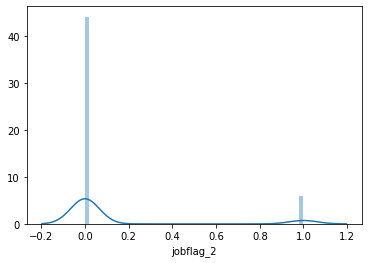

In [6]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
sns.distplot(train_df.jobflag_2)

In [7]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	training's tweedie: 1.20201	valid_1's tweedie: 1.24415
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.21645	valid_1's tweedie: 1.23894
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.20093	valid_1's tweedie: 1.23191
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's tweedie: 1.21131	valid_1's tweedie: 1.23024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.21503	valid_1's tweedie: 1.23862


[I 2020-08-19 20:28:56,466] Finished trial#0 with value: 0.6751949716730823 with parameters: {'tweedie_variance_power': 1.1469330721288091, 'max_bin': 155, 'subsample': 0.7020127714575438, 'subsample_freq': 0.5466433562417581, 'learning_rate': 0.04635663842289766, 'num_leaves': 9, 'feature_fraction': 0.41975373189857373, 'bagging_freq': 5, 'min_child_samples': 63, 'lambda_l1': 0.00018754334977746776, 'lambda_l2': 0.0008561480595007831}. Best is trial#0 with value: 0.6751949716730823.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.39955	valid_1's tweedie: 1.48315
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.4176	valid_1's tweedie: 1.49254
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.32251	valid_1's tweedie: 1.45122
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.39614	valid_1's tweedie: 1.50522
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.33624	valid_1's tweedie: 1.44534


[I 2020-08-19 20:29:04,508] Finished trial#1 with value: 0.7948946728936515 with parameters: {'tweedie_variance_power': 1.5679987733056677, 'max_bin': 140, 'subsample': 0.8504755805608415, 'subsample_freq': 0.557257499692059, 'learning_rate': 0.39356031044409134, 'num_leaves': 4, 'feature_fraction': 0.7368202659610792, 'bagging_freq': 2, 'min_child_samples': 33, 'lambda_l1': 1.9968841374445292, 'lambda_l2': 0.0013221411792172998}. Best is trial#0 with value: 0.6751949716730823.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.04891	valid_1's tweedie: 2.11401
Early stopping, best iteration is:
[319]	training's tweedie: 2.0667	valid_1's tweedie: 2.09144
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.12891	valid_1's tweedie: 2.12053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 2.11098	valid_1's tweedie: 2.11466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's tweedie: 2.06528	valid_1's tweedie: 2.14893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 2.12136	valid_1's tweedie: 2.15187


[I 2020-08-19 20:29:12,654] Finished trial#2 with value: 1.12262046528828 with parameters: {'tweedie_variance_power': 1.663311084680296, 'max_bin': 259, 'subsample': 0.46429302490562896, 'subsample_freq': 0.6574988059615401, 'learning_rate': 0.06801672046774654, 'num_leaves': 5, 'feature_fraction': 0.992288500737779, 'bagging_freq': 5, 'min_child_samples': 94, 'lambda_l1': 4.318139025200585, 'lambda_l2': 0.00014106584906738997}. Best is trial#0 with value: 0.6751949716730823.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.34015	valid_1's tweedie: 1.39862
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.33574	valid_1's tweedie: 1.39085
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.32052	valid_1's tweedie: 1.38772
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.3573	valid_1's tweedie: 1.38591
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.34706	valid_1's tweedie: 1.39895


[I 2020-08-19 20:29:21,009] Finished trial#3 with value: 0.75335947544402 with parameters: {'tweedie_variance_power': 1.1208769071824416, 'max_bin': 262, 'subsample': 0.512294838987601, 'subsample_freq': 0.6506618876213982, 'learning_rate': 0.33195853776912976, 'num_leaves': 4, 'feature_fraction': 0.9581085782300198, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.0006558212824602153, 'lambda_l2': 0.03656329563732067}. Best is trial#0 with value: 0.6751949716730823.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.15546	valid_1's tweedie: 1.20457
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.16874	valid_1's tweedie: 1.19222
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.15653	valid_1's tweedie: 1.19919
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.18348	valid_1's tweedie: 1.19678
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.17509	valid_1's tweedie: 1.20299


[I 2020-08-19 20:29:29,433] Finished trial#4 with value: 0.6560429868980938 with parameters: {'tweedie_variance_power': 1.15590695112872, 'max_bin': 195, 'subsample': 0.7299406448671679, 'subsample_freq': 0.8025969793581622, 'learning_rate': 0.45131685001369504, 'num_leaves': 6, 'feature_fraction': 0.6971332823126974, 'bagging_freq': 1, 'min_child_samples': 53, 'lambda_l1': 3.7098738387420482, 'lambda_l2': 0.0005245242750234472}. Best is trial#4 with value: 0.6560429868980938.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.66062	valid_1's tweedie: 1.72684
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.67211	valid_1's tweedie: 1.67024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.65186	valid_1's tweedie: 1.70266
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.62186	valid_1's tweedie: 1.71799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.69285	valid_1's tweedie: 1.75796


[I 2020-08-19 20:29:37,742] Finished trial#5 with value: 0.9167596516229781 with parameters: {'tweedie_variance_power': 1.6143145238327086, 'max_bin': 210, 'subsample': 0.4736374555589547, 'subsample_freq': 0.5826611932769459, 'learning_rate': 0.23735887061158928, 'num_leaves': 5, 'feature_fraction': 0.6643784158398425, 'bagging_freq': 4, 'min_child_samples': 26, 'lambda_l1': 0.5244773290648307, 'lambda_l2': 0.7092670890155198}. Best is trial#4 with value: 0.6560429868980938.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 0.942898	valid_1's tweedie: 1.02619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 0.961362	valid_1's tweedie: 1.02022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 0.949533	valid_1's tweedie: 1.03121
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.00505	valid_1's tweedie: 1.03076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 0.94166	valid_1's tweedie: 1.03536


[I 2020-08-19 20:29:46,441] Finished trial#6 with value: 0.5715203582202163 with parameters: {'tweedie_variance_power': 1.2289737066161388, 'max_bin': 66, 'subsample': 0.6642082898352051, 'subsample_freq': 0.8626163161079332, 'learning_rate': 0.39136294350147666, 'num_leaves': 8, 'feature_fraction': 0.6203693051893739, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 0.0007537202156547465, 'lambda_l2': 0.0008985241282634807}. Best is trial#6 with value: 0.5715203582202163.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.94197	valid_1's tweedie: 1.94299
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.94184	valid_1's tweedie: 1.94351
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.94184	valid_1's tweedie: 1.94351
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.94267	valid_1's tweedie: 1.94016
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.94254	valid_1's tweedie: 1.94068


[I 2020-08-19 20:29:54,324] Finished trial#7 with value: 1.4117196103312986 with parameters: {'tweedie_variance_power': 1.3891531216345698, 'max_bin': 296, 'subsample': 0.4199453066836916, 'subsample_freq': 0.5223301824821527, 'learning_rate': 0.1755712222068647, 'num_leaves': 4, 'feature_fraction': 0.7145869207161247, 'bagging_freq': 6, 'min_child_samples': 96, 'lambda_l1': 8.017884185935305, 'lambda_l2': 0.3105600351699214}. Best is trial#6 with value: 0.5715203582202163.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.14508	valid_1's tweedie: 2.15043
[1000]	training's tweedie: 2.11152	valid_1's tweedie: 2.13567
Did not meet early stopping. Best iteration is:
[1399]	training's tweedie: 2.09214	valid_1's tweedie: 2.13078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[274]	training's tweedie: 2.1534	valid_1's tweedie: 2.18937
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.12951	valid_1's tweedie: 2.15414
Early stopping, best iteration is:
[336]	training's tweedie: 2.14256	valid_1's tweedie: 2.14645
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 2.16719	valid_1's tweedie: 2.21438
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 2.18317	valid_1's tweedie: 2.21525


[I 2020-08-19 20:30:02,667] Finished trial#8 with value: 1.1488185104184754 with parameters: {'tweedie_variance_power': 1.6700492811543346, 'max_bin': 169, 'subsample': 0.4365681838570331, 'subsample_freq': 0.8990224579257522, 'learning_rate': 0.04613119589989589, 'num_leaves': 5, 'feature_fraction': 0.4853270083789659, 'bagging_freq': 4, 'min_child_samples': 95, 'lambda_l1': 0.004937892634998412, 'lambda_l2': 0.011945952421268785}. Best is trial#6 with value: 0.5715203582202163.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.54728	valid_1's tweedie: 1.57989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.55365	valid_1's tweedie: 1.58899
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.52776	valid_1's tweedie: 1.56397
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.57627	valid_1's tweedie: 1.62071
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.52179	valid_1's tweedie: 1.58593


[I 2020-08-19 20:30:10,785] Finished trial#9 with value: 0.8529737563713278 with parameters: {'tweedie_variance_power': 1.576903663920567, 'max_bin': 50, 'subsample': 0.6141725461525704, 'subsample_freq': 0.5999453231225658, 'learning_rate': 0.11201767639182934, 'num_leaves': 10, 'feature_fraction': 0.5435507897452212, 'bagging_freq': 5, 'min_child_samples': 96, 'lambda_l1': 0.011407056134681064, 'lambda_l2': 0.12021251381382318}. Best is trial#6 with value: 0.5715203582202163.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 0.879468	valid_1's tweedie: 0.991382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 0.891306	valid_1's tweedie: 0.9795
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 0.866444	valid_1's tweedie: 0.982349
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 0.935114	valid_1's tweedie: 0.990712
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 0.923456	valid_1's tweedie: 0.985177


[I 2020-08-19 20:30:19,280] Finished trial#10 with value: 0.5485276766640027 with parameters: {'tweedie_variance_power': 1.331669964640046, 'max_bin': 64, 'subsample': 0.8628264953244374, 'subsample_freq': 0.4208959101000142, 'learning_rate': 0.13072244873355196, 'num_leaves': 8, 'feature_fraction': 0.8444965695365831, 'bagging_freq': 2, 'min_child_samples': 6, 'lambda_l1': 0.11789725706213938, 'lambda_l2': 3.839968983404299}. Best is trial#10 with value: 0.5485276766640027.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 0.891382	valid_1's tweedie: 1.00576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 0.922092	valid_1's tweedie: 0.989835
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 0.888225	valid_1's tweedie: 0.985198
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 0.944952	valid_1's tweedie: 0.99676
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 0.90268	valid_1's tweedie: 0.995847


[I 2020-08-19 20:30:27,723] Finished trial#11 with value: 0.553463112713599 with parameters: {'tweedie_variance_power': 1.349868705711889, 'max_bin': 72, 'subsample': 0.8985788112353336, 'subsample_freq': 0.40881525612892555, 'learning_rate': 0.11190491220521066, 'num_leaves': 8, 'feature_fraction': 0.836893754911771, 'bagging_freq': 2, 'min_child_samples': 9, 'lambda_l1': 0.15915971761253217, 'lambda_l2': 9.46035817195198}. Best is trial#10 with value: 0.5485276766640027.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 0.846994	valid_1's tweedie: 0.988624
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 0.900663	valid_1's tweedie: 0.981423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 0.898913	valid_1's tweedie: 0.97805
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 0.948345	valid_1's tweedie: 0.990374
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 0.882474	valid_1's tweedie: 0.983236


[I 2020-08-19 20:30:36,315] Finished trial#12 with value: 0.5482965966675005 with parameters: {'tweedie_variance_power': 1.3253484020974282, 'max_bin': 98, 'subsample': 0.8795066442938034, 'subsample_freq': 0.4194598172657872, 'learning_rate': 0.10831242132071135, 'num_leaves': 8, 'feature_fraction': 0.8563830919375924, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.10520616869636748, 'lambda_l2': 3.189836044147245}. Best is trial#12 with value: 0.5482965966675005.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 0.908263	valid_1's tweedie: 0.99004
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 0.923591	valid_1's tweedie: 0.983059
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[149]	training's tweedie: 0.895959	valid_1's tweedie: 0.979865
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's tweedie: 0.905972	valid_1's tweedie: 0.985138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 0.914972	valid_1's tweedie: 0.979421


[I 2020-08-19 20:30:44,629] Finished trial#13 with value: 0.5471963418201611 with parameters: {'tweedie_variance_power': 1.3003647002083925, 'max_bin': 108, 'subsample': 0.8023061958845142, 'subsample_freq': 0.4034749518322067, 'learning_rate': 0.07815693364105576, 'num_leaves': 7, 'feature_fraction': 0.886798636453987, 'bagging_freq': 2, 'min_child_samples': 29, 'lambda_l1': 0.08989899657529576, 'lambda_l2': 7.430988333056702}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 4.20199	valid_1's tweedie: 4.25434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 4.2077	valid_1's tweedie: 4.25815
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's tweedie: 4.17653	valid_1's tweedie: 4.25881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 4.21753	valid_1's tweedie: 4.21748
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 4.20708	valid_1's tweedie: 4.22299


[I 2020-08-19 20:30:52,963] Finished trial#14 with value: 2.176962787331967 with parameters: {'tweedie_variance_power': 1.030437764805102, 'max_bin': 117, 'subsample': 0.7803147641315695, 'subsample_freq': 0.46883545402961935, 'learning_rate': 0.07294277665289073, 'num_leaves': 7, 'feature_fraction': 0.8764429323853444, 'bagging_freq': 1, 'min_child_samples': 32, 'lambda_l1': 0.021887082901452515, 'lambda_l2': 2.570419725372729}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 1.08923	valid_1's tweedie: 1.18052
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.12549	valid_1's tweedie: 1.18053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.04377	valid_1's tweedie: 1.16988
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.14543	valid_1's tweedie: 1.19989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.07069	valid_1's tweedie: 1.18175


[I 2020-08-19 20:31:01,252] Finished trial#15 with value: 0.6465288373703457 with parameters: {'tweedie_variance_power': 1.4763326094950873, 'max_bin': 102, 'subsample': 0.7885569005093033, 'subsample_freq': 0.4622545423478303, 'learning_rate': 0.07775313573767796, 'num_leaves': 7, 'feature_fraction': 0.9206768036894377, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.09878025113947773, 'lambda_l2': 7.2971079517740085}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[217]	training's tweedie: 0.925199	valid_1's tweedie: 1.00392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's tweedie: 0.947466	valid_1's tweedie: 0.994336
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	training's tweedie: 0.937311	valid_1's tweedie: 0.992211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 0.960635	valid_1's tweedie: 1.00548
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	training's tweedie: 0.937773	valid_1's tweedie: 1.00047


[I 2020-08-19 20:31:09,740] Finished trial#16 with value: 0.5550858329416382 with parameters: {'tweedie_variance_power': 1.2525573572164075, 'max_bin': 107, 'subsample': 0.8162253600041296, 'subsample_freq': 0.7351596925126813, 'learning_rate': 0.031096055434349214, 'num_leaves': 10, 'feature_fraction': 0.8014953696316731, 'bagging_freq': 3, 'min_child_samples': 44, 'lambda_l1': 0.5917430444869781, 'lambda_l2': 1.1303129776882788}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.05102	valid_1's tweedie: 1.13966
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.07463	valid_1's tweedie: 1.1186
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.01711	valid_1's tweedie: 1.09933
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.09556	valid_1's tweedie: 1.14855
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.10821	valid_1's tweedie: 1.14767


[I 2020-08-19 20:31:17,878] Finished trial#17 with value: 0.6208259942782601 with parameters: {'tweedie_variance_power': 1.4435751173563494, 'max_bin': 96, 'subsample': 0.8951778737156593, 'subsample_freq': 0.475550958968608, 'learning_rate': 0.15946697287966058, 'num_leaves': 9, 'feature_fraction': 0.7877223914276018, 'bagging_freq': 1, 'min_child_samples': 67, 'lambda_l1': 0.0033212333500072786, 'lambda_l2': 0.20487032035744976}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 2.99541	valid_1's tweedie: 3.15693
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 3.05267	valid_1's tweedie: 3.10964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's tweedie: 2.97756	valid_1's tweedie: 3.1055
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 3.08326	valid_1's tweedie: 3.19083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 3.07058	valid_1's tweedie: 3.16467


[I 2020-08-19 20:31:25,953] Finished trial#18 with value: 1.6285406577185932 with parameters: {'tweedie_variance_power': 1.7639389188347072, 'max_bin': 131, 'subsample': 0.5947881304560337, 'subsample_freq': 0.4176123625048595, 'learning_rate': 0.055439874551849976, 'num_leaves': 6, 'feature_fraction': 0.9152276323062587, 'bagging_freq': 3, 'min_child_samples': 43, 'lambda_l1': 0.05213457962064915, 'lambda_l2': 8.511707951896248}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	training's tweedie: 0.901285	valid_1's tweedie: 0.990874
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 0.927573	valid_1's tweedie: 0.98372
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[255]	training's tweedie: 0.889905	valid_1's tweedie: 0.981415
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 0.926309	valid_1's tweedie: 0.985423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's tweedie: 0.915474	valid_1's tweedie: 0.981284


[I 2020-08-19 20:31:34,660] Finished trial#19 with value: 0.5485645648256361 with parameters: {'tweedie_variance_power': 1.273155118387555, 'max_bin': 83, 'subsample': 0.746293747591476, 'subsample_freq': 0.49799781334000603, 'learning_rate': 0.0306545150255808, 'num_leaves': 9, 'feature_fraction': 0.7740914165111726, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 0.4045533571226862, 'lambda_l2': 1.701142978175973}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.2072	valid_1's tweedie: 1.28952
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.24815	valid_1's tweedie: 1.2637
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.1951	valid_1's tweedie: 1.26466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.22373	valid_1's tweedie: 1.29653
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.21157	valid_1's tweedie: 1.26053


[I 2020-08-19 20:31:42,772] Finished trial#20 with value: 0.6944724652556533 with parameters: {'tweedie_variance_power': 1.5076008945221022, 'max_bin': 195, 'subsample': 0.8294693416785266, 'subsample_freq': 0.727891788349224, 'learning_rate': 0.09062586346473381, 'num_leaves': 6, 'feature_fraction': 0.9602776712254047, 'bagging_freq': 7, 'min_child_samples': 35, 'lambda_l1': 0.021399650081631128, 'lambda_l2': 0.007520405302350915}. Best is trial#13 with value: 0.5471963418201611.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 0.870331	valid_1's tweedie: 0.985052
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 0.885951	valid_1's tweedie: 0.982819
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 0.876303	valid_1's tweedie: 0.979067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 0.890066	valid_1's tweedie: 0.994672
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 0.916045	valid_1's tweedie: 0.9806


[I 2020-08-19 20:31:51,309] Finished trial#21 with value: 0.5471514222227059 with parameters: {'tweedie_variance_power': 1.3325132087065898, 'max_bin': 58, 'subsample': 0.8786544359593447, 'subsample_freq': 0.4003234342506389, 'learning_rate': 0.14722587266329976, 'num_leaves': 8, 'feature_fraction': 0.861200331026003, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.19703139033769124, 'lambda_l2': 3.5362286014029967}. Best is trial#21 with value: 0.5471514222227059.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 0.841249	valid_1's tweedie: 0.991047
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 0.920069	valid_1's tweedie: 0.977935
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 0.868058	valid_1's tweedie: 0.965026
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 0.907386	valid_1's tweedie: 0.980788
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 0.90652	valid_1's tweedie: 0.966327


[I 2020-08-19 20:31:59,633] Finished trial#22 with value: 0.5433841451015333 with parameters: {'tweedie_variance_power': 1.3078829583409979, 'max_bin': 84, 'subsample': 0.8885315436054777, 'subsample_freq': 0.40058113013872815, 'learning_rate': 0.21019607825492564, 'num_leaves': 8, 'feature_fraction': 0.8907460920487789, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 1.141030388835325, 'lambda_l2': 0.6880091897055302}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 0.937633	valid_1's tweedie: 1.05518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 0.96742	valid_1's tweedie: 1.03615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 0.934749	valid_1's tweedie: 1.02445
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 0.99254	valid_1's tweedie: 1.0508
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 0.949085	valid_1's tweedie: 1.03896


[I 2020-08-19 20:32:07,541] Finished trial#23 with value: 0.5758241667239504 with parameters: {'tweedie_variance_power': 1.3953385889444412, 'max_bin': 58, 'subsample': 0.8985069149266952, 'subsample_freq': 0.4033624699891429, 'learning_rate': 0.2620030205975368, 'num_leaves': 7, 'feature_fraction': 0.8916180717190134, 'bagging_freq': 3, 'min_child_samples': 17, 'lambda_l1': 1.288588112670373, 'lambda_l2': 0.5548633667883288}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 0.982911	valid_1's tweedie: 1.08064
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.0217	valid_1's tweedie: 1.07319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 0.989384	valid_1's tweedie: 1.08146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.03689	valid_1's tweedie: 1.07013
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.0242	valid_1's tweedie: 1.06455


[I 2020-08-19 20:32:15,537] Finished trial#24 with value: 0.5917585843223658 with parameters: {'tweedie_variance_power': 1.1944918675778755, 'max_bin': 82, 'subsample': 0.7979986568706293, 'subsample_freq': 0.45508006391841377, 'learning_rate': 0.20037040640622567, 'num_leaves': 8, 'feature_fraction': 0.9810734790293236, 'bagging_freq': 3, 'min_child_samples': 25, 'lambda_l1': 0.2216817185457688, 'lambda_l2': 0.07699354324308014}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's tweedie: 2.0608	valid_1's tweedie: 2.11868
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 2.07291	valid_1's tweedie: 2.11956
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 2.0493	valid_1's tweedie: 2.12056
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.08687	valid_1's tweedie: 2.10168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 2.06949	valid_1's tweedie: 2.10823


[I 2020-08-19 20:32:23,515] Finished trial#25 with value: 1.111291618712344 with parameters: {'tweedie_variance_power': 1.0677872209084134, 'max_bin': 50, 'subsample': 0.8418108826604187, 'subsample_freq': 0.4017773278755963, 'learning_rate': 0.1404761763571683, 'num_leaves': 9, 'feature_fraction': 0.9329621526205589, 'bagging_freq': 1, 'min_child_samples': 15, 'lambda_l1': 1.756343971556644, 'lambda_l2': 9.04356253495706}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 0.868625	valid_1's tweedie: 0.984981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.903567	valid_1's tweedie: 0.975839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 0.884605	valid_1's tweedie: 0.974463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 0.918656	valid_1's tweedie: 0.994197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.901741	valid_1's tweedie: 0.976781


[I 2020-08-19 20:32:31,410] Finished trial#26 with value: 0.5465765081429782 with parameters: {'tweedie_variance_power': 1.3059693332694806, 'max_bin': 128, 'subsample': 0.7492285710214612, 'subsample_freq': 0.5120137714691353, 'learning_rate': 0.26334417350684003, 'num_leaves': 7, 'feature_fraction': 0.9978797271368279, 'bagging_freq': 2, 'min_child_samples': 12, 'lambda_l1': 0.039065084638975796, 'lambda_l2': 1.2162621021986046}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.0049	valid_1's tweedie: 1.0477
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.02432	valid_1's tweedie: 1.04214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.01005	valid_1's tweedie: 1.03671
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.00146	valid_1's tweedie: 1.047
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.02224	valid_1's tweedie: 1.04097


[I 2020-08-19 20:32:39,157] Finished trial#27 with value: 0.5789396971419123 with parameters: {'tweedie_variance_power': 1.2165631794620861, 'max_bin': 128, 'subsample': 0.7499735157572123, 'subsample_freq': 0.513089840822776, 'learning_rate': 0.26816463130950136, 'num_leaves': 8, 'feature_fraction': 0.9938857669555349, 'bagging_freq': 3, 'min_child_samples': 82, 'lambda_l1': 0.03518989307799324, 'lambda_l2': 0.42187404426359054}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.05886	valid_1's tweedie: 1.13435
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.01993	valid_1's tweedie: 1.08628
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.0189	valid_1's tweedie: 1.10072
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.07455	valid_1's tweedie: 1.13057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.03236	valid_1's tweedie: 1.10316


[I 2020-08-19 20:32:47,083] Finished trial#28 with value: 0.6135115480616631 with parameters: {'tweedie_variance_power': 1.43711189463894, 'max_bin': 159, 'subsample': 0.676467938549559, 'subsample_freq': 0.6156691486774496, 'learning_rate': 0.20677107140871792, 'num_leaves': 6, 'feature_fraction': 0.8253816914190527, 'bagging_freq': 1, 'min_child_samples': 12, 'lambda_l1': 0.3317694151361708, 'lambda_l2': 1.0680327923606647}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 0.926199	valid_1's tweedie: 1.02781
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 0.981777	valid_1's tweedie: 1.01517
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 0.929911	valid_1's tweedie: 1.0001
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 0.989247	valid_1's tweedie: 1.03552
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 0.976702	valid_1's tweedie: 1.03017


[I 2020-08-19 20:32:55,042] Finished trial#29 with value: 0.5675125058746036 with parameters: {'tweedie_variance_power': 1.3686128454820579, 'max_bin': 153, 'subsample': 0.7186143308589912, 'subsample_freq': 0.5353936061710222, 'learning_rate': 0.30229775211401977, 'num_leaves': 9, 'feature_fraction': 0.7534287874333211, 'bagging_freq': 2, 'min_child_samples': 68, 'lambda_l1': 0.888185143737204, 'lambda_l2': 0.1249671259887326}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.09754	valid_1's tweedie: 1.18398
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.0913	valid_1's tweedie: 1.17736
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.0531	valid_1's tweedie: 1.18056
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.11503	valid_1's tweedie: 1.17306
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.12572	valid_1's tweedie: 1.1793


[I 2020-08-19 20:33:03,261] Finished trial#30 with value: 0.6452074977626883 with parameters: {'tweedie_variance_power': 1.159250390274003, 'max_bin': 83, 'subsample': 0.5966092134724346, 'subsample_freq': 0.4462193430711896, 'learning_rate': 0.18129007691082558, 'num_leaves': 7, 'feature_fraction': 0.9284578792037927, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00607149536479234, 'lambda_l2': 0.04233513494380104}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 0.920218	valid_1's tweedie: 0.98485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 0.937656	valid_1's tweedie: 0.981731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 0.902599	valid_1's tweedie: 0.981192
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 0.931221	valid_1's tweedie: 0.983444
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 0.9393	valid_1's tweedie: 0.984361


[I 2020-08-19 20:33:11,225] Finished trial#31 with value: 0.5470037474919316 with parameters: {'tweedie_variance_power': 1.2913006302564372, 'max_bin': 115, 'subsample': 0.7734023446061403, 'subsample_freq': 0.4913602885262275, 'learning_rate': 0.1490259029840911, 'num_leaves': 7, 'feature_fraction': 0.8882843348795695, 'bagging_freq': 2, 'min_child_samples': 26, 'lambda_l1': 0.04452058139184771, 'lambda_l2': 3.8058512758718614}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 0.924966	valid_1's tweedie: 0.987399
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 0.941405	valid_1's tweedie: 0.987007
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 0.916624	valid_1's tweedie: 0.992379
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 0.959181	valid_1's tweedie: 0.993759
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 0.964821	valid_1's tweedie: 0.993245


[I 2020-08-19 20:33:19,064] Finished trial#32 with value: 0.5499689712140858 with parameters: {'tweedie_variance_power': 1.2822437832867033, 'max_bin': 141, 'subsample': 0.6973271399086849, 'subsample_freq': 0.5485800360004496, 'learning_rate': 0.14627828159207626, 'num_leaves': 8, 'feature_fraction': 0.9960898139519039, 'bagging_freq': 2, 'min_child_samples': 41, 'lambda_l1': 0.046355103068938946, 'lambda_l2': 3.4111215881422936}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 0.875034	valid_1's tweedie: 1.00159
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 0.91092	valid_1's tweedie: 0.97913
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 0.878293	valid_1's tweedie: 0.975919
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 0.948707	valid_1's tweedie: 0.994287
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.923885	valid_1's tweedie: 0.979584


[I 2020-08-19 20:33:26,923] Finished trial#33 with value: 0.5495193778274549 with parameters: {'tweedie_variance_power': 1.3214057038612739, 'max_bin': 122, 'subsample': 0.7680589366335654, 'subsample_freq': 0.49384361049542164, 'learning_rate': 0.2224252573104051, 'num_leaves': 7, 'feature_fraction': 0.8097360110889532, 'bagging_freq': 3, 'min_child_samples': 20, 'lambda_l1': 0.01472604081812262, 'lambda_l2': 1.488040565536784}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 0.994735	valid_1's tweedie: 1.08374
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.01835	valid_1's tweedie: 1.07154
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.00036	valid_1's tweedie: 1.06816
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.01528	valid_1's tweedie: 1.0691
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.0222	valid_1's tweedie: 1.07039


[I 2020-08-19 20:33:34,825] Finished trial#34 with value: 0.5927602401945914 with parameters: {'tweedie_variance_power': 1.1949118822538811, 'max_bin': 144, 'subsample': 0.8600306926825421, 'subsample_freq': 0.5671466226092755, 'learning_rate': 0.3221890758650883, 'num_leaves': 6, 'feature_fraction': 0.9597529941201668, 'bagging_freq': 2, 'min_child_samples': 11, 'lambda_l1': 0.2275736808508438, 'lambda_l2': 4.834588068033913}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's tweedie: 1.62664	valid_1's tweedie: 1.68117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.65076	valid_1's tweedie: 1.67614
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.62152	valid_1's tweedie: 1.67964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.654	valid_1's tweedie: 1.66815
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.66303	valid_1's tweedie: 1.67498


[I 2020-08-19 20:33:42,693] Finished trial#35 with value: 0.8939593942305343 with parameters: {'tweedie_variance_power': 1.0920088371334435, 'max_bin': 88, 'subsample': 0.8324512465796959, 'subsample_freq': 0.43823429534116976, 'learning_rate': 0.1706161154878105, 'num_leaves': 8, 'feature_fraction': 0.8953911456390384, 'bagging_freq': 1, 'min_child_samples': 57, 'lambda_l1': 2.55525843855774, 'lambda_l2': 0.809323103596656}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 0.984646	valid_1's tweedie: 1.1162
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.05123	valid_1's tweedie: 1.08385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.01158	valid_1's tweedie: 1.11223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.02282	valid_1's tweedie: 1.11959
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.0357	valid_1's tweedie: 1.10914


[I 2020-08-19 20:33:50,444] Finished trial#36 with value: 0.6119303205406014 with parameters: {'tweedie_variance_power': 1.4319428234127303, 'max_bin': 116, 'subsample': 0.6997695933428945, 'subsample_freq': 0.6886385973045475, 'learning_rate': 0.48183846046841977, 'num_leaves': 7, 'feature_fraction': 0.8569001149338581, 'bagging_freq': 2, 'min_child_samples': 23, 'lambda_l1': 8.643272812920682, 'lambda_l2': 0.2693438500515587}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.19696	valid_1's tweedie: 1.3182
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.13624	valid_1's tweedie: 1.2483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.22967	valid_1's tweedie: 1.27097
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.22653	valid_1's tweedie: 1.29861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.19659	valid_1's tweedie: 1.28537


[I 2020-08-19 20:33:58,285] Finished trial#37 with value: 0.6965671662433421 with parameters: {'tweedie_variance_power': 1.5102111814373642, 'max_bin': 176, 'subsample': 0.6290530671548658, 'subsample_freq': 0.5074956685924341, 'learning_rate': 0.37637051806919003, 'num_leaves': 6, 'feature_fraction': 0.9491957032594257, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.0557318344687899, 'lambda_l2': 2.249838072864796}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 0.945288	valid_1's tweedie: 1.00701
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 0.953529	valid_1's tweedie: 1.00224
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 0.923409	valid_1's tweedie: 0.991745
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 0.930091	valid_1's tweedie: 1.01117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 0.935713	valid_1's tweedie: 1.00835


[I 2020-08-19 20:34:06,078] Finished trial#38 with value: 0.5590310161416363 with parameters: {'tweedie_variance_power': 1.2429174920203185, 'max_bin': 71, 'subsample': 0.8643205939791506, 'subsample_freq': 0.4869756911373715, 'learning_rate': 0.2390372248268394, 'num_leaves': 8, 'feature_fraction': 0.6715842892997425, 'bagging_freq': 1, 'min_child_samples': 37, 'lambda_l1': 0.9562907338958863, 'lambda_l2': 0.5846041114597263}. Best is trial#22 with value: 0.5433841451015333.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.15778	valid_1's tweedie: 1.24629
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.14717	valid_1's tweedie: 1.23356
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.1849	valid_1's tweedie: 1.23802
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.19057	valid_1's tweedie: 1.22917
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.18828	valid_1's tweedie: 1.2395


[I 2020-08-19 20:34:13,985] Finished trial#39 with value: 0.6746071272647992 with parameters: {'tweedie_variance_power': 1.146884080207802, 'max_bin': 50, 'subsample': 0.5667016687255778, 'subsample_freq': 0.5758964754999032, 'learning_rate': 0.18675665741077177, 'num_leaves': 9, 'feature_fraction': 0.7247686678314789, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.0017812789429112698, 'lambda_l2': 0.00014361757494307223}. Best is trial#22 with value: 0.5433841451015333.


0.5433841451015333
{'tweedie_variance_power': 1.3078829583409979, 'max_bin': 84, 'subsample': 0.8885315436054777, 'subsample_freq': 0.40058113013872815, 'learning_rate': 0.21019607825492564, 'num_leaves': 8, 'feature_fraction': 0.8907460920487789, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 1.141030388835325, 'lambda_l2': 0.6880091897055302}


In [8]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3078829583409979, 'max_bin': 84, 'subsample': 0.8885315436054777, 
    'subsample_freq': 0.40058113013872815, 'learning_rate': 0.21019607825492564, 'num_leaves': 8, 'feature_fraction': 0.8907460920487789,
    'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 1.141030388835325, 'lambda_l2': 0.6880091897055302
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 0.901721	valid_1's tweedie: 0.986607
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 0.936546	valid_1's tweedie: 0.975118
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 0.846534	valid_1's tweedie: 0.964611
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 0.899396	valid_1's tweedie: 0.988716
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 0.904723	valid_1's tweedie: 0.97187

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
             

[15]	training's tweedie: 2.8872	valid_1's tweedie: 2.82839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 2.8484	valid_1's tweedie: 2.93291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.89295	valid_1's tweedie: 2.835

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.88799	valid_1's tweedie: 2.81285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.8735	valid_1's tweedie: 2.87715
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 2.85328	valid_1's tweedie: 2.99332
Training until validation scores don't improve for 200 rounds
Earl

[13]	training's tweedie: 2.85952	valid_1's tweedie: 2.86508

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.8802	valid_1's tweedie: 2.90256
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 2.86806	valid_1's tweedie: 2.97752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.88615	valid_1's tweedie: 2.88311
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.87412	valid_1's tweedie: 2.94586
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.89695	valid_1's tweedie: 2.80906

                
                Train Null Importance   29
 

[21]	training's tweedie: 2.88647	valid_1's tweedie: 2.94151
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.88952	valid_1's tweedie: 2.98375
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 2.91288	valid_1's tweedie: 2.82991

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.89698	valid_1's tweedie: 2.94107
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.89484	valid_1's tweedie: 2.93512
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.9094	valid_1's tweedie: 2.87993
Training until validation scores don't improve for 200 rounds

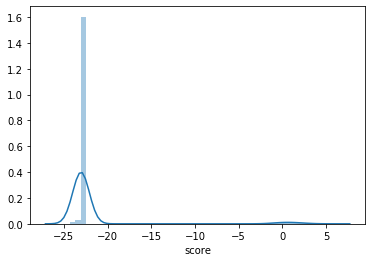

In [9]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [10]:
feature = ['machinelearn', 'ai', 'deep', 'model', 'data', 'learn', 'prototyp', 'team', 'scientist', 'client', 'architectur', 'provid', 
           'custom', 'effici', 'concept', 'technolog', 'differ', 'test', 'support', 'research', 'analysi', 'algorithm', 'deploy',
           'approach', 'featur', 'sourc', 'code', 'particip', 'network', 'pipelin', 'includ', 'activ', 'issu', 'softwar', 'limit',
           'manag', 'respons', 'improv', 'product', 'architect', 'analyz', 'build', 'program', 'expert', 'write', 'scienc', 'translat',
           'sale', 'need', 'insight', 'key', 'solut', 'partner', 'environ', 'avail', 'complex', 'explor', 'level', 'control', 'execut',
           'exist', 'document', 'drive', 'appropri', 'project', 'develop', 'capabl', 'practic', 'busi', 'extract', 'extern', 'engin',
           'commun', 'distribut', 'process', 'optim', 'integr', 'applic', 'recommend', 'qualiti', 'best', 'review', 'effect', 'collabor',
           'ensur', 'system', 'report', 'problem', 'cloud', 'techniqu', 'appli', 'implement', 'perform', 'scale', 'use', 'design', 'user',
           'infrastructur', 'organ', 'deliveri', 'procedur', 'defin', 'determin', 'dataset', 'abil', 'scalabl', 'technic', 'initi',
           'standard', 'analyt', 'predict', 'function', 'abl', 'continu', 'meet', 'new', 'compani', 'valu', 'tool', 'util', 'gener', 
           'platform', 'task', 'accuraci', 'valid', 'specif', 'plan', 'unit', 'requir', 'opportun', 'base', 'will', 'cross', 'make',
           'contribut', 'assist', 'configur', 'leverag', 'maintain', 'visual', 'secur', 'train', 'work', 'identifi', 'strategi']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.00294	valid_1's tweedie: 1.10261
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.04617	valid_1's tweedie: 1.10305
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's tweedie: 1.02386	valid_1's tweedie: 1.10156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.04257	valid_1's tweedie: 1.0982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 1.03072	valid_1's tweedie: 1.10809


[I 2020-08-19 20:44:47,344] Finished trial#0 with value: 0.6079899046813825 with parameters: {'tweedie_variance_power': 1.1820700806562263, 'max_bin': 85, 'subsample': 0.764346934629794, 'subsample_freq': 0.8724612429284794, 'learning_rate': 0.18807348883345149, 'num_leaves': 7, 'feature_fraction': 0.5199005268332358, 'bagging_freq': 1, 'min_child_samples': 13, 'lambda_l1': 0.06762915002718216, 'lambda_l2': 6.570368185063585}. Best is trial#0 with value: 0.6079899046813825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.81129	valid_1's tweedie: 1.86197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.81397	valid_1's tweedie: 1.88765
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's tweedie: 1.80495	valid_1's tweedie: 1.878
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.87286	valid_1's tweedie: 1.9413
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.84441	valid_1's tweedie: 1.89539


[I 2020-08-19 20:44:48,141] Finished trial#1 with value: 1.0056260670483725 with parameters: {'tweedie_variance_power': 1.6391477491411086, 'max_bin': 109, 'subsample': 0.4383671086870593, 'subsample_freq': 0.5719135748793971, 'learning_rate': 0.05226841906304778, 'num_leaves': 10, 'feature_fraction': 0.7734498984579943, 'bagging_freq': 2, 'min_child_samples': 56, 'lambda_l1': 0.06162416173447526, 'lambda_l2': 0.0344031440096262}. Best is trial#0 with value: 0.6079899046813825.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's tweedie: 0.942458	valid_1's tweedie: 1.00146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's tweedie: 0.959472	valid_1's tweedie: 0.990572
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's tweedie: 0.933959	valid_1's tweedie: 0.987295
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 0.951659	valid_1's tweedie: 0.995909
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's tweedie: 0.967143	valid_1's tweedie: 0.994951


[I 2020-08-19 20:44:49,043] Finished trial#2 with value: 0.5528019735587751 with parameters: {'tweedie_variance_power': 1.2743179027072236, 'max_bin': 156, 'subsample': 0.5937219006193707, 'subsample_freq': 0.6107185165157105, 'learning_rate': 0.05193744636456023, 'num_leaves': 9, 'feature_fraction': 0.8266945741503484, 'bagging_freq': 5, 'min_child_samples': 48, 'lambda_l1': 4.368348657627277, 'lambda_l2': 0.00384574551237155}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.17482	valid_1's tweedie: 1.25205
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.134	valid_1's tweedie: 1.19991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.20401	valid_1's tweedie: 1.22672
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.20877	valid_1's tweedie: 1.2417
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.20306	valid_1's tweedie: 1.23542


[I 2020-08-19 20:44:49,786] Finished trial#3 with value: 0.6730701875095404 with parameters: {'tweedie_variance_power': 1.4823871441062133, 'max_bin': 177, 'subsample': 0.4098654099866158, 'subsample_freq': 0.7624712503387283, 'learning_rate': 0.21466012612327354, 'num_leaves': 9, 'feature_fraction': 0.8376028052354805, 'bagging_freq': 7, 'min_child_samples': 30, 'lambda_l1': 0.11903670552228629, 'lambda_l2': 0.00031692774384485425}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.56752	valid_1's tweedie: 1.62376
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.53919	valid_1's tweedie: 1.55459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.48512	valid_1's tweedie: 1.54725
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.61384	valid_1's tweedie: 1.65259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.55427	valid_1's tweedie: 1.59078


[I 2020-08-19 20:44:50,439] Finished trial#4 with value: 0.853706718295645 with parameters: {'tweedie_variance_power': 1.5914852479374488, 'max_bin': 182, 'subsample': 0.6912970275798022, 'subsample_freq': 0.45507504312293184, 'learning_rate': 0.13498176843714077, 'num_leaves': 4, 'feature_fraction': 0.9799598252579581, 'bagging_freq': 7, 'min_child_samples': 63, 'lambda_l1': 0.004176093989468395, 'lambda_l2': 1.307757346835121}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.57512	valid_1's tweedie: 1.61771
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.60283	valid_1's tweedie: 1.62449
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.59002	valid_1's tweedie: 1.61334
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.61459	valid_1's tweedie: 1.6716
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.59615	valid_1's tweedie: 1.63544


[I 2020-08-19 20:44:51,102] Finished trial#5 with value: 0.8756225554378309 with parameters: {'tweedie_variance_power': 1.5856960808823455, 'max_bin': 280, 'subsample': 0.6892155842240288, 'subsample_freq': 0.4142328997122619, 'learning_rate': 0.39920183610603927, 'num_leaves': 7, 'feature_fraction': 0.7796061601631659, 'bagging_freq': 5, 'min_child_samples': 90, 'lambda_l1': 0.00020494581938136676, 'lambda_l2': 2.9838130337744944}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's tweedie: 1.20069	valid_1's tweedie: 1.27586
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.24666	valid_1's tweedie: 1.26922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.22442	valid_1's tweedie: 1.25301
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.23308	valid_1's tweedie: 1.29951
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.2266	valid_1's tweedie: 1.28043


[I 2020-08-19 20:44:51,904] Finished trial#6 with value: 0.6970008206035192 with parameters: {'tweedie_variance_power': 1.5027287652320103, 'max_bin': 199, 'subsample': 0.5399381340285224, 'subsample_freq': 0.835215202403493, 'learning_rate': 0.06475111417992051, 'num_leaves': 8, 'feature_fraction': 0.9796483174517769, 'bagging_freq': 1, 'min_child_samples': 64, 'lambda_l1': 0.022844872625143484, 'lambda_l2': 0.14865958845972632}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 2.95298	valid_1's tweedie: 3.08436
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 2.98339	valid_1's tweedie: 3.0691
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 2.85715	valid_1's tweedie: 3.01758
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 2.99097	valid_1's tweedie: 3.15547
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 2.94676	valid_1's tweedie: 3.0487


[I 2020-08-19 20:44:52,638] Finished trial#7 with value: 1.5941568569092919 with parameters: {'tweedie_variance_power': 1.7586390696199008, 'max_bin': 127, 'subsample': 0.7669801278737534, 'subsample_freq': 0.8471609985831926, 'learning_rate': 0.07612044953150317, 'num_leaves': 7, 'feature_fraction': 0.5431872460394944, 'bagging_freq': 2, 'min_child_samples': 47, 'lambda_l1': 0.00037247114071998225, 'lambda_l2': 0.00012151718066206667}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 1.57261	valid_1's tweedie: 1.66543
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.58142	valid_1's tweedie: 1.62919
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	training's tweedie: 1.48737	valid_1's tweedie: 1.59745
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.60601	valid_1's tweedie: 1.68408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's tweedie: 1.54121	valid_1's tweedie: 1.63714


[I 2020-08-19 20:44:53,435] Finished trial#8 with value: 0.878650123722754 with parameters: {'tweedie_variance_power': 1.6044711663585955, 'max_bin': 226, 'subsample': 0.8883254741625461, 'subsample_freq': 0.788367752686983, 'learning_rate': 0.03751683614978442, 'num_leaves': 5, 'feature_fraction': 0.5971253655499588, 'bagging_freq': 3, 'min_child_samples': 46, 'lambda_l1': 0.8627761633811151, 'lambda_l2': 3.6897622056638304}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's tweedie: 1.57316	valid_1's tweedie: 1.66491
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[251]	training's tweedie: 1.57507	valid_1's tweedie: 1.66521
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's tweedie: 1.58747	valid_1's tweedie: 1.66202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.62365	valid_1's tweedie: 1.6559
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 1.61112	valid_1's tweedie: 1.65788


[I 2020-08-19 20:44:54,391] Finished trial#9 with value: 0.8860364679559308 with parameters: {'tweedie_variance_power': 1.0922743059024143, 'max_bin': 184, 'subsample': 0.706931839475309, 'subsample_freq': 0.8149547216998754, 'learning_rate': 0.07277957178655586, 'num_leaves': 8, 'feature_fraction': 0.5799033417011952, 'bagging_freq': 3, 'min_child_samples': 9, 'lambda_l1': 0.14912520624040046, 'lambda_l2': 3.5294951263079133}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.8397	valid_1's tweedie: 1.84095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.83954	valid_1's tweedie: 1.84159
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.83954	valid_1's tweedie: 1.84159
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.84057	valid_1's tweedie: 1.8375
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.84041	valid_1's tweedie: 1.83813


[I 2020-08-19 20:44:54,972] Finished trial#10 with value: 1.3606100325342096 with parameters: {'tweedie_variance_power': 1.318317510579819, 'max_bin': 60, 'subsample': 0.5588367383808804, 'subsample_freq': 0.6407863356713919, 'learning_rate': 0.0338747272537954, 'num_leaves': 10, 'feature_fraction': 0.42673010825662105, 'bagging_freq': 5, 'min_child_samples': 92, 'lambda_l1': 8.557350942277543, 'lambda_l2': 0.0014895748748873475}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's tweedie: 1.05134	valid_1's tweedie: 1.09492
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.05835	valid_1's tweedie: 1.09142
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.05802	valid_1's tweedie: 1.0915
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.0561	valid_1's tweedie: 1.08138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.06774	valid_1's tweedie: 1.0891


[I 2020-08-19 20:44:55,634] Finished trial#11 with value: 0.60180962374541 with parameters: {'tweedie_variance_power': 1.1916766529848146, 'max_bin': 54, 'subsample': 0.8165722055817249, 'subsample_freq': 0.5437632498706015, 'learning_rate': 0.213313930378266, 'num_leaves': 5, 'feature_fraction': 0.44651113969435113, 'bagging_freq': 5, 'min_child_samples': 6, 'lambda_l1': 9.491784783883842, 'lambda_l2': 0.0033373445106268454}. Best is trial#2 with value: 0.5528019735587751.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 0.902856	valid_1's tweedie: 0.988405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 0.926119	valid_1's tweedie: 0.977058
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 0.933694	valid_1's tweedie: 0.989835
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 0.944837	valid_1's tweedie: 0.988459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 0.953011	valid_1's tweedie: 0.978788


[I 2020-08-19 20:44:56,297] Finished trial#12 with value: 0.5476911651385896 with parameters: {'tweedie_variance_power': 1.3014991003823067, 'max_bin': 134, 'subsample': 0.8990859498726816, 'subsample_freq': 0.5274951186330312, 'learning_rate': 0.3937162652059595, 'num_leaves': 5, 'feature_fraction': 0.8861294810479933, 'bagging_freq': 5, 'min_child_samples': 28, 'lambda_l1': 6.037171725930821, 'lambda_l2': 0.0025254105473444784}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 0.955653	valid_1's tweedie: 1.02202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 0.975582	valid_1's tweedie: 0.997036
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 0.934954	valid_1's tweedie: 1.00459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 0.997373	valid_1's tweedie: 1.02641
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.00617	valid_1's tweedie: 1.01811


[I 2020-08-19 20:44:56,972] Finished trial#13 with value: 0.5636247035673656 with parameters: {'tweedie_variance_power': 1.3451436033468036, 'max_bin': 137, 'subsample': 0.5589764295457278, 'subsample_freq': 0.5043335842548009, 'learning_rate': 0.4917359962587978, 'num_leaves': 5, 'feature_fraction': 0.8891926545160874, 'bagging_freq': 6, 'min_child_samples': 33, 'lambda_l1': 1.5604392876073303, 'lambda_l2': 0.004752812374467526}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 0.957727	valid_1's tweedie: 1.02201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 0.981395	valid_1's tweedie: 1.01828
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 0.934637	valid_1's tweedie: 1.02265
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 0.959685	valid_1's tweedie: 1.01869
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.01183	valid_1's tweedie: 1.01702


[I 2020-08-19 20:44:57,657] Finished trial#14 with value: 0.5654771409782264 with parameters: {'tweedie_variance_power': 1.2354347995117847, 'max_bin': 138, 'subsample': 0.6117211609857836, 'subsample_freq': 0.6845553791405872, 'learning_rate': 0.33749412830215525, 'num_leaves': 4, 'feature_fraction': 0.8994578870849221, 'bagging_freq': 4, 'min_child_samples': 26, 'lambda_l1': 1.728268907510391, 'lambda_l2': 0.01693847001556506}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 11.0142	valid_1's tweedie: 11.0476
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 11.0099	valid_1's tweedie: 11.0647
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 11.0099	valid_1's tweedie: 11.0647
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 11.0374	valid_1's tweedie: 10.955
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 11.0331	valid_1's tweedie: 10.972


[I 2020-08-19 20:44:58,248] Finished trial#15 with value: 5.951039376911319 with parameters: {'tweedie_variance_power': 1.011862514421776, 'max_bin': 232, 'subsample': 0.4914700955916511, 'subsample_freq': 0.6247133225972581, 'learning_rate': 0.1089570482553701, 'num_leaves': 6, 'feature_fraction': 0.6811861825802591, 'bagging_freq': 6, 'min_child_samples': 75, 'lambda_l1': 9.804247446669214, 'lambda_l2': 0.0005352534574261056}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.937369	valid_1's tweedie: 1.04382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 0.984654	valid_1's tweedie: 1.03671
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 0.933482	valid_1's tweedie: 1.02491
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 0.964838	valid_1's tweedie: 1.04917
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 0.96054	valid_1's tweedie: 1.02962


[I 2020-08-19 20:44:59,126] Finished trial#16 with value: 0.5760812536399367 with parameters: {'tweedie_variance_power': 1.3954221843064032, 'max_bin': 148, 'subsample': 0.8889592858715548, 'subsample_freq': 0.7165434067239933, 'learning_rate': 0.04890532655378124, 'num_leaves': 8, 'feature_fraction': 0.7091423143936681, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.5580742732317614, 'lambda_l2': 0.02327911540358714}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 0.942906	valid_1's tweedie: 0.994804
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 0.937099	valid_1's tweedie: 0.990435
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 0.938263	valid_1's tweedie: 0.997017
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's tweedie: 0.944108	valid_1's tweedie: 0.992895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 0.956075	valid_1's tweedie: 1.00216


[I 2020-08-19 20:44:59,927] Finished trial#17 with value: 0.5536844983816045 with parameters: {'tweedie_variance_power': 1.272929219674429, 'max_bin': 96, 'subsample': 0.6572457019430124, 'subsample_freq': 0.5819518252231662, 'learning_rate': 0.10454677152386935, 'num_leaves': 9, 'feature_fraction': 0.9167720308241936, 'bagging_freq': 6, 'min_child_samples': 44, 'lambda_l1': 3.6101767826052367, 'lambda_l2': 0.12234689987579596}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.22166	valid_1's tweedie: 1.25411
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.17956	valid_1's tweedie: 1.23824
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.20494	valid_1's tweedie: 1.24539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.21523	valid_1's tweedie: 1.23831
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.22391	valid_1's tweedie: 1.24434


[I 2020-08-19 20:45:00,630] Finished trial#18 with value: 0.6767982583685849 with parameters: {'tweedie_variance_power': 1.1451669898134786, 'max_bin': 155, 'subsample': 0.6059084752786742, 'subsample_freq': 0.45108475502751916, 'learning_rate': 0.33485770672747106, 'num_leaves': 6, 'feature_fraction': 0.8258020300608456, 'bagging_freq': 5, 'min_child_samples': 36, 'lambda_l1': 0.009663382545662772, 'lambda_l2': 0.0009928987499121936}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	training's tweedie: 4.0542	valid_1's tweedie: 4.11289
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.02637	valid_1's tweedie: 4.1123
Early stopping, best iteration is:
[492]	training's tweedie: 4.02707	valid_1's tweedie: 4.11197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's tweedie: 4.05248	valid_1's tweedie: 4.12069
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's tweedie: 4.06789	valid_1's tweedie: 4.07994
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[191]	training's tweedie: 4.07392	valid_1's tweedie: 4.0885


[I 2020-08-19 20:45:01,752] Finished trial#19 with value: 2.108036331928284 with parameters: {'tweedie_variance_power': 1.0315664992551996, 'max_bin': 215, 'subsample': 0.4753518568210872, 'subsample_freq': 0.5193082919463646, 'learning_rate': 0.03020077000664013, 'num_leaves': 9, 'feature_fraction': 0.6979047942843007, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.44849225360262657, 'lambda_l2': 0.00567446566704738}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.03854	valid_1's tweedie: 1.13272
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.07885	valid_1's tweedie: 1.09723
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.06296	valid_1's tweedie: 1.09269
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.05895	valid_1's tweedie: 1.13948
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.08932	valid_1's tweedie: 1.13076


[I 2020-08-19 20:45:02,440] Finished trial#20 with value: 0.6157523003737712 with parameters: {'tweedie_variance_power': 1.439304682594309, 'max_bin': 260, 'subsample': 0.8354725137386103, 'subsample_freq': 0.6048227445568196, 'learning_rate': 0.16666239374010425, 'num_leaves': 6, 'feature_fraction': 0.9531105286126509, 'bagging_freq': 6, 'min_child_samples': 76, 'lambda_l1': 0.0013391248547746425, 'lambda_l2': 0.00013101721691854493}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 0.950546	valid_1's tweedie: 0.9981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 0.948952	valid_1's tweedie: 0.995131
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 0.911554	valid_1's tweedie: 0.990746
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 0.943197	valid_1's tweedie: 1.00124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 0.937096	valid_1's tweedie: 1.00222


[I 2020-08-19 20:45:03,265] Finished trial#21 with value: 0.5541844089327621 with parameters: {'tweedie_variance_power': 1.2705151955582488, 'max_bin': 102, 'subsample': 0.6212647712060935, 'subsample_freq': 0.5842189094254948, 'learning_rate': 0.09611354374037145, 'num_leaves': 9, 'feature_fraction': 0.9129707124572607, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 2.9917983651128677, 'lambda_l2': 0.14487791313318818}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 0.939958	valid_1's tweedie: 1.0038
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 0.975072	valid_1's tweedie: 0.987474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 0.958811	valid_1's tweedie: 0.988045
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 0.968849	valid_1's tweedie: 0.996211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 0.982413	valid_1's tweedie: 1.00624


[I 2020-08-19 20:45:04,009] Finished trial#22 with value: 0.5527637871455309 with parameters: {'tweedie_variance_power': 1.28745222549425, 'max_bin': 83, 'subsample': 0.6426653086666075, 'subsample_freq': 0.6881627278071055, 'learning_rate': 0.13887883431951256, 'num_leaves': 10, 'feature_fraction': 0.8551490604512775, 'bagging_freq': 7, 'min_child_samples': 56, 'lambda_l1': 4.308971714628482, 'lambda_l2': 0.11916290373769567}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.965509	valid_1's tweedie: 1.0286
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 0.962517	valid_1's tweedie: 0.996033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 0.972901	valid_1's tweedie: 1.01133
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 0.991778	valid_1's tweedie: 1.04062
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 0.983716	valid_1's tweedie: 1.01706


[I 2020-08-19 20:45:04,734] Finished trial#23 with value: 0.5651484633226938 with parameters: {'tweedie_variance_power': 1.366338753855139, 'max_bin': 70, 'subsample': 0.7408018871799397, 'subsample_freq': 0.6796072542856441, 'learning_rate': 0.26504843138599227, 'num_leaves': 10, 'feature_fraction': 0.8302570660137369, 'bagging_freq': 7, 'min_child_samples': 56, 'lambda_l1': 4.156773066721763, 'lambda_l2': 0.05693713010576421}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.3404	valid_1's tweedie: 1.38075
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.35013	valid_1's tweedie: 1.37348
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.32882	valid_1's tweedie: 1.37619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.36091	valid_1's tweedie: 1.37063
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.35734	valid_1's tweedie: 1.36525


[I 2020-08-19 20:45:05,499] Finished trial#24 with value: 0.7442905521466164 with parameters: {'tweedie_variance_power': 1.1232998573615367, 'max_bin': 120, 'subsample': 0.6567322600582527, 'subsample_freq': 0.7293790412260417, 'learning_rate': 0.13705974459554612, 'num_leaves': 10, 'feature_fraction': 0.7614547255796082, 'bagging_freq': 5, 'min_child_samples': 69, 'lambda_l1': 0.2575284819074809, 'lambda_l2': 0.5416784917336758}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.945572	valid_1's tweedie: 1.00006
Early stopping, best iteration is:
[518]	training's tweedie: 0.944159	valid_1's tweedie: 0.998197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[273]	training's tweedie: 0.961829	valid_1's tweedie: 0.993704
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.947777	valid_1's tweedie: 0.984486
Early stopping, best iteration is:
[390]	training's tweedie: 0.952813	valid_1's tweedie: 0.983782
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.94607	valid_1's tweedie: 0.997186
Early stopping, best iteration is:
[306]	training's tweedie: 0.958515	valid_1's tweedie: 0.99411
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[203]	training's tweedie: 0.968716	valid_1's tweedie: 0.988476


[I 2020-08-19 20:45:06,488] Finished trial#25 with value: 0.552292975794102 with parameters: {'tweedie_variance_power': 1.2919470843413141, 'max_bin': 162, 'subsample': 0.5130356940757534, 'subsample_freq': 0.6737756218364779, 'learning_rate': 0.04459409596013781, 'num_leaves': 8, 'feature_fraction': 0.8607865209252529, 'bagging_freq': 3, 'min_child_samples': 53, 'lambda_l1': 6.766376196228297, 'lambda_l2': 0.00759693845765984}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.07304	valid_1's tweedie: 1.11798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.1251	valid_1's tweedie: 1.13703
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.09586	valid_1's tweedie: 1.1088
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.07122	valid_1's tweedie: 1.12262
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.1007	valid_1's tweedie: 1.10955


[I 2020-08-19 20:45:07,183] Finished trial#26 with value: 0.6162334556437294 with parameters: {'tweedie_variance_power': 1.4318165299408938, 'max_bin': 84, 'subsample': 0.49681857071660873, 'subsample_freq': 0.6767414241051501, 'learning_rate': 0.4907910548780531, 'num_leaves': 8, 'feature_fraction': 0.8631673122907613, 'bagging_freq': 3, 'min_child_samples': 56, 'lambda_l1': 1.3110676672460713, 'lambda_l2': 0.010927129461799245}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.84955	valid_1's tweedie: 1.85076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.8494	valid_1's tweedie: 1.85138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.8494	valid_1's tweedie: 1.85138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.85039	valid_1's tweedie: 1.84741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.85024	valid_1's tweedie: 1.84803


[I 2020-08-19 20:45:07,772] Finished trial#27 with value: 1.3655309899163162 with parameters: {'tweedie_variance_power': 1.3277438566500668, 'max_bin': 157, 'subsample': 0.5205553118592088, 'subsample_freq': 0.7456877405445954, 'learning_rate': 0.26286392647162865, 'num_leaves': 6, 'feature_fraction': 0.9498028254140003, 'bagging_freq': 2, 'min_child_samples': 79, 'lambda_l1': 6.418535192921978, 'lambda_l2': 0.5294110168551829}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.02118	valid_1's tweedie: 1.05065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.02734	valid_1's tweedie: 1.05208
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's tweedie: 1.00222	valid_1's tweedie: 1.0466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.02342	valid_1's tweedie: 1.04675
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's tweedie: 1.0303	valid_1's tweedie: 1.05352


[I 2020-08-19 20:45:08,501] Finished trial#28 with value: 0.5814288981626807 with parameters: {'tweedie_variance_power': 1.212080100271558, 'max_bin': 117, 'subsample': 0.4483617503447194, 'subsample_freq': 0.6941190700929971, 'learning_rate': 0.08649786270877678, 'num_leaves': 4, 'feature_fraction': 0.7502667196972197, 'bagging_freq': 3, 'min_child_samples': 38, 'lambda_l1': 2.0798454510017432, 'lambda_l2': 0.001684029745569586}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.8346	valid_1's tweedie: 1.87392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.84365	valid_1's tweedie: 1.86858
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.83441	valid_1's tweedie: 1.86992
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.85749	valid_1's tweedie: 1.85976
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.85373	valid_1's tweedie: 1.86175


[I 2020-08-19 20:45:09,279] Finished trial#29 with value: 0.9876427278885567 with parameters: {'tweedie_variance_power': 1.0796027747371733, 'max_bin': 84, 'subsample': 0.7957161686509617, 'subsample_freq': 0.6622415524116696, 'learning_rate': 0.15820094455767744, 'num_leaves': 7, 'feature_fraction': 0.9486940386223571, 'bagging_freq': 1, 'min_child_samples': 64, 'lambda_l1': 0.4089585544001255, 'lambda_l2': 0.010282733248871004}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's tweedie: 1.11179	valid_1's tweedie: 1.13196
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's tweedie: 1.11355	valid_1's tweedie: 1.13665
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[248]	training's tweedie: 1.10639	valid_1's tweedie: 1.12741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[296]	training's tweedie: 1.10251	valid_1's tweedie: 1.13357
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	training's tweedie: 1.09804	valid_1's tweedie: 1.1185


[I 2020-08-19 20:45:10,077] Finished trial#30 with value: 0.6238326857699171 with parameters: {'tweedie_variance_power': 1.1862579022707982, 'max_bin': 72, 'subsample': 0.5777287151048953, 'subsample_freq': 0.48343785576004616, 'learning_rate': 0.04369198641375867, 'num_leaves': 5, 'feature_fraction': 0.9957982940146326, 'bagging_freq': 4, 'min_child_samples': 83, 'lambda_l1': 0.7669065516895976, 'lambda_l2': 0.053159545394673276}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's tweedie: 0.945391	valid_1's tweedie: 1.00299
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 0.965145	valid_1's tweedie: 0.996053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's tweedie: 0.96155	valid_1's tweedie: 0.985543
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's tweedie: 0.940313	valid_1's tweedie: 0.99405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 0.96897	valid_1's tweedie: 0.993688


[I 2020-08-19 20:45:10,926] Finished trial#31 with value: 0.5531856299417004 with parameters: {'tweedie_variance_power': 1.2734148737192603, 'max_bin': 160, 'subsample': 0.5910320491656734, 'subsample_freq': 0.621528176266601, 'learning_rate': 0.05853933683819912, 'num_leaves': 9, 'feature_fraction': 0.806213581841086, 'bagging_freq': 5, 'min_child_samples': 54, 'lambda_l1': 4.529220691879744, 'lambda_l2': 0.0028949128298407585}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.952068	valid_1's tweedie: 1.00543
Early stopping, best iteration is:
[477]	training's tweedie: 0.953394	valid_1's tweedie: 1.00469
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 0.976112	valid_1's tweedie: 0.998217
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.9626	valid_1's tweedie: 0.993728
Early stopping, best iteration is:
[312]	training's tweedie: 0.963915	valid_1's tweedie: 0.993286
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.954857	valid_1's tweedie: 0.998816
Early stopping, best iteration is:
[308]	training's tweedie: 0.964499	valid_1's tweedie: 0.997454
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's tweedie: 0.972164	valid_1's tweedie: 0.991813


[I 2020-08-19 20:45:11,848] Finished trial#32 with value: 0.5538182947699295 with parameters: {'tweedie_variance_power': 1.3000557595275166, 'max_bin': 201, 'subsample': 0.5370062632779542, 'subsample_freq': 0.5479896206558917, 'learning_rate': 0.039323773339198655, 'num_leaves': 8, 'feature_fraction': 0.8728333560997782, 'bagging_freq': 3, 'min_child_samples': 47, 'lambda_l1': 9.974687281236317, 'lambda_l2': 0.007208419173663414}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	training's tweedie: 0.975528	valid_1's tweedie: 1.0294
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 0.988437	valid_1's tweedie: 1.01958
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.961357	valid_1's tweedie: 1.02703
Early stopping, best iteration is:
[532]	training's tweedie: 0.959179	valid_1's tweedie: 1.02526
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's tweedie: 0.988207	valid_1's tweedie: 1.02661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 0.998752	valid_1's tweedie: 1.02302


[I 2020-08-19 20:45:12,792] Finished trial#33 with value: 0.5679977755901293 with parameters: {'tweedie_variance_power': 1.2317733054759021, 'max_bin': 137, 'subsample': 0.6427128540232224, 'subsample_freq': 0.5488583596544719, 'learning_rate': 0.05189841415661228, 'num_leaves': 10, 'feature_fraction': 0.8566157038429065, 'bagging_freq': 7, 'min_child_samples': 51, 'lambda_l1': 5.147107292183967, 'lambda_l2': 0.0005317926794448464}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 0.975892	valid_1's tweedie: 1.0321
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's tweedie: 0.973442	valid_1's tweedie: 1.01669
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's tweedie: 0.965224	valid_1's tweedie: 1.01753
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's tweedie: 0.976443	valid_1's tweedie: 1.03585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.985338	valid_1's tweedie: 1.01985


[I 2020-08-19 20:45:13,668] Finished trial#34 with value: 0.5698615516161312 with parameters: {'tweedie_variance_power': 1.3705049856352134, 'max_bin': 169, 'subsample': 0.414031409658144, 'subsample_freq': 0.641178929480502, 'learning_rate': 0.03005342146350626, 'num_leaves': 9, 'feature_fraction': 0.8076585174646094, 'bagging_freq': 4, 'min_child_samples': 28, 'lambda_l1': 0.046567512614246104, 'lambda_l2': 0.04085078090432185}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.14185	valid_1's tweedie: 1.21729
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.15633	valid_1's tweedie: 1.21568
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 1.13713	valid_1's tweedie: 1.19004
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.18581	valid_1's tweedie: 1.2393
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.16804	valid_1's tweedie: 1.22506


[I 2020-08-19 20:45:14,459] Finished trial#35 with value: 0.6669099450588056 with parameters: {'tweedie_variance_power': 1.484890852361162, 'max_bin': 190, 'subsample': 0.7160633235453832, 'subsample_freq': 0.7682765277927794, 'learning_rate': 0.06244496717032111, 'num_leaves': 9, 'feature_fraction': 0.7340590414790608, 'bagging_freq': 2, 'min_child_samples': 69, 'lambda_l1': 2.6382648344036435, 'lambda_l2': 0.0022654969193278336}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	training's tweedie: 1.17379	valid_1's tweedie: 1.22922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.19763	valid_1's tweedie: 1.22596
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's tweedie: 1.18676	valid_1's tweedie: 1.22117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's tweedie: 1.19972	valid_1's tweedie: 1.22308
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's tweedie: 1.20313	valid_1's tweedie: 1.22313


[I 2020-08-19 20:45:15,383] Finished trial#36 with value: 0.668038104021467 with parameters: {'tweedie_variance_power': 1.1495010497209728, 'max_bin': 103, 'subsample': 0.6420363082012829, 'subsample_freq': 0.7058282361200401, 'learning_rate': 0.044918587998945374, 'num_leaves': 8, 'feature_fraction': 0.9310585337722939, 'bagging_freq': 7, 'min_child_samples': 59, 'lambda_l1': 1.0590637136141372, 'lambda_l2': 0.021667142881221246}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 0.974472	valid_1's tweedie: 1.09441
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.0366	valid_1's tweedie: 1.07183
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.01346	valid_1's tweedie: 1.07052
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.04102	valid_1's tweedie: 1.09531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.04615	valid_1's tweedie: 1.0914


[I 2020-08-19 20:45:16,246] Finished trial#37 with value: 0.5981290746500063 with parameters: {'tweedie_variance_power': 1.4185703532327498, 'max_bin': 175, 'subsample': 0.6752647915437129, 'subsample_freq': 0.606083806742592, 'learning_rate': 0.1277806175261783, 'num_leaves': 10, 'feature_fraction': 0.7923166690549193, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.19724561691486078, 'lambda_l2': 0.3551934587619632}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.319	valid_1's tweedie: 1.41128
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.30367	valid_1's tweedie: 1.3644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.29872	valid_1's tweedie: 1.38934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.33343	valid_1's tweedie: 1.40002
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.31339	valid_1's tweedie: 1.38504


[I 2020-08-19 20:45:17,072] Finished trial#38 with value: 0.7526667277454037 with parameters: {'tweedie_variance_power': 1.5416766030139821, 'max_bin': 127, 'subsample': 0.5164764677075934, 'subsample_freq': 0.6563462863039065, 'learning_rate': 0.07826898646860331, 'num_leaves': 7, 'feature_fraction': 0.8403064297522581, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 0.07889650896356157, 'lambda_l2': 0.000894209513129458}. Best is trial#12 with value: 0.5476911651385896.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.35355	valid_1's tweedie: 1.35511
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.53924	valid_1's tweedie: 1.54284
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.61818	valid_1's tweedie: 1.62181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.61594	valid_1's tweedie: 1.61122
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.980115	valid_1's tweedie: 1.01086
Early stopping, best iteration is:
[332]	training's tweedie: 0.988851	valid_1's tweedie: 1.0065


[I 2020-08-19 20:45:17,830] Finished trial#39 with value: 1.0016520290639457 with parameters: {'tweedie_variance_power': 1.2483301940401015, 'max_bin': 167, 'subsample': 0.45667021141776815, 'subsample_freq': 0.8887632700078033, 'learning_rate': 0.035957310748900524, 'num_leaves': 9, 'feature_fraction': 0.8780411016323005, 'bagging_freq': 3, 'min_child_samples': 50, 'lambda_l1': 6.4042867980008475, 'lambda_l2': 0.09123522094344844}. Best is trial#12 with value: 0.5476911651385896.


0.5476911651385896
{'tweedie_variance_power': 1.3014991003823067, 'max_bin': 134, 'subsample': 0.8990859498726816, 'subsample_freq': 0.5274951186330312, 'learning_rate': 0.3937162652059595, 'num_leaves': 5, 'feature_fraction': 0.8861294810479933, 'bagging_freq': 5, 'min_child_samples': 28, 'lambda_l1': 6.037171725930821, 'lambda_l2': 0.0025254105473444784}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 0.902856	valid_1's tweedie: 0.988405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 0.926119	valid_1's tweedie: 0.977058
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 0.933694	valid_1's tweedie: 0.989835
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 0.944837	valid_1's tweedie: 0.988459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 0.953011	valid_1's tweedie: 0.978788
0.8277038553394745


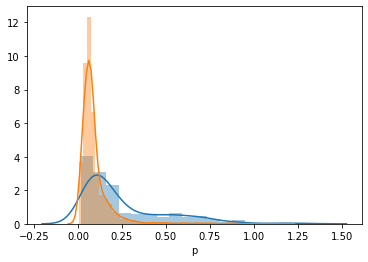

In [11]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3014991003823067, 'max_bin': 134, 'subsample': 0.8990859498726816, 'subsample_freq': 0.5274951186330312,
    'learning_rate': 0.3937162652059595, 'num_leaves': 5, 'feature_fraction': 0.8861294810479933, 'bagging_freq': 5,
    'min_child_samples': 28, 'lambda_l1': 6.037171725930821, 'lambda_l2': 0.0025254105473444784
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.15 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p)
sns.distplot(off_df[off_df.jobflag_2==0].p)

#### label 4

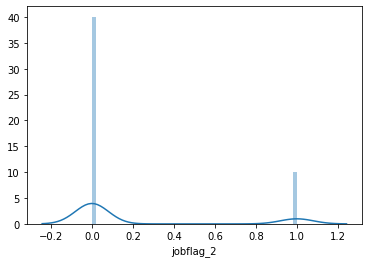

In [54]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
sns.distplot(train_df.jobflag_2)

In [47]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.91875	valid_1's tweedie: 2.00467
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.93945	valid_1's tweedie: 2.01051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 1.84328	valid_1's tweedie: 1.895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.84324	valid_1's tweedie: 1.90081
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.87795	valid_1's tweedie: 1.95369


[I 2020-08-19 15:59:18,711] Finished trial#0 with value: 1.0697791848941236 with parameters: {'tweedie_variance_power': 1.600089915512092, 'max_bin': 279, 'subsample': 0.6559945339862616, 'subsample_freq': 0.6325112768319816, 'learning_rate': 0.06866907727935392, 'num_leaves': 6, 'feature_fraction': 0.44407552825175023, 'bagging_freq': 4, 'min_child_samples': 61, 'lambda_l1': 0.02648129358138311, 'lambda_l2': 0.9228098558212354}. Best is trial#0 with value: 1.0697791848941236.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.46971	valid_1's tweedie: 1.53636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.4565	valid_1's tweedie: 1.51904
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.47589	valid_1's tweedie: 1.51604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.47841	valid_1's tweedie: 1.49906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.46732	valid_1's tweedie: 1.52267


[I 2020-08-19 15:59:26,751] Finished trial#1 with value: 0.8524579845248792 with parameters: {'tweedie_variance_power': 1.2299753068589563, 'max_bin': 293, 'subsample': 0.5099854931606935, 'subsample_freq': 0.8194713010785144, 'learning_rate': 0.16819677707124053, 'num_leaves': 9, 'feature_fraction': 0.5055065747887347, 'bagging_freq': 7, 'min_child_samples': 40, 'lambda_l1': 0.01830208715380742, 'lambda_l2': 0.00016785296294128784}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.59233	valid_1's tweedie: 1.66895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.56637	valid_1's tweedie: 1.63172
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.51486	valid_1's tweedie: 1.56363
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.52963	valid_1's tweedie: 1.57907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.43351	valid_1's tweedie: 1.58436


[I 2020-08-19 15:59:34,772] Finished trial#2 with value: 0.8918177183177995 with parameters: {'tweedie_variance_power': 1.5041367947776854, 'max_bin': 123, 'subsample': 0.7989167831486267, 'subsample_freq': 0.665446824346272, 'learning_rate': 0.3400577437714441, 'num_leaves': 7, 'feature_fraction': 0.8125214556054352, 'bagging_freq': 7, 'min_child_samples': 40, 'lambda_l1': 0.007893511657902749, 'lambda_l2': 0.02195956139290191}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.84485	valid_1's tweedie: 1.94975
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.8791	valid_1's tweedie: 1.94964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.82227	valid_1's tweedie: 1.83877
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.81323	valid_1's tweedie: 1.8541
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.8034	valid_1's tweedie: 1.8893


[I 2020-08-19 15:59:42,755] Finished trial#3 with value: 1.0416407714355054 with parameters: {'tweedie_variance_power': 1.5865701388708975, 'max_bin': 160, 'subsample': 0.5238738078259793, 'subsample_freq': 0.4483877853700213, 'learning_rate': 0.16897733587897795, 'num_leaves': 6, 'feature_fraction': 0.6069114303466593, 'bagging_freq': 1, 'min_child_samples': 48, 'lambda_l1': 0.0001738143338444797, 'lambda_l2': 0.00048264154631729096}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's tweedie: 2.11017	valid_1's tweedie: 2.23639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.22788	valid_1's tweedie: 2.32579
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's tweedie: 2.10684	valid_1's tweedie: 2.20376
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's tweedie: 2.10835	valid_1's tweedie: 2.18601
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	training's tweedie: 2.07871	valid_1's tweedie: 2.17538


[I 2020-08-19 15:59:50,818] Finished trial#4 with value: 1.2082660151132734 with parameters: {'tweedie_variance_power': 1.6402286898307097, 'max_bin': 110, 'subsample': 0.7909513876915165, 'subsample_freq': 0.6779314671598884, 'learning_rate': 0.059515447244853185, 'num_leaves': 5, 'feature_fraction': 0.7918262897193, 'bagging_freq': 3, 'min_child_samples': 97, 'lambda_l1': 0.1494651515192782, 'lambda_l2': 6.361080576953711}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.71151	valid_1's tweedie: 1.78148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.73901	valid_1's tweedie: 1.77857
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.62603	valid_1's tweedie: 1.65271
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.58749	valid_1's tweedie: 1.64485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.65029	valid_1's tweedie: 1.71371


[I 2020-08-19 15:59:58,807] Finished trial#5 with value: 0.9511234626264464 with parameters: {'tweedie_variance_power': 1.5385901021618007, 'max_bin': 206, 'subsample': 0.8973515270297477, 'subsample_freq': 0.7217140330439669, 'learning_rate': 0.21014416708244865, 'num_leaves': 5, 'feature_fraction': 0.8681166684380501, 'bagging_freq': 1, 'min_child_samples': 60, 'lambda_l1': 0.010934355754877181, 'lambda_l2': 0.12550098757066155}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 12.7975	valid_1's tweedie: 12.8611
Early stopping, best iteration is:
[314]	training's tweedie: 12.8075	valid_1's tweedie: 12.8577
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's tweedie: 12.8211	valid_1's tweedie: 12.8743
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's tweedie: 12.8148	valid_1's tweedie: 12.8644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 12.8389	valid_1's tweedie: 12.7929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	training's tweedie: 12.8322	valid_1's tweedie: 12.8307


[I 2020-08-19 16:00:06,855] Finished trial#6 with value: 6.5202514921333155 with parameters: {'tweedie_variance_power': 1.0160940175637714, 'max_bin': 118, 'subsample': 0.6328046370147313, 'subsample_freq': 0.7282913411204508, 'learning_rate': 0.08364458350029463, 'num_leaves': 6, 'feature_fraction': 0.7812266831147292, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.2570431460071185, 'lambda_l2': 0.10869657955520325}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.51694	valid_1's tweedie: 1.57876
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.52286	valid_1's tweedie: 1.56483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.51891	valid_1's tweedie: 1.55576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.51478	valid_1's tweedie: 1.53483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.51748	valid_1's tweedie: 1.55817


[I 2020-08-19 16:00:14,879] Finished trial#7 with value: 0.8693062843508023 with parameters: {'tweedie_variance_power': 1.2122573693605774, 'max_bin': 158, 'subsample': 0.6387786503744253, 'subsample_freq': 0.5181472936504408, 'learning_rate': 0.14017810116574497, 'num_leaves': 8, 'feature_fraction': 0.8010536291363177, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.16699498101682492, 'lambda_l2': 0.000467167843303247}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.46693	valid_1's tweedie: 1.55962
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.5304	valid_1's tweedie: 1.56293
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's tweedie: 1.44752	valid_1's tweedie: 1.47808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[192]	training's tweedie: 1.46682	valid_1's tweedie: 1.48198
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 1.46269	valid_1's tweedie: 1.51429


[I 2020-08-19 16:00:22,977] Finished trial#8 with value: 0.8507889715477717 with parameters: {'tweedie_variance_power': 1.4616572741379197, 'max_bin': 145, 'subsample': 0.6343837811878572, 'subsample_freq': 0.6495301622470209, 'learning_rate': 0.04683046747786626, 'num_leaves': 5, 'feature_fraction': 0.9843225687482132, 'bagging_freq': 6, 'min_child_samples': 60, 'lambda_l1': 3.7538595585093693, 'lambda_l2': 0.004253165192875187}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.89532	valid_1's tweedie: 1.97991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.95488	valid_1's tweedie: 1.99328
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	training's tweedie: 1.80116	valid_1's tweedie: 1.89063
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.83188	valid_1's tweedie: 1.89156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.81911	valid_1's tweedie: 1.90391


[I 2020-08-19 16:00:30,938] Finished trial#9 with value: 1.0604338554545714 with parameters: {'tweedie_variance_power': 1.596122381639389, 'max_bin': 194, 'subsample': 0.6707182096442121, 'subsample_freq': 0.8982591804094648, 'learning_rate': 0.14887532728090538, 'num_leaves': 4, 'feature_fraction': 0.4020528768899986, 'bagging_freq': 5, 'min_child_samples': 62, 'lambda_l1': 0.0013767888173660053, 'lambda_l2': 0.00018859833459665556}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 3.47257	valid_1's tweedie: 3.6124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 3.57115	valid_1's tweedie: 3.67023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 3.41807	valid_1's tweedie: 3.41757
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 3.06382	valid_1's tweedie: 3.29622
Early stopping, best iteration is:
[414]	training's tweedie: 3.10526	valid_1's tweedie: 3.27245
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's tweedie: 3.22964	valid_1's tweedie: 3.35624


[I 2020-08-19 16:00:39,172] Finished trial#10 with value: 1.8294402679319925 with parameters: {'tweedie_variance_power': 1.7637720562194381, 'max_bin': 56, 'subsample': 0.7609457961283077, 'subsample_freq': 0.5611381697944247, 'learning_rate': 0.031022744089479633, 'num_leaves': 4, 'feature_fraction': 0.9882498338261272, 'bagging_freq': 3, 'min_child_samples': 8, 'lambda_l1': 7.004684591964104, 'lambda_l2': 0.006264289861620885}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35857	valid_1's tweedie: 1.4262
Early stopping, best iteration is:
[564]	training's tweedie: 1.35305	valid_1's tweedie: 1.42484
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36737	valid_1's tweedie: 1.40711
Early stopping, best iteration is:
[533]	training's tweedie: 1.3651	valid_1's tweedie: 1.40698
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38404	valid_1's tweedie: 1.41454
Early stopping, best iteration is:
[333]	training's tweedie: 1.38404	valid_1's tweedie: 1.41454
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38095	valid_1's tweedie: 1.41349
Early stopping, best iteration is:
[367]	training's tweedie: 1.38097	valid_1's tweedie: 1.41347
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36278	valid_1's tweedie: 1.43342
Ear

[I 2020-08-19 16:00:47,641] Finished trial#11 with value: 0.794834289054108 with parameters: {'tweedie_variance_power': 1.296029701119492, 'max_bin': 295, 'subsample': 0.5001586369941206, 'subsample_freq': 0.857896083576887, 'learning_rate': 0.03975264832742246, 'num_leaves': 10, 'feature_fraction': 0.5800407241840084, 'bagging_freq': 6, 'min_child_samples': 19, 'lambda_l1': 9.354584478780701, 'lambda_l2': 0.002404802393099737}. Best is trial#11 with value: 0.794834289054108.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.31794	valid_1's tweedie: 1.41433
Early stopping, best iteration is:
[563]	training's tweedie: 1.31143	valid_1's tweedie: 1.41083
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32647	valid_1's tweedie: 1.38472
Early stopping, best iteration is:
[486]	training's tweedie: 1.32676	valid_1's tweedie: 1.38443
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32643	valid_1's tweedie: 1.39759
Early stopping, best iteration is:
[619]	training's tweedie: 1.31322	valid_1's tweedie: 1.39156
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32841	valid_1's tweedie: 1.38024
Early stopping, best iteration is:
[586]	training's tweedie: 1.32	valid_1's tweedie: 1.37962
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.31877	valid_1's tweedie: 1.41361
Earl

[I 2020-08-19 16:00:56,532] Finished trial#12 with value: 0.7832340309352894 with parameters: {'tweedie_variance_power': 1.3550453972213072, 'max_bin': 249, 'subsample': 0.44558834664799596, 'subsample_freq': 0.8007645551516496, 'learning_rate': 0.03518137046082547, 'num_leaves': 10, 'feature_fraction': 0.6198565706800311, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 9.158923232248503, 'lambda_l2': 0.0028594401194864463}. Best is trial#12 with value: 0.7832340309352894.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.32501	valid_1's tweedie: 1.41991
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.23305	valid_1's tweedie: 1.40497
Early stopping, best iteration is:
[335]	training's tweedie: 1.26849	valid_1's tweedie: 1.38408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.30907	valid_1's tweedie: 1.39249
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.30987	valid_1's tweedie: 1.36422
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	training's tweedie: 1.31796	valid_1's tweedie: 1.40611


[I 2020-08-19 16:01:05,224] Finished trial#13 with value: 0.7830027267096454 with parameters: {'tweedie_variance_power': 1.307306265460617, 'max_bin': 248, 'subsample': 0.4169537949950859, 'subsample_freq': 0.8849580019138057, 'learning_rate': 0.033677603225831486, 'num_leaves': 10, 'feature_fraction': 0.62055013736942, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 1.3270163527129084, 'lambda_l2': 0.0033622154524905845}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.31046	valid_1's tweedie: 1.41311
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's tweedie: 1.3199	valid_1's tweedie: 1.39321
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.29674	valid_1's tweedie: 1.38074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.30168	valid_1's tweedie: 1.36149
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.3189	valid_1's tweedie: 1.39466


[I 2020-08-19 16:01:13,680] Finished trial#14 with value: 0.783197899221016 with parameters: {'tweedie_variance_power': 1.3541961029794634, 'max_bin': 236, 'subsample': 0.4007425779934237, 'subsample_freq': 0.7998496681961945, 'learning_rate': 0.03316184159846841, 'num_leaves': 10, 'feature_fraction': 0.6571433367158777, 'bagging_freq': 4, 'min_child_samples': 7, 'lambda_l1': 1.2521091431678613, 'lambda_l2': 0.0018754632849619056}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.98713	valid_1's tweedie: 2.03201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[279]	training's tweedie: 1.92877	valid_1's tweedie: 2.0083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.99521	valid_1's tweedie: 2.02053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 1.94957	valid_1's tweedie: 2.00655
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's tweedie: 1.95482	valid_1's tweedie: 2.01995


[I 2020-08-19 16:01:21,911] Finished trial#15 with value: 1.0960755840721175 with parameters: {'tweedie_variance_power': 1.1350601980496402, 'max_bin': 247, 'subsample': 0.403217300130561, 'subsample_freq': 0.8963512207815281, 'learning_rate': 0.09272407215245741, 'num_leaves': 9, 'feature_fraction': 0.6790847104592757, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 1.4327127726943112, 'lambda_l2': 0.017734294372101538}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.47825	valid_1's tweedie: 1.51737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	training's tweedie: 1.46934	valid_1's tweedie: 1.4776
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.45473	valid_1's tweedie: 1.48461
Early stopping, best iteration is:
[524]	training's tweedie: 1.45327	valid_1's tweedie: 1.48197
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.46282	valid_1's tweedie: 1.47876
Early stopping, best iteration is:
[360]	training's tweedie: 1.4698	valid_1's tweedie: 1.472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's tweedie: 1.4761	valid_1's tweedie: 1.48966


[I 2020-08-19 16:01:30,012] Finished trial#16 with value: 0.8419486699073586 with parameters: {'tweedie_variance_power': 1.3810371318442003, 'max_bin': 234, 'subsample': 0.4104270947333961, 'subsample_freq': 0.7881649264471264, 'learning_rate': 0.030109197495732345, 'num_leaves': 9, 'feature_fraction': 0.7059939065057134, 'bagging_freq': 4, 'min_child_samples': 81, 'lambda_l1': 0.9217939207568541, 'lambda_l2': 0.0013051353686811635}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 3.17738	valid_1's tweedie: 3.23316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's tweedie: 3.17534	valid_1's tweedie: 3.21991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 3.1786	valid_1's tweedie: 3.22436
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 3.17499	valid_1's tweedie: 3.20573
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[283]	training's tweedie: 3.15116	valid_1's tweedie: 3.2228


[I 2020-08-19 16:01:38,314] Finished trial#17 with value: 1.695893455417525 with parameters: {'tweedie_variance_power': 1.0727981106537192, 'max_bin': 223, 'subsample': 0.4598906962014221, 'subsample_freq': 0.8486504318220877, 'learning_rate': 0.0499752698102563, 'num_leaves': 10, 'feature_fraction': 0.5261746620779101, 'bagging_freq': 2, 'min_child_samples': 21, 'lambda_l1': 0.6693047292745973, 'lambda_l2': 0.1045252621271115}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.37294	valid_1's tweedie: 1.44843
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.32178	valid_1's tweedie: 1.41473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.38848	valid_1's tweedie: 1.41539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.38111	valid_1's tweedie: 1.40094
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.37188	valid_1's tweedie: 1.42645


[I 2020-08-19 16:01:46,402] Finished trial#18 with value: 0.8004935443179645 with parameters: {'tweedie_variance_power': 1.2888185546691433, 'max_bin': 266, 'subsample': 0.5636491684809073, 'subsample_freq': 0.7558828316355346, 'learning_rate': 0.48374867766596175, 'num_leaves': 8, 'feature_fraction': 0.6917130213249956, 'bagging_freq': 5, 'min_child_samples': 7, 'lambda_l1': 2.5297711081543603, 'lambda_l2': 0.0007753537490300852}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.44507	valid_1's tweedie: 1.53443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.47799	valid_1's tweedie: 1.51646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.42411	valid_1's tweedie: 1.4518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.41117	valid_1's tweedie: 1.45833
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.40698	valid_1's tweedie: 1.46911


[I 2020-08-19 16:01:54,404] Finished trial#19 with value: 0.8320602433986359 with parameters: {'tweedie_variance_power': 1.4483497873227875, 'max_bin': 193, 'subsample': 0.564008309966166, 'subsample_freq': 0.8865360954082061, 'learning_rate': 0.10589576044128032, 'num_leaves': 8, 'feature_fraction': 0.547703031883796, 'bagging_freq': 4, 'min_child_samples': 30, 'lambda_l1': 0.07861173854034371, 'lambda_l2': 0.008801536722812775}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.85712	valid_1's tweedie: 1.91992
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's tweedie: 1.8351	valid_1's tweedie: 1.90712
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.82988	valid_1's tweedie: 1.91762
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.84027	valid_1's tweedie: 1.88751
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.85527	valid_1's tweedie: 1.91789


[I 2020-08-19 16:02:02,825] Finished trial#20 with value: 1.0415014172393582 with parameters: {'tweedie_variance_power': 1.1467062057513304, 'max_bin': 219, 'subsample': 0.4005732493076946, 'subsample_freq': 0.8372000418978686, 'learning_rate': 0.06434275691661087, 'num_leaves': 10, 'feature_fraction': 0.6522769541088811, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.46028975822702617, 'lambda_l2': 0.053090632940987426}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.33182	valid_1's tweedie: 1.42518
Early stopping, best iteration is:
[553]	training's tweedie: 1.32579	valid_1's tweedie: 1.42319
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.34152	valid_1's tweedie: 1.39665
[1000]	training's tweedie: 1.30626	valid_1's tweedie: 1.38633
Early stopping, best iteration is:
[877]	training's tweedie: 1.3075	valid_1's tweedie: 1.38629
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.34026	valid_1's tweedie: 1.40223
Early stopping, best iteration is:
[616]	training's tweedie: 1.32825	valid_1's tweedie: 1.39921
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.33998	valid_1's tweedie: 1.39582
Early stopping, best iteration is:
[499]	training's tweedie: 1.34011	valid_1's tweedie: 1.39578
Training until validation scores don't improve for 200 rounds
[

[I 2020-08-19 16:02:11,636] Finished trial#21 with value: 0.7878276979608007 with parameters: {'tweedie_variance_power': 1.3785610081292399, 'max_bin': 253, 'subsample': 0.4557219372978438, 'subsample_freq': 0.8057965968499232, 'learning_rate': 0.03500473557743897, 'num_leaves': 10, 'feature_fraction': 0.6219769811950762, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 9.19276969280952, 'lambda_l2': 0.0022560463875232863}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.31837	valid_1's tweedie: 1.40857
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.24123	valid_1's tweedie: 1.38831
Early stopping, best iteration is:
[416]	training's tweedie: 1.2557	valid_1's tweedie: 1.38061
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.30519	valid_1's tweedie: 1.39218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.3067	valid_1's tweedie: 1.36163
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.31863	valid_1's tweedie: 1.40657


[I 2020-08-19 16:02:20,269] Finished trial#22 with value: 0.7824724854925718 with parameters: {'tweedie_variance_power': 1.3371473626599455, 'max_bin': 264, 'subsample': 0.44376415912288547, 'subsample_freq': 0.7678820656910754, 'learning_rate': 0.04081996372588655, 'num_leaves': 9, 'feature_fraction': 0.7339942482434498, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 2.8501006852503434, 'lambda_l2': 0.009871853455990962}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's tweedie: 1.36071	valid_1's tweedie: 1.42726
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.30415	valid_1's tweedie: 1.39462
Early stopping, best iteration is:
[329]	training's tweedie: 1.3251	valid_1's tweedie: 1.38718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.35094	valid_1's tweedie: 1.39419
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[238]	training's tweedie: 1.3388	valid_1's tweedie: 1.38535
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's tweedie: 1.34012	valid_1's tweedie: 1.41227


[I 2020-08-19 16:02:28,540] Finished trial#23 with value: 0.7889876354487277 with parameters: {'tweedie_variance_power': 1.3078104278483433, 'max_bin': 277, 'subsample': 0.40170810246291355, 'subsample_freq': 0.7531353409318584, 'learning_rate': 0.04669030647187475, 'num_leaves': 9, 'feature_fraction': 0.7211138644245091, 'bagging_freq': 4, 'min_child_samples': 29, 'lambda_l1': 2.5928901981845787, 'lambda_l2': 0.012103766781694834}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.52764	valid_1's tweedie: 1.58711
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.4524	valid_1's tweedie: 1.57807
Early stopping, best iteration is:
[375]	training's tweedie: 1.47308	valid_1's tweedie: 1.56557
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.51821	valid_1's tweedie: 1.56102
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's tweedie: 1.5062	valid_1's tweedie: 1.55307
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's tweedie: 1.50279	valid_1's tweedie: 1.56911


[I 2020-08-19 16:02:37,005] Finished trial#24 with value: 0.8692215183222481 with parameters: {'tweedie_variance_power': 1.2094053826882885, 'max_bin': 264, 'subsample': 0.4446473054220998, 'subsample_freq': 0.7734995979916515, 'learning_rate': 0.030140179772263406, 'num_leaves': 9, 'feature_fraction': 0.8838445999838688, 'bagging_freq': 6, 'min_child_samples': 15, 'lambda_l1': 0.07249681507389245, 'lambda_l2': 0.042542461655082714}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.42255	valid_1's tweedie: 1.51076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 1.43732	valid_1's tweedie: 1.49656
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	training's tweedie: 1.37327	valid_1's tweedie: 1.46652
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.39729	valid_1's tweedie: 1.44349
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.40589	valid_1's tweedie: 1.4737


[I 2020-08-19 16:02:45,243] Finished trial#25 with value: 0.8308823314377305 with parameters: {'tweedie_variance_power': 1.4457187935745142, 'max_bin': 234, 'subsample': 0.4844772720576891, 'subsample_freq': 0.7063351241881944, 'learning_rate': 0.04077119147875642, 'num_leaves': 10, 'feature_fraction': 0.745915206087488, 'bagging_freq': 3, 'min_child_samples': 28, 'lambda_l1': 1.5939154916337155, 'lambda_l2': 0.006462638960260632}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.34908	valid_1's tweedie: 1.4124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.34192	valid_1's tweedie: 1.39834
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.28915	valid_1's tweedie: 1.38296
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.28594	valid_1's tweedie: 1.36531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.32417	valid_1's tweedie: 1.39221


[I 2020-08-19 16:02:53,623] Finished trial#26 with value: 0.7829756399517607 with parameters: {'tweedie_variance_power': 1.3314358800979038, 'max_bin': 291, 'subsample': 0.5513199712210923, 'subsample_freq': 0.8722726449690849, 'learning_rate': 0.058634701656886744, 'num_leaves': 8, 'feature_fraction': 0.6457613717501387, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.39244769976129534, 'lambda_l2': 0.0013414971402767174}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.42527	valid_1's tweedie: 1.46768
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.43107	valid_1's tweedie: 1.48091
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38339	valid_1's tweedie: 1.45117
[1000]	training's tweedie: 1.34582	valid_1's tweedie: 1.45386
Early stopping, best iteration is:
[897]	training's tweedie: 1.3515	valid_1's tweedie: 1.44583
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[197]	training's tweedie: 1.42892	valid_1's tweedie: 1.44471
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.37235	valid_1's tweedie: 1.45817
Early stopping, best iteration is:
[450]	training's tweedie: 1.38088	valid_1's tweedie: 1.45394


[I 2020-08-19 16:03:01,938] Finished trial#27 with value: 0.8268847496370608 with parameters: {'tweedie_variance_power': 1.2850030250039561, 'max_bin': 298, 'subsample': 0.5663932075096835, 'subsample_freq': 0.8732190164123685, 'learning_rate': 0.05692264709039681, 'num_leaves': 7, 'feature_fraction': 0.49090683401631807, 'bagging_freq': 6, 'min_child_samples': 76, 'lambda_l1': 0.5547248317437333, 'lambda_l2': 0.38227388583354743}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.97242	valid_1's tweedie: 2.03571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.96703	valid_1's tweedie: 2.02108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's tweedie: 1.94933	valid_1's tweedie: 2.01589
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.93673	valid_1's tweedie: 2.003
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.95967	valid_1's tweedie: 2.01927


[I 2020-08-19 16:03:10,280] Finished trial#28 with value: 1.095470108741885 with parameters: {'tweedie_variance_power': 1.1345085068091287, 'max_bin': 300, 'subsample': 0.5990007690886892, 'subsample_freq': 0.5969345248496245, 'learning_rate': 0.0746936079973183, 'num_leaves': 8, 'feature_fraction': 0.5697488239815722, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.37268707323501404, 'lambda_l2': 0.0003179504534692502}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.37097	valid_1's tweedie: 1.45559
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.2827	valid_1's tweedie: 1.43072
Early stopping, best iteration is:
[449]	training's tweedie: 1.29005	valid_1's tweedie: 1.42576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.33857	valid_1's tweedie: 1.40774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[190]	training's tweedie: 1.34614	valid_1's tweedie: 1.40303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's tweedie: 1.31618	valid_1's tweedie: 1.42934


[I 2020-08-19 16:03:18,665] Finished trial#29 with value: 0.8001709170974038 with parameters: {'tweedie_variance_power': 1.4082582664197463, 'max_bin': 269, 'subsample': 0.5329267818521259, 'subsample_freq': 0.8998489895665605, 'learning_rate': 0.054010452098542175, 'num_leaves': 8, 'feature_fraction': 0.7447036227873912, 'bagging_freq': 5, 'min_child_samples': 25, 'lambda_l1': 4.252340849749159, 'lambda_l2': 0.00010214377011374167}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.43415	valid_1's tweedie: 1.4934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's tweedie: 1.38865	valid_1's tweedie: 1.47371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's tweedie: 1.38102	valid_1's tweedie: 1.46147
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 1.3978	valid_1's tweedie: 1.4518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.40127	valid_1's tweedie: 1.47227


[I 2020-08-19 16:03:26,829] Finished trial#30 with value: 0.8226088763473909 with parameters: {'tweedie_variance_power': 1.2466523946457961, 'max_bin': 283, 'subsample': 0.6817579755132137, 'subsample_freq': 0.834521574908831, 'learning_rate': 0.07289164320824625, 'num_leaves': 7, 'feature_fraction': 0.45637173082684473, 'bagging_freq': 6, 'min_child_samples': 14, 'lambda_l1': 0.22419046060841347, 'lambda_l2': 0.0007659507659427901}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.33016	valid_1's tweedie: 1.40982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's tweedie: 1.31848	valid_1's tweedie: 1.3953
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.31332	valid_1's tweedie: 1.38091
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.29974	valid_1's tweedie: 1.36103
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.32357	valid_1's tweedie: 1.39488


[I 2020-08-19 16:03:35,256] Finished trial#31 with value: 0.7839270962163964 with parameters: {'tweedie_variance_power': 1.3270265134733097, 'max_bin': 239, 'subsample': 0.47196762619705324, 'subsample_freq': 0.8701628302188167, 'learning_rate': 0.03890248066066794, 'num_leaves': 9, 'feature_fraction': 0.6559157857860747, 'bagging_freq': 4, 'min_child_samples': 7, 'lambda_l1': 1.1050422358664522, 'lambda_l2': 0.001536891391054437}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 1.35722	valid_1's tweedie: 1.46558
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.39509	valid_1's tweedie: 1.45447
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's tweedie: 1.32669	valid_1's tweedie: 1.41718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's tweedie: 1.31336	valid_1's tweedie: 1.39416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.34197	valid_1's tweedie: 1.42907


[I 2020-08-19 16:03:43,675] Finished trial#32 with value: 0.806625733531771 with parameters: {'tweedie_variance_power': 1.410923016178421, 'max_bin': 279, 'subsample': 0.42974267602305893, 'subsample_freq': 0.8239736135819671, 'learning_rate': 0.030765893111914473, 'num_leaves': 9, 'feature_fraction': 0.6566914824916127, 'bagging_freq': 4, 'min_child_samples': 8, 'lambda_l1': 0.052162535057098336, 'lambda_l2': 0.0010892409307417684}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.32564	valid_1's tweedie: 1.41363
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.32255	valid_1's tweedie: 1.38754
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's tweedie: 1.31579	valid_1's tweedie: 1.38074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's tweedie: 1.28562	valid_1's tweedie: 1.36951
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's tweedie: 1.27779	valid_1's tweedie: 1.39256


[I 2020-08-19 16:03:51,943] Finished trial#33 with value: 0.7846424002600219 with parameters: {'tweedie_variance_power': 1.3510093937629515, 'max_bin': 260, 'subsample': 0.4957301684749706, 'subsample_freq': 0.7772696697285516, 'learning_rate': 0.044616229824869465, 'num_leaves': 9, 'feature_fraction': 0.5973987663736211, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 2.173412929615262, 'lambda_l2': 0.0033416369771204248}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.375	valid_1's tweedie: 1.46826
Early stopping, best iteration is:
[580]	training's tweedie: 1.36842	valid_1's tweedie: 1.4681
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38262	valid_1's tweedie: 1.44722
Early stopping, best iteration is:
[680]	training's tweedie: 1.36767	valid_1's tweedie: 1.44394
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.37833	valid_1's tweedie: 1.4556
Early stopping, best iteration is:
[355]	training's tweedie: 1.39375	valid_1's tweedie: 1.44984
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's tweedie: 1.40559	valid_1's tweedie: 1.43981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.4145	valid_1's tweedie: 1.46722


[I 2020-08-19 16:04:00,572] Finished trial#34 with value: 0.8138955776275651 with parameters: {'tweedie_variance_power': 1.2579017358812217, 'max_bin': 286, 'subsample': 0.4271834223679485, 'subsample_freq': 0.8196377057679509, 'learning_rate': 0.03500290378957829, 'num_leaves': 10, 'feature_fraction': 0.8431014431051722, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 3.9854960156731316, 'lambda_l2': 0.023687160643201553}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.61961	valid_1's tweedie: 1.70451
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.66284	valid_1's tweedie: 1.70161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.58306	valid_1's tweedie: 1.62044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.59084	valid_1's tweedie: 1.62784
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.61567	valid_1's tweedie: 1.65704


[I 2020-08-19 16:04:08,570] Finished trial#35 with value: 0.9220685522579353 with parameters: {'tweedie_variance_power': 1.522413764887805, 'max_bin': 209, 'subsample': 0.5330049977936429, 'subsample_freq': 0.7022380014569106, 'learning_rate': 0.06352815577421148, 'num_leaves': 8, 'feature_fraction': 0.7564159925340791, 'bagging_freq': 5, 'min_child_samples': 40, 'lambda_l1': 0.030093989216461045, 'lambda_l2': 0.011822375885931678}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's tweedie: 1.65737	valid_1's tweedie: 1.71301
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.60765	valid_1's tweedie: 1.69005
Early stopping, best iteration is:
[532]	training's tweedie: 1.60452	valid_1's tweedie: 1.68798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's tweedie: 1.65136	valid_1's tweedie: 1.68604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's tweedie: 1.65028	valid_1's tweedie: 1.68298
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's tweedie: 1.64461	valid_1's tweedie: 1.69764


[I 2020-08-19 16:04:16,879] Finished trial#36 with value: 0.9341039544887353 with parameters: {'tweedie_variance_power': 1.1792695128085116, 'max_bin': 190, 'subsample': 0.6026015331834551, 'subsample_freq': 0.7454987378873458, 'learning_rate': 0.036921380032906626, 'num_leaves': 9, 'feature_fraction': 0.6362418760442304, 'bagging_freq': 7, 'min_child_samples': 35, 'lambda_l1': 0.9887203216816187, 'lambda_l2': 0.00033029474362652783}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.3397	valid_1's tweedie: 1.41605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 1.32754	valid_1's tweedie: 1.39872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	training's tweedie: 1.29242	valid_1's tweedie: 1.37544
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.31639	valid_1's tweedie: 1.35719
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 1.31303	valid_1's tweedie: 1.38709


[I 2020-08-19 16:04:25,225] Finished trial#37 with value: 0.781984311880186 with parameters: {'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343, 'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528}. Best is trial#37 with value: 0.781984311880186.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.49612	valid_1's tweedie: 1.61288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.54571	valid_1's tweedie: 1.59498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.4903	valid_1's tweedie: 1.5378
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.50693	valid_1's tweedie: 1.54977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.45639	valid_1's tweedie: 1.57137


[I 2020-08-19 16:04:33,278] Finished trial#38 with value: 0.879651509837882 with parameters: {'tweedie_variance_power': 1.4902876397486085, 'max_bin': 220, 'subsample': 0.5255747366312318, 'subsample_freq': 0.8573352964351831, 'learning_rate': 0.2345563925129521, 'num_leaves': 6, 'feature_fraction': 0.7043131184366662, 'bagging_freq': 2, 'min_child_samples': 17, 'lambda_l1': 0.13196756946815152, 'lambda_l2': 0.00497946954947281}. Best is trial#37 with value: 0.781984311880186.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.40036	valid_1's tweedie: 1.46896
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.41324	valid_1's tweedie: 1.46418
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.38485	valid_1's tweedie: 1.43192
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.40531	valid_1's tweedie: 1.42308
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's tweedie: 1.37942	valid_1's tweedie: 1.45426


[I 2020-08-19 16:04:41,395] Finished trial#39 with value: 0.8134573262038269 with parameters: {'tweedie_variance_power': 1.2656995002665559, 'max_bin': 256, 'subsample': 0.4857410009737766, 'subsample_freq': 0.40276131425795714, 'learning_rate': 0.08554226135600441, 'num_leaves': 7, 'feature_fraction': 0.9134947421653783, 'bagging_freq': 2, 'min_child_samples': 48, 'lambda_l1': 0.34822582270111874, 'lambda_l2': 0.028224837600672792}. Best is trial#37 with value: 0.781984311880186.


In [48]:
print(study.best_value)
print(study.best_params)

0.781984311880186
{'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343, 'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528}


In [49]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,

    'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343,
    'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2,
    'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.33529	valid_1's tweedie: 1.41667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.32385	valid_1's tweedie: 1.39597
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	training's tweedie: 1.29464	valid_1's tweedie: 1.38159
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's tweedie: 1.30942	valid_1's tweedie: 1.36959
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 1.32677	valid_1's tweedie: 1.39075

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
                
T

[34]	training's tweedie: 2.74451	valid_1's tweedie: 2.88893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 2.76285	valid_1's tweedie: 2.73622
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 2.75799	valid_1's tweedie: 2.80687

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 2.78409	valid_1's tweedie: 2.81246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 2.77878	valid_1's tweedie: 2.92286
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.80744	valid_1's tweedie: 2.74806
Training until validation scores don't improve for 200 round

[64]	training's tweedie: 2.79701	valid_1's tweedie: 2.79213

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 2.82882	valid_1's tweedie: 2.86265
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 2.82326	valid_1's tweedie: 2.86765
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 2.8149	valid_1's tweedie: 2.92014
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 2.83057	valid_1's tweedie: 2.83013
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 2.82813	valid_1's tweedie: 2.76852

                
                Train Null Importance   29


[50]	training's tweedie: 2.82844	valid_1's tweedie: 2.91035
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 2.81848	valid_1's tweedie: 3.00567
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.85597	valid_1's tweedie: 2.80237

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.77516	valid_1's tweedie: 2.80507
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 2.7507	valid_1's tweedie: 2.97967
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 2.79905	valid_1's tweedie: 2.68905
Training until validation scores don't improve for 200 rounds

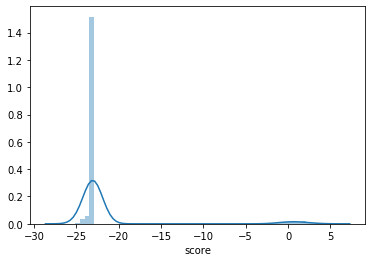

In [50]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [52]:
feature = ['softwar', 'code', 'client', 'machinelearn', 'model', 'data', 'engin', 'sale', 'email', 'use', 'market', 'algorithm', 'busi', 
           'test', 'manag', 'analyt', 'consult', 'complianc', 'improv', 'defin', 'dynam', 'detail', 'member', 'problem', 'sell', 'tool',
           'scope', 'product', 'hardwar', 'prospect', 'collabor', 'relat', 'transform', 'specif', 'appli', 'perform', 'new', 'servic', 
           'analysi', 'applic', 'engag', 'help', 'educ', 'map', 'event', 'term', 'referr', 'non', 'creat', 'propos', 'extern',
           'implement', 'assist', 'log', 'result', 'team', 'throughout', 'train', 'architectur', 'direct', 'system', 'secur', 'work',
           'issu', 'assess', 'profession', 'integr', 'build', 'custom', 'wide', 'project', 'design', 'meet', 'document', 'exist', 'independ',
           'research', 'develop', 'qualifi', 'pre', 'stream', 'ensur', 'optim', 'provid', 'facilit', 'account', 'relationship', 'technic',
           'deploy', 'stakehold', 'review', 'devop', 'intern', 'board', 'demonstr', 'process', 'organ', 'advis', 'abil', 'report', 'qualiti',
           'techniqu', 'follow', 'understand', 'troubleshoot', 'interfac', 'achiev', 'program', 'polici', 'identifi', 'instal', 'support',
           'agil', 'inform', 'upgrad', 'base', 'best', 'platform', 'deliv', 'effect', 'contract', 'mentor', 'vendor', 'partner',
           'leadership', 'go', 'autom', 'network', 'benefit', 'valid', 'must', 'infrastructur', 'particip', 'risk', 'practic', 'recommend',
           'payrol', 'regulatori', 'multipl', 'skill', 'standard', 'function', 'concept', 'control', 'within', 'oper', 'user', 'order',
           'requir', 'demand', 'potenti', 'coordin', 'drive', 'determin', 'schedul', 'lead', 'resolut', 'leverag', 'compani', 'time',
           'across', 'learn', 'maintain', 'execut', 'need', 'effici', 'machin', 'sourc', 'activ', 'innov', 'complex', 'request', 'insight',
           'prepar', 'continu', 'materi', 'write', 'strategi', 'solut', 'initi', 'opportun', 'limit', 'state', 'plan', 'person', 'assign', 
           'set', 'addit', 'featur', 'predict', 'architect', 'monitor', 'analyz', 'larg', 'technolog', 'field', 'part', 'solv', 'present',
           'challeng', 'complet', 'can', 'approach', 'establish', 'may', 'cloud', 'knowledg', 'prototyp', 'translat', 'site', 'high', 
           'deliveri', 'experi', 'evalu', 'commun', 'level', 'close']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.76492	valid_1's tweedie: 1.82676
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.78732	valid_1's tweedie: 1.8168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.7723	valid_1's tweedie: 1.81607
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.78335	valid_1's tweedie: 1.78685
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.79119	valid_1's tweedie: 1.81838


[I 2020-08-19 16:16:14,508] Finished trial#0 with value: 0.9979236385076803 with parameters: {'tweedie_variance_power': 1.1617044051785366, 'max_bin': 259, 'subsample': 0.41165993167978393, 'subsample_freq': 0.6367915523588058, 'learning_rate': 0.4812999855649039, 'num_leaves': 10, 'feature_fraction': 0.7942410842358418, 'bagging_freq': 1, 'min_child_samples': 25, 'lambda_l1': 0.00037802659912313587, 'lambda_l2': 0.005299361678712145}. Best is trial#0 with value: 0.9979236385076803.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.75971	valid_1's tweedie: 1.82246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.79944	valid_1's tweedie: 1.81021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.69473	valid_1's tweedie: 1.71836
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.69068	valid_1's tweedie: 1.74329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.69745	valid_1's tweedie: 1.75533


[I 2020-08-19 16:16:15,306] Finished trial#1 with value: 0.9782720313985618 with parameters: {'tweedie_variance_power': 1.5558563621835062, 'max_bin': 84, 'subsample': 0.8197363361042052, 'subsample_freq': 0.46000033004691065, 'learning_rate': 0.18278826076583726, 'num_leaves': 4, 'feature_fraction': 0.575343761255131, 'bagging_freq': 7, 'min_child_samples': 80, 'lambda_l1': 0.0014689168885453731, 'lambda_l2': 1.909776026233593}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 2.1144	valid_1's tweedie: 2.30463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 2.17562	valid_1's tweedie: 2.36041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's tweedie: 2.04938	valid_1's tweedie: 2.18254
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's tweedie: 2.14754	valid_1's tweedie: 2.21515
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 2.13101	valid_1's tweedie: 2.24634


[I 2020-08-19 16:16:16,212] Finished trial#2 with value: 1.2254159496521282 with parameters: {'tweedie_variance_power': 1.649771814142491, 'max_bin': 105, 'subsample': 0.8664835370404157, 'subsample_freq': 0.7655496809782376, 'learning_rate': 0.09687247114383035, 'num_leaves': 7, 'feature_fraction': 0.7326786805071699, 'bagging_freq': 6, 'min_child_samples': 100, 'lambda_l1': 0.007865600476091509, 'lambda_l2': 6.769971651977358}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.18907	valid_1's tweedie: 2.34664
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.25421	valid_1's tweedie: 2.35895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 2.06557	valid_1's tweedie: 2.21506
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's tweedie: 2.08466	valid_1's tweedie: 2.24944
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 2.10746	valid_1's tweedie: 2.26412


[I 2020-08-19 16:16:17,212] Finished trial#3 with value: 1.2326372440774018 with parameters: {'tweedie_variance_power': 1.659437531012323, 'max_bin': 78, 'subsample': 0.8415161968700824, 'subsample_freq': 0.743302662641862, 'learning_rate': 0.07471256199714939, 'num_leaves': 10, 'feature_fraction': 0.5217352959836906, 'bagging_freq': 5, 'min_child_samples': 35, 'lambda_l1': 1.890452193089933, 'lambda_l2': 6.747324615355207}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.91658	valid_1's tweedie: 2.03246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.95415	valid_1's tweedie: 2.03334
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.8098	valid_1's tweedie: 1.87661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.8033	valid_1's tweedie: 1.91248
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.78254	valid_1's tweedie: 1.8932


[I 2020-08-19 16:16:18,204] Finished trial#4 with value: 1.0645405533850039 with parameters: {'tweedie_variance_power': 1.6001620551002897, 'max_bin': 252, 'subsample': 0.8951730163091307, 'subsample_freq': 0.524655522882001, 'learning_rate': 0.10432716867406756, 'num_leaves': 10, 'feature_fraction': 0.9023776954872033, 'bagging_freq': 3, 'min_child_samples': 35, 'lambda_l1': 0.07892181665832126, 'lambda_l2': 0.004354070499202092}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 3.39219	valid_1's tweedie: 3.54571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 3.37068	valid_1's tweedie: 3.51313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 3.27319	valid_1's tweedie: 3.33233
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 3.30037	valid_1's tweedie: 3.29631
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 3.29339	valid_1's tweedie: 3.32316


[I 2020-08-19 16:16:19,117] Finished trial#5 with value: 1.8001763201099101 with parameters: {'tweedie_variance_power': 1.7599747991647288, 'max_bin': 105, 'subsample': 0.4723431518571584, 'subsample_freq': 0.6607511230559956, 'learning_rate': 0.039653497207117104, 'num_leaves': 5, 'feature_fraction': 0.6379591399720339, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.007111274119042518, 'lambda_l2': 0.009065758732037493}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 2.13334	valid_1's tweedie: 2.17825
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 2.11092	valid_1's tweedie: 2.15887
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 2.13284	valid_1's tweedie: 2.17577
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 2.1134	valid_1's tweedie: 2.16202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 2.14635	valid_1's tweedie: 2.17629


[I 2020-08-19 16:16:20,026] Finished trial#6 with value: 1.1721228203289593 with parameters: {'tweedie_variance_power': 1.12137070412158, 'max_bin': 253, 'subsample': 0.479076905400295, 'subsample_freq': 0.6459035090600468, 'learning_rate': 0.34278649376726883, 'num_leaves': 5, 'feature_fraction': 0.7051134854592689, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 0.001806505371317161, 'lambda_l2': 4.647329084280231}. Best is trial#1 with value: 0.9782720313985618.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.3682	valid_1's tweedie: 1.43128
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's tweedie: 1.38163	valid_1's tweedie: 1.42697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's tweedie: 1.32963	valid_1's tweedie: 1.38624
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.34566	valid_1's tweedie: 1.38073
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.34981	valid_1's tweedie: 1.40572


[I 2020-08-19 16:16:21,093] Finished trial#7 with value: 0.7938530405851919 with parameters: {'tweedie_variance_power': 1.3073898488263709, 'max_bin': 58, 'subsample': 0.8391808861617073, 'subsample_freq': 0.5235732317435453, 'learning_rate': 0.04311215744197555, 'num_leaves': 10, 'feature_fraction': 0.9019029455303103, 'bagging_freq': 3, 'min_child_samples': 63, 'lambda_l1': 0.41564523293222244, 'lambda_l2': 0.10792554698264413}. Best is trial#7 with value: 0.7938530405851919.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.78581	valid_1's tweedie: 1.85589
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.78066	valid_1's tweedie: 1.84369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.79443	valid_1's tweedie: 1.83723
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.8006	valid_1's tweedie: 1.83043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.76751	valid_1's tweedie: 1.84064


[I 2020-08-19 16:16:22,070] Finished trial#8 with value: 1.006253913795197 with parameters: {'tweedie_variance_power': 1.1555187630361596, 'max_bin': 226, 'subsample': 0.8459037607971852, 'subsample_freq': 0.8485505583048529, 'learning_rate': 0.21476779358845807, 'num_leaves': 10, 'feature_fraction': 0.6687183620226052, 'bagging_freq': 1, 'min_child_samples': 42, 'lambda_l1': 2.002307948792026, 'lambda_l2': 0.016677469044815624}. Best is trial#7 with value: 0.7938530405851919.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 3.072	valid_1's tweedie: 3.19371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 3.1507	valid_1's tweedie: 3.19689
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 2.91589	valid_1's tweedie: 2.98683
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 2.93473	valid_1's tweedie: 3.03012
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 2.95494	valid_1's tweedie: 3.0777


[I 2020-08-19 16:16:22,962] Finished trial#9 with value: 1.6415027335044439 with parameters: {'tweedie_variance_power': 1.7421122952737709, 'max_bin': 226, 'subsample': 0.7712386784988556, 'subsample_freq': 0.44539967740435843, 'learning_rate': 0.07034843414127182, 'num_leaves': 7, 'feature_fraction': 0.5142971411030215, 'bagging_freq': 4, 'min_child_samples': 85, 'lambda_l1': 0.10160753688037205, 'lambda_l2': 0.00018533272325386939}. Best is trial#7 with value: 0.7938530405851919.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35241	valid_1's tweedie: 1.42304
Early stopping, best iteration is:
[482]	training's tweedie: 1.35349	valid_1's tweedie: 1.42199
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35865	valid_1's tweedie: 1.40882
[1000]	training's tweedie: 1.33831	valid_1's tweedie: 1.4036
Early stopping, best iteration is:
[904]	training's tweedie: 1.34125	valid_1's tweedie: 1.40278
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.359	valid_1's tweedie: 1.391
[1000]	training's tweedie: 1.33601	valid_1's tweedie: 1.38438
Did not meet early stopping. Best iteration is:
[1400]	training's tweedie: 1.32345	valid_1's tweedie: 1.38221
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35863	valid_1's tweedie: 1.38768
Early stopping, best iteration is:
[660]	training's tweedie: 1.34957	valid_1's tweedie:

[I 2020-08-19 16:16:24,776] Finished trial#10 with value: 0.7891427043275876 with parameters: {'tweedie_variance_power': 1.3572492826220748, 'max_bin': 169, 'subsample': 0.6874225607452877, 'subsample_freq': 0.5369168449326642, 'learning_rate': 0.0353671206084155, 'num_leaves': 8, 'feature_fraction': 0.9508830019260512, 'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 8.281467382972142, 'lambda_l2': 0.1428656656583413}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36043	valid_1's tweedie: 1.43464
Early stopping, best iteration is:
[476]	training's tweedie: 1.36182	valid_1's tweedie: 1.43339
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36822	valid_1's tweedie: 1.41461
Early stopping, best iteration is:
[768]	training's tweedie: 1.35558	valid_1's tweedie: 1.4118
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36909	valid_1's tweedie: 1.3976
[1000]	training's tweedie: 1.34464	valid_1's tweedie: 1.39224
Did not meet early stopping. Best iteration is:
[1400]	training's tweedie: 1.33182	valid_1's tweedie: 1.39116
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36818	valid_1's tweedie: 1.39406
Early stopping, best iteration is:
[647]	training's tweedie: 1.35914	valid_1's tweedie: 1.39314
Training until validation scores don't improve for

[I 2020-08-19 16:16:26,566] Finished trial#11 with value: 0.7947388295873046 with parameters: {'tweedie_variance_power': 1.3722057762846893, 'max_bin': 151, 'subsample': 0.6349831520963573, 'subsample_freq': 0.5475995374749472, 'learning_rate': 0.030095863057600633, 'num_leaves': 8, 'feature_fraction': 0.9912773625503277, 'bagging_freq': 2, 'min_child_samples': 61, 'lambda_l1': 7.939225803456611, 'lambda_l2': 0.33786282219777675}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 1.34735	valid_1's tweedie: 1.42
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.39218	valid_1's tweedie: 1.42662
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.33638	valid_1's tweedie: 1.37764
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.35288	valid_1's tweedie: 1.3714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's tweedie: 1.33573	valid_1's tweedie: 1.40506


[I 2020-08-19 16:16:27,634] Finished trial#12 with value: 0.7915075078112384 with parameters: {'tweedie_variance_power': 1.3474926741494597, 'max_bin': 170, 'subsample': 0.6837796760087189, 'subsample_freq': 0.5386677532828207, 'learning_rate': 0.04304134807439651, 'num_leaves': 8, 'feature_fraction': 0.9755141781945206, 'bagging_freq': 2, 'min_child_samples': 64, 'lambda_l1': 0.6207709313187756, 'lambda_l2': 0.16291143127300128}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.48823	valid_1's tweedie: 1.59529
Early stopping, best iteration is:
[364]	training's tweedie: 1.49886	valid_1's tweedie: 1.59178
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[242]	training's tweedie: 1.52507	valid_1's tweedie: 1.58745
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.50495	valid_1's tweedie: 1.53489
[1000]	training's tweedie: 1.47692	valid_1's tweedie: 1.52937
Early stopping, best iteration is:
[902]	training's tweedie: 1.48097	valid_1's tweedie: 1.52695
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.50489	valid_1's tweedie: 1.54294
Early stopping, best iteration is:
[662]	training's tweedie: 1.49476	valid_1's tweedie: 1.541
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.49384	valid_1's tweedie: 1.57265
Ea

[I 2020-08-19 16:16:29,042] Finished trial#13 with value: 0.8740984584994078 with parameters: {'tweedie_variance_power': 1.4819881947773275, 'max_bin': 172, 'subsample': 0.6694473771914087, 'subsample_freq': 0.5659647325690901, 'learning_rate': 0.03084189161717789, 'num_leaves': 8, 'feature_fraction': 0.945001869203608, 'bagging_freq': 2, 'min_child_samples': 75, 'lambda_l1': 8.880859206238101, 'lambda_l2': 0.37861525213907826}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 1.40162	valid_1's tweedie: 1.47631
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[278]	training's tweedie: 1.37414	valid_1's tweedie: 1.46275
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's tweedie: 1.39252	valid_1's tweedie: 1.44571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's tweedie: 1.41155	valid_1's tweedie: 1.43238
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	training's tweedie: 1.39586	valid_1's tweedie: 1.46105


[I 2020-08-19 16:16:30,165] Finished trial#14 with value: 0.8177226762145541 with parameters: {'tweedie_variance_power': 1.2577719104330738, 'max_bin': 159, 'subsample': 0.6639468192651088, 'subsample_freq': 0.4138159819547071, 'learning_rate': 0.05839913383815925, 'num_leaves': 8, 'feature_fraction': 0.8245785790585453, 'bagging_freq': 2, 'min_child_samples': 52, 'lambda_l1': 1.06869116168282, 'lambda_l2': 0.071681618431103}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 8.59325	valid_1's tweedie: 8.59664
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 8.59002	valid_1's tweedie: 8.60954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 8.59002	valid_1's tweedie: 8.60954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 8.59979	valid_1's tweedie: 8.57043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 8.59656	valid_1's tweedie: 8.58335


[I 2020-08-19 16:16:30,903] Finished trial#15 with value: 4.6974967171445305 with parameters: {'tweedie_variance_power': 1.0262865066543059, 'max_bin': 202, 'subsample': 0.6029961060856446, 'subsample_freq': 0.5936434578243123, 'learning_rate': 0.04671249304230964, 'num_leaves': 9, 'feature_fraction': 0.4003318882753561, 'bagging_freq': 1, 'min_child_samples': 97, 'lambda_l1': 8.205998485870193, 'lambda_l2': 0.8034459268831898}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 1.45748	valid_1's tweedie: 1.53576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.51348	valid_1's tweedie: 1.55237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[229]	training's tweedie: 1.43159	valid_1's tweedie: 1.46797
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's tweedie: 1.43177	valid_1's tweedie: 1.46265
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's tweedie: 1.4418	valid_1's tweedie: 1.49444


[I 2020-08-19 16:16:31,938] Finished trial#16 with value: 0.8422451995464281 with parameters: {'tweedie_variance_power': 1.4526052124785542, 'max_bin': 139, 'subsample': 0.7424742747857807, 'subsample_freq': 0.472594513267914, 'learning_rate': 0.0310404332041206, 'num_leaves': 6, 'feature_fraction': 0.9993992376691414, 'bagging_freq': 2, 'min_child_samples': 69, 'lambda_l1': 0.311563747592288, 'lambda_l2': 0.0006472429872974793}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.35481	valid_1's tweedie: 1.42339
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.33496	valid_1's tweedie: 1.40258
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.32866	valid_1's tweedie: 1.3817
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.34884	valid_1's tweedie: 1.38023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.34228	valid_1's tweedie: 1.40662


[I 2020-08-19 16:16:32,908] Finished trial#17 with value: 0.7908857104590507 with parameters: {'tweedie_variance_power': 1.3354103281652765, 'max_bin': 194, 'subsample': 0.5885317721096376, 'subsample_freq': 0.7167894405134242, 'learning_rate': 0.15889223518231885, 'num_leaves': 9, 'feature_fraction': 0.8435116739943106, 'bagging_freq': 3, 'min_child_samples': 54, 'lambda_l1': 3.3450405848581184, 'lambda_l2': 0.061031840486696055}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.43728	valid_1's tweedie: 1.49903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.43633	valid_1's tweedie: 1.4836
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.44581	valid_1's tweedie: 1.47999
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.4467	valid_1's tweedie: 1.47174
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.41923	valid_1's tweedie: 1.49943


[I 2020-08-19 16:16:33,889] Finished trial#18 with value: 0.8332846427054436 with parameters: {'tweedie_variance_power': 1.2427622168196006, 'max_bin': 294, 'subsample': 0.5568506283309653, 'subsample_freq': 0.73001994415658, 'learning_rate': 0.1652564889825512, 'num_leaves': 9, 'feature_fraction': 0.8377832532703225, 'bagging_freq': 5, 'min_child_samples': 51, 'lambda_l1': 3.02382814814266, 'lambda_l2': 0.03419366428177589}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 2.24454	valid_1's tweedie: 2.24474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 2.24435	valid_1's tweedie: 2.24551
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 2.24435	valid_1's tweedie: 2.24551
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.51099	valid_1's tweedie: 1.51982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 2.24474	valid_1's tweedie: 2.24395


[I 2020-08-19 16:16:34,662] Finished trial#19 with value: 1.3894735637607631 with parameters: {'tweedie_variance_power': 1.4431109941748008, 'max_bin': 201, 'subsample': 0.5530234819971744, 'subsample_freq': 0.8430701901001212, 'learning_rate': 0.29332681259066024, 'num_leaves': 9, 'feature_fraction': 0.8925691622282245, 'bagging_freq': 3, 'min_child_samples': 90, 'lambda_l1': 9.917909876693907, 'lambda_l2': 0.0013225058695936912}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.63735	valid_1's tweedie: 1.71291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.66492	valid_1's tweedie: 1.71283
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.55412	valid_1's tweedie: 1.61181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.55359	valid_1's tweedie: 1.59962
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.56375	valid_1's tweedie: 1.62846


[I 2020-08-19 16:16:35,599] Finished trial#20 with value: 0.9180008176832677 with parameters: {'tweedie_variance_power': 1.5220681570473837, 'max_bin': 129, 'subsample': 0.7348036138364606, 'subsample_freq': 0.6939670846585808, 'learning_rate': 0.1339705321403875, 'num_leaves': 9, 'feature_fraction': 0.7714157106926169, 'bagging_freq': 5, 'min_child_samples': 45, 'lambda_l1': 0.17412461211980745, 'lambda_l2': 0.04975821689332702}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.36187	valid_1's tweedie: 1.4242
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.38783	valid_1's tweedie: 1.42248
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.33813	valid_1's tweedie: 1.37604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.3394	valid_1's tweedie: 1.37749
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.35784	valid_1's tweedie: 1.40274


[I 2020-08-19 16:16:36,543] Finished trial#21 with value: 0.7922501807204538 with parameters: {'tweedie_variance_power': 1.3581373784165987, 'max_bin': 187, 'subsample': 0.7024470730024811, 'subsample_freq': 0.7919716102631208, 'learning_rate': 0.13034542356540638, 'num_leaves': 8, 'feature_fraction': 0.957627398777045, 'bagging_freq': 2, 'min_child_samples': 61, 'lambda_l1': 0.6954985176739416, 'lambda_l2': 0.19506079364318263}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.34853	valid_1's tweedie: 1.44277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.35998	valid_1's tweedie: 1.44752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 1.33491	valid_1's tweedie: 1.39857
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.39355	valid_1's tweedie: 1.39648
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.37142	valid_1's tweedie: 1.42997


[I 2020-08-19 16:16:37,442] Finished trial#22 with value: 0.8039901974858494 with parameters: {'tweedie_variance_power': 1.2964725664707542, 'max_bin': 174, 'subsample': 0.5864496562959588, 'subsample_freq': 0.6121429376508071, 'learning_rate': 0.2633900760495733, 'num_leaves': 7, 'feature_fraction': 0.8648048550941033, 'bagging_freq': 3, 'min_child_samples': 71, 'lambda_l1': 1.8313968341489444, 'lambda_l2': 0.8349707703980389}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 1.36774	valid_1's tweedie: 1.43993
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.30753	valid_1's tweedie: 1.43344
Early stopping, best iteration is:
[407]	training's tweedie: 1.31857	valid_1's tweedie: 1.4271
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[250]	training's tweedie: 1.33865	valid_1's tweedie: 1.38758
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's tweedie: 1.34937	valid_1's tweedie: 1.39345
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 1.3524	valid_1's tweedie: 1.41798


[I 2020-08-19 16:16:38,676] Finished trial#23 with value: 0.7965010286005492 with parameters: {'tweedie_variance_power': 1.3822461815209544, 'max_bin': 222, 'subsample': 0.6228663137795495, 'subsample_freq': 0.514839317599507, 'learning_rate': 0.05380740797432271, 'num_leaves': 8, 'feature_fraction': 0.9545363484708955, 'bagging_freq': 1, 'min_child_samples': 58, 'lambda_l1': 4.03187709010121, 'lambda_l2': 0.13143857364482747}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.59058	valid_1's tweedie: 1.63737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.5985	valid_1's tweedie: 1.63441
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's tweedie: 1.55301	valid_1's tweedie: 1.60183
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's tweedie: 1.57075	valid_1's tweedie: 1.59549
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 1.59119	valid_1's tweedie: 1.62773


[I 2020-08-19 16:16:39,679] Finished trial#24 with value: 0.9023154091574042 with parameters: {'tweedie_variance_power': 1.1983779870539164, 'max_bin': 195, 'subsample': 0.6908724548734689, 'subsample_freq': 0.6882448853582231, 'learning_rate': 0.07484528981657607, 'num_leaves': 9, 'feature_fraction': 0.9835340678395937, 'bagging_freq': 2, 'min_child_samples': 70, 'lambda_l1': 0.0413344475785549, 'lambda_l2': 0.023695586948444963}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.36882	valid_1's tweedie: 1.42886
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's tweedie: 1.37016	valid_1's tweedie: 1.40607
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.31569	valid_1's tweedie: 1.40137
Early stopping, best iteration is:
[328]	training's tweedie: 1.33689	valid_1's tweedie: 1.38293
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's tweedie: 1.36056	valid_1's tweedie: 1.37812
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[244]	training's tweedie: 1.34873	valid_1's tweedie: 1.39851


[I 2020-08-19 16:16:40,718] Finished trial#25 with value: 0.7895229074314717 with parameters: {'tweedie_variance_power': 1.3202256186170296, 'max_bin': 120, 'subsample': 0.5284655837052792, 'subsample_freq': 0.597158762161801, 'learning_rate': 0.034699163174335, 'num_leaves': 6, 'feature_fraction': 0.9286678074390062, 'bagging_freq': 4, 'min_child_samples': 46, 'lambda_l1': 0.6626954662012624, 'lambda_l2': 0.8431593936866827}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.66748	valid_1's tweedie: 4.72772
Early stopping, best iteration is:
[498]	training's tweedie: 4.66752	valid_1's tweedie: 4.72761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's tweedie: 4.68255	valid_1's tweedie: 4.72037
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.66821	valid_1's tweedie: 4.72908
Early stopping, best iteration is:
[793]	training's tweedie: 4.65575	valid_1's tweedie: 4.72686
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's tweedie: 4.69455	valid_1's tweedie: 4.70024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[204]	training's tweedie: 4.68995	valid_1's tweedie: 4.72064


[I 2020-08-19 16:16:41,970] Finished trial#26 with value: 2.445718251718495 with parameters: {'tweedie_variance_power': 1.0468579015938047, 'max_bin': 119, 'subsample': 0.48978003855950275, 'subsample_freq': 0.5920875927338782, 'learning_rate': 0.10154229958456933, 'num_leaves': 6, 'feature_fraction': 0.7838304050561054, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 3.787848733686623, 'lambda_l2': 1.8361759203181658}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[236]	training's tweedie: 1.41215	valid_1's tweedie: 1.48325
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.3878	valid_1's tweedie: 1.46318
Early stopping, best iteration is:
[492]	training's tweedie: 1.38813	valid_1's tweedie: 1.46094
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38412	valid_1's tweedie: 1.45774
Early stopping, best iteration is:
[328]	training's tweedie: 1.40371	valid_1's tweedie: 1.44248
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's tweedie: 1.42329	valid_1's tweedie: 1.43499
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[204]	training's tweedie: 1.42058	valid_1's tweedie: 1.46198


[I 2020-08-19 16:16:43,176] Finished trial#27 with value: 0.8187790637633131 with parameters: {'tweedie_variance_power': 1.2575793028248787, 'max_bin': 146, 'subsample': 0.5099955097835438, 'subsample_freq': 0.7142087853279573, 'learning_rate': 0.035332842230429456, 'num_leaves': 6, 'feature_fraction': 0.9244240535724633, 'bagging_freq': 4, 'min_child_samples': 45, 'lambda_l1': 0.25636342073777063, 'lambda_l2': 0.4781597716516326}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.41194	valid_1's tweedie: 1.48212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.37047	valid_1's tweedie: 1.46987
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.39616	valid_1's tweedie: 1.429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.42608	valid_1's tweedie: 1.44886
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.422	valid_1's tweedie: 1.45263


[I 2020-08-19 16:16:44,109] Finished trial#28 with value: 0.8207093757220543 with parameters: {'tweedie_variance_power': 1.418932457279448, 'max_bin': 115, 'subsample': 0.4093908930914745, 'subsample_freq': 0.4943412726183134, 'learning_rate': 0.17249271914993775, 'num_leaves': 5, 'feature_fraction': 0.863299359590672, 'bagging_freq': 5, 'min_child_samples': 30, 'lambda_l1': 1.2666860599919298, 'lambda_l2': 0.05997378976641528}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's tweedie: 1.33343	valid_1's tweedie: 1.42796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.3806	valid_1's tweedie: 1.41133
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's tweedie: 1.3193	valid_1's tweedie: 1.39031
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.38133	valid_1's tweedie: 1.38473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.35871	valid_1's tweedie: 1.41367


[I 2020-08-19 16:16:45,097] Finished trial#29 with value: 0.7947479674126003 with parameters: {'tweedie_variance_power': 1.3172419563566933, 'max_bin': 275, 'subsample': 0.530074260778156, 'subsample_freq': 0.6213833211616416, 'learning_rate': 0.4977496583991609, 'num_leaves': 6, 'feature_fraction': 0.8223477443502653, 'bagging_freq': 3, 'min_child_samples': 54, 'lambda_l1': 5.942472519590235, 'lambda_l2': 1.9096561455055752}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.55173	valid_1's tweedie: 1.60651
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.57	valid_1's tweedie: 1.58773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.50384	valid_1's tweedie: 1.58058
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.55943	valid_1's tweedie: 1.57194
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.54883	valid_1's tweedie: 1.60034


[I 2020-08-19 16:16:46,090] Finished trial#30 with value: 0.8844401642653743 with parameters: {'tweedie_variance_power': 1.2060968098642373, 'max_bin': 214, 'subsample': 0.4366733532916664, 'subsample_freq': 0.8026343056881201, 'learning_rate': 0.38118628540517996, 'num_leaves': 7, 'feature_fraction': 0.7528299582994662, 'bagging_freq': 4, 'min_child_samples': 21, 'lambda_l1': 0.00015989451561446852, 'lambda_l2': 0.0034651907094043703}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	training's tweedie: 1.36283	valid_1's tweedie: 1.42793
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 1.38551	valid_1's tweedie: 1.43186
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.30659	valid_1's tweedie: 1.38261
Early stopping, best iteration is:
[338]	training's tweedie: 1.33034	valid_1's tweedie: 1.37787
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.35555	valid_1's tweedie: 1.37483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's tweedie: 1.35343	valid_1's tweedie: 1.4075


[I 2020-08-19 16:16:47,378] Finished trial#31 with value: 0.7946300512073505 with parameters: {'tweedie_variance_power': 1.3494859129436176, 'max_bin': 161, 'subsample': 0.5808784968628784, 'subsample_freq': 0.56480486083342, 'learning_rate': 0.03737570352059885, 'num_leaves': 8, 'feature_fraction': 0.9935593159692524, 'bagging_freq': 1, 'min_child_samples': 66, 'lambda_l1': 0.7619119547743899, 'lambda_l2': 0.1780649547591741}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's tweedie: 1.39253	valid_1's tweedie: 1.47219
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 1.40455	valid_1's tweedie: 1.46403
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.37126	valid_1's tweedie: 1.41471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's tweedie: 1.34903	valid_1's tweedie: 1.40808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.38003	valid_1's tweedie: 1.44172


[I 2020-08-19 16:16:48,524] Finished trial#32 with value: 0.8118588760753138 with parameters: {'tweedie_variance_power': 1.4124144098217293, 'max_bin': 184, 'subsample': 0.7810193042936865, 'subsample_freq': 0.6525518838752589, 'learning_rate': 0.0506315861140341, 'num_leaves': 9, 'feature_fraction': 0.928202959388344, 'bagging_freq': 3, 'min_child_samples': 55, 'lambda_l1': 0.41320654344568514, 'lambda_l2': 0.9498657625637663}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.55668	valid_1's tweedie: 1.64818
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.60878	valid_1's tweedie: 1.69083
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.49489	valid_1's tweedie: 1.5818
Early stopping, best iteration is:
[662]	training's tweedie: 1.46984	valid_1's tweedie: 1.5739
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[245]	training's tweedie: 1.54503	valid_1's tweedie: 1.58092
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's tweedie: 1.55773	valid_1's tweedie: 1.616


[I 2020-08-19 16:16:49,772] Finished trial#33 with value: 0.90651370136092 with parameters: {'tweedie_variance_power': 1.5054719110887185, 'max_bin': 169, 'subsample': 0.6384861764274021, 'subsample_freq': 0.5752417829155476, 'learning_rate': 0.034942325970276966, 'num_leaves': 7, 'feature_fraction': 0.8729546962433088, 'bagging_freq': 2, 'min_child_samples': 77, 'lambda_l1': 0.692344337391587, 'lambda_l2': 0.2597609133723465}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's tweedie: 1.35387	valid_1's tweedie: 1.42418
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's tweedie: 1.36433	valid_1's tweedie: 1.41882
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.3318	valid_1's tweedie: 1.37885
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.33482	valid_1's tweedie: 1.36418
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 1.32998	valid_1's tweedie: 1.40656


[I 2020-08-19 16:16:50,878] Finished trial#34 with value: 0.7900127474539317 with parameters: {'tweedie_variance_power': 1.3159621175000524, 'max_bin': 89, 'subsample': 0.7239839885922438, 'subsample_freq': 0.4098125922163843, 'learning_rate': 0.06278722315823476, 'num_leaves': 8, 'feature_fraction': 0.954310091771119, 'bagging_freq': 7, 'min_child_samples': 48, 'lambda_l1': 0.019554796866903843, 'lambda_l2': 0.011948110395119959}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 2.29066	valid_1's tweedie: 2.31897
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's tweedie: 2.26327	valid_1's tweedie: 2.29236
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's tweedie: 2.25964	valid_1's tweedie: 2.28983
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[288]	training's tweedie: 2.2519	valid_1's tweedie: 2.27644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 2.2654	valid_1's tweedie: 2.29094


[I 2020-08-19 16:16:51,946] Finished trial#35 with value: 1.2358998640083136 with parameters: {'tweedie_variance_power': 1.112446661733785, 'max_bin': 86, 'subsample': 0.70821302455311, 'subsample_freq': 0.42412570221887436, 'learning_rate': 0.06198997054085911, 'num_leaves': 4, 'feature_fraction': 0.926014122135027, 'bagging_freq': 7, 'min_child_samples': 39, 'lambda_l1': 0.010905266830660797, 'lambda_l2': 0.01211256808022126}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.38947	valid_1's tweedie: 1.44662
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.37218	valid_1's tweedie: 1.43133
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.35727	valid_1's tweedie: 1.39838
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.36564	valid_1's tweedie: 1.39044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.36457	valid_1's tweedie: 1.41506


[I 2020-08-19 16:16:52,954] Finished trial#36 with value: 0.7965513563069846 with parameters: {'tweedie_variance_power': 1.2893425060741024, 'max_bin': 53, 'subsample': 0.7898106414223627, 'subsample_freq': 0.6792214073504422, 'learning_rate': 0.08558826766774655, 'num_leaves': 7, 'feature_fraction': 0.8032699951298331, 'bagging_freq': 6, 'min_child_samples': 47, 'lambda_l1': 0.021237968014371143, 'lambda_l2': 0.009096477051898172}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.50508	valid_1's tweedie: 1.55555
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.47396	valid_1's tweedie: 1.53577
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.47015	valid_1's tweedie: 1.52467
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.48456	valid_1's tweedie: 1.51906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.48382	valid_1's tweedie: 1.53097


[I 2020-08-19 16:16:53,962] Finished trial#37 with value: 0.8544546992327791 with parameters: {'tweedie_variance_power': 1.221892009975735, 'max_bin': 73, 'subsample': 0.7415511971117306, 'subsample_freq': 0.8963744658233603, 'learning_rate': 0.14796628399712716, 'num_leaves': 6, 'feature_fraction': 0.8558703071073128, 'bagging_freq': 7, 'min_child_samples': 31, 'lambda_l1': 0.004559406629067267, 'lambda_l2': 0.0022912205615780276}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.86786	valid_1's tweedie: 1.98516
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.9344	valid_1's tweedie: 2.00035
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.8593	valid_1's tweedie: 1.86879
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.85064	valid_1's tweedie: 1.86943
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.8799	valid_1's tweedie: 1.94859


[I 2020-08-19 16:16:54,973] Finished trial#38 with value: 1.0610672684119837 with parameters: {'tweedie_variance_power': 1.5913840312033787, 'max_bin': 88, 'subsample': 0.44833116739383366, 'subsample_freq': 0.7551371544825352, 'learning_rate': 0.11605268313605777, 'num_leaves': 10, 'feature_fraction': 0.8951358951906871, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.041718004141303874, 'lambda_l2': 0.03260915031843465}. Best is trial#10 with value: 0.7891427043275876.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.36576	valid_1's tweedie: 1.42039
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.37842	valid_1's tweedie: 1.41811
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's tweedie: 1.33702	valid_1's tweedie: 1.38731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 1.33846	valid_1's tweedie: 1.3774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.35729	valid_1's tweedie: 1.40704


[I 2020-08-19 16:16:56,009] Finished trial#39 with value: 0.7929786018279935 with parameters: {'tweedie_variance_power': 1.3289235314330674, 'max_bin': 102, 'subsample': 0.6135408514548425, 'subsample_freq': 0.48030293941184454, 'learning_rate': 0.08627062101853959, 'num_leaves': 9, 'feature_fraction': 0.7316072412457337, 'bagging_freq': 6, 'min_child_samples': 49, 'lambda_l1': 0.001184475550992504, 'lambda_l2': 0.09260625722524155}. Best is trial#10 with value: 0.7891427043275876.


0.7891427043275876
{'tweedie_variance_power': 1.3572492826220748, 'max_bin': 169, 'subsample': 0.6874225607452877, 'subsample_freq': 0.5369168449326642, 'learning_rate': 0.0353671206084155, 'num_leaves': 8, 'feature_fraction': 0.9508830019260512, 'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 8.281467382972142, 'lambda_l2': 0.1428656656583413}


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35241	valid_1's tweedie: 1.42304
Early stopping, best iteration is:
[482]	training's tweedie: 1.35349	valid_1's tweedie: 1.42199
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35865	valid_1's tweedie: 1.40882
[1000]	training's tweedie: 1.33831	valid_1's tweedie: 1.4036
Early stopping, best iteration is:
[904]	training's tweedie: 1.34125	valid_1's tweedie: 1.40278
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.359	valid_1's tweedie: 1.391
[1000]	training's tweedie: 1.33601	valid_1's tweedie: 1.38438
Did not meet early stopping. Best iteration is:
[1400]	training's tweedie: 1.32345	valid_1's tweedie: 1.38221
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35863	valid_1's tweedie: 1.38768
Early stopping, best iteration is:
[660]	training's tweedie: 1.34957	valid_1's tweedie:

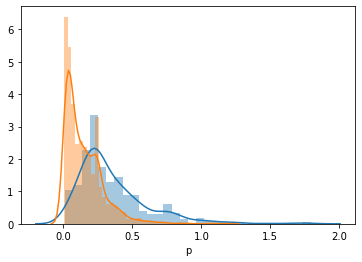

In [53]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3572492826220748, 'max_bin': 169, 'subsample': 0.6874225607452877, 'subsample_freq': 0.5369168449326642,
    'learning_rate': 0.0353671206084155, 'num_leaves': 8, 'feature_fraction': 0.9508830019260512, 
    'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 8.281467382972142, 'lambda_l2': 0.1428656656583413
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.15 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p)
sns.distplot(off_df[off_df.jobflag_2==0].p)

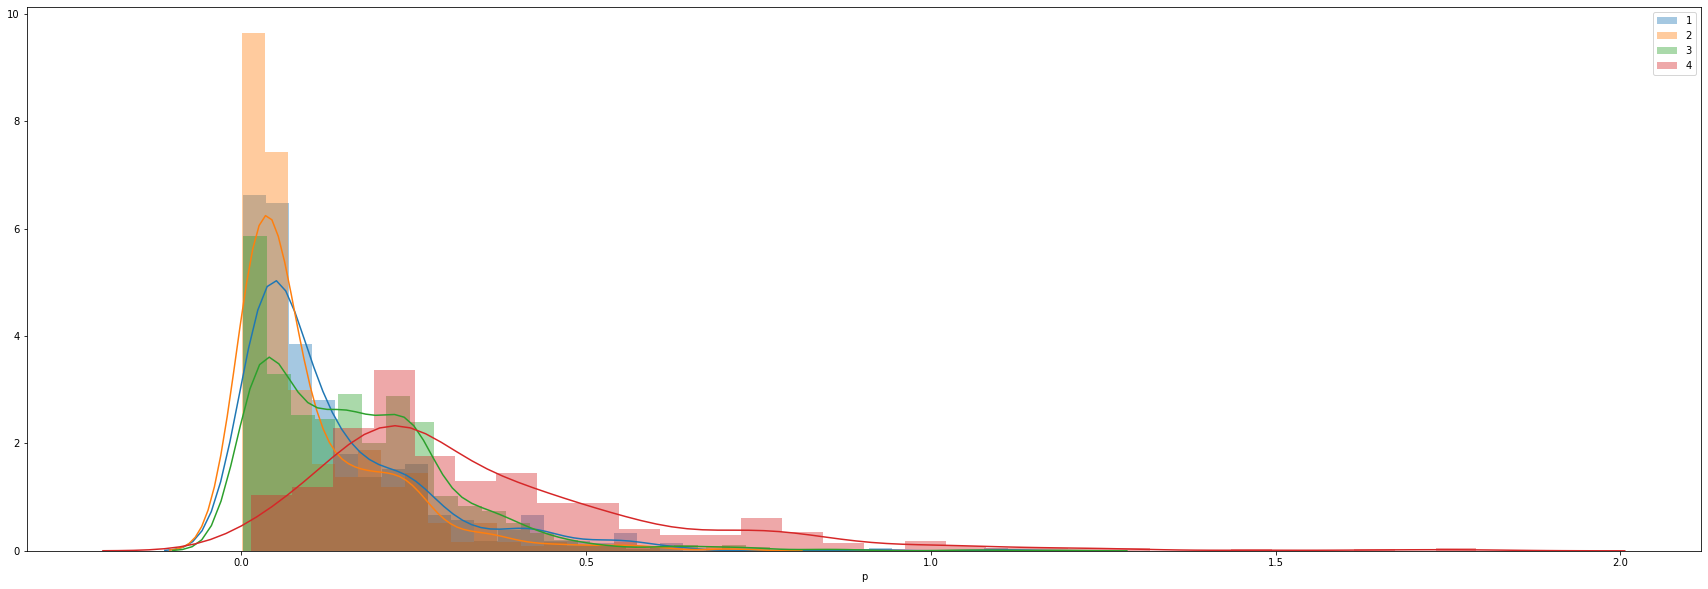

In [59]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()

#### label 1

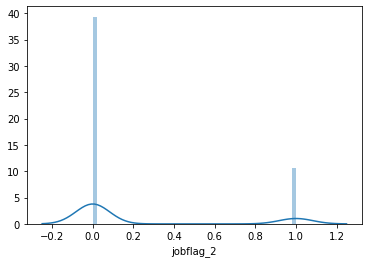

In [60]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
sns.distplot(train_df.jobflag_2)

In [64]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_params)
print(study.best_value)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.42182	valid_1's tweedie: 1.47505
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.41658	valid_1's tweedie: 1.45536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.38842	valid_1's tweedie: 1.45736
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.42679	valid_1's tweedie: 1.48558
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.41692	valid_1's tweedie: 1.45881


[I 2020-08-19 16:25:15,829] Finished trial#0 with value: 0.8210655258011456 with parameters: {'tweedie_variance_power': 1.3952535091429057, 'max_bin': 153, 'subsample': 0.7751764874504818, 'subsample_freq': 0.45380535117485143, 'learning_rate': 0.17351759879875367, 'num_leaves': 6, 'feature_fraction': 0.5636760754665906, 'bagging_freq': 2, 'min_child_samples': 48, 'lambda_l1': 0.01094927472698601, 'lambda_l2': 0.9396992256106341}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 2.22335	valid_1's tweedie: 2.28718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 2.20416	valid_1's tweedie: 2.27341
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 2.1869	valid_1's tweedie: 2.27714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 2.21409	valid_1's tweedie: 2.30162
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 2.12627	valid_1's tweedie: 2.22898


[I 2020-08-19 16:25:23,896] Finished trial#1 with value: 1.222297181838297 with parameters: {'tweedie_variance_power': 1.6442973673118173, 'max_bin': 177, 'subsample': 0.7389326787173576, 'subsample_freq': 0.5703655342159648, 'learning_rate': 0.10823630171080029, 'num_leaves': 5, 'feature_fraction': 0.7899611226119796, 'bagging_freq': 2, 'min_child_samples': 38, 'lambda_l1': 0.01216133263802021, 'lambda_l2': 0.00024263295372986858}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.52371	valid_1's tweedie: 1.55533
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.49133	valid_1's tweedie: 1.53832
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.5137	valid_1's tweedie: 1.52761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.48895	valid_1's tweedie: 1.54022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.50241	valid_1's tweedie: 1.52909


[I 2020-08-19 16:25:31,935] Finished trial#2 with value: 0.8587872245142736 with parameters: {'tweedie_variance_power': 1.4252056019806192, 'max_bin': 131, 'subsample': 0.510501953736011, 'subsample_freq': 0.6964811959865771, 'learning_rate': 0.24349849087033817, 'num_leaves': 4, 'feature_fraction': 0.9736995044145774, 'bagging_freq': 5, 'min_child_samples': 76, 'lambda_l1': 3.178501859022925, 'lambda_l2': 0.12805985727634098}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 3.22633	valid_1's tweedie: 3.40433
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 3.26266	valid_1's tweedie: 3.35284
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 3.30499	valid_1's tweedie: 3.43945
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's tweedie: 3.38816	valid_1's tweedie: 3.47251
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 3.15183	valid_1's tweedie: 3.33743


[I 2020-08-19 16:25:40,048] Finished trial#3 with value: 1.791058580224 with parameters: {'tweedie_variance_power': 1.753911544332436, 'max_bin': 158, 'subsample': 0.8453237785319226, 'subsample_freq': 0.4050067784406967, 'learning_rate': 0.281768572349683, 'num_leaves': 9, 'feature_fraction': 0.45809552134226694, 'bagging_freq': 6, 'min_child_samples': 40, 'lambda_l1': 0.029168112236248295, 'lambda_l2': 0.00161095799773255}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.59386	valid_1's tweedie: 4.61918
Early stopping, best iteration is:
[304]	training's tweedie: 4.60178	valid_1's tweedie: 4.61846
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.60438	valid_1's tweedie: 4.63456
Early stopping, best iteration is:
[482]	training's tweedie: 4.60493	valid_1's tweedie: 4.63419
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.60474	valid_1's tweedie: 4.62315
[1000]	training's tweedie: 4.59217	valid_1's tweedie: 4.62186
Early stopping, best iteration is:
[813]	training's tweedie: 4.59599	valid_1's tweedie: 4.62065
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.58766	valid_1's tweedie: 4.64009
Early stopping, best iteration is:
[396]	training's tweedie: 4.59143	valid_1's tweedie: 4.639
Training until validation scores don't improve for 200 rounds
[5

[I 2020-08-19 16:25:48,693] Finished trial#4 with value: 2.4009929692289242 with parameters: {'tweedie_variance_power': 1.0515592918991075, 'max_bin': 110, 'subsample': 0.6792708969135538, 'subsample_freq': 0.5744387638372283, 'learning_rate': 0.04446069626086224, 'num_leaves': 9, 'feature_fraction': 0.8460391982212108, 'bagging_freq': 2, 'min_child_samples': 74, 'lambda_l1': 3.638905783896287, 'lambda_l2': 7.366778897277973}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 3.03379	valid_1's tweedie: 3.13907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.95423	valid_1's tweedie: 3.04019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 2.93719	valid_1's tweedie: 3.07837
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 3.03134	valid_1's tweedie: 3.14969
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 2.93187	valid_1's tweedie: 3.07768


[I 2020-08-19 16:25:56,856] Finished trial#5 with value: 1.6378893044118137 with parameters: {'tweedie_variance_power': 1.7353036360508534, 'max_bin': 281, 'subsample': 0.5747042321794547, 'subsample_freq': 0.5492652507252467, 'learning_rate': 0.05556942721193185, 'num_leaves': 9, 'feature_fraction': 0.7420438403549596, 'bagging_freq': 1, 'min_child_samples': 33, 'lambda_l1': 3.670905867236183, 'lambda_l2': 0.00011537448192935226}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 4.06722	valid_1's tweedie: 4.20177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's tweedie: 4.25347	valid_1's tweedie: 4.29361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's tweedie: 4.2178	valid_1's tweedie: 4.2497
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	training's tweedie: 4.11399	valid_1's tweedie: 4.23714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's tweedie: 4.10321	valid_1's tweedie: 4.18452


[I 2020-08-19 16:26:04,944] Finished trial#6 with value: 2.2057194479862288 with parameters: {'tweedie_variance_power': 1.7923534637713314, 'max_bin': 255, 'subsample': 0.5491475683130751, 'subsample_freq': 0.645472176430653, 'learning_rate': 0.33687736395431095, 'num_leaves': 8, 'feature_fraction': 0.9990239306771329, 'bagging_freq': 6, 'min_child_samples': 53, 'lambda_l1': 0.00013550670924098192, 'lambda_l2': 0.11603447949885566}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.43214	valid_1's tweedie: 1.47329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.42898	valid_1's tweedie: 1.46602
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.42248	valid_1's tweedie: 1.4572
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.4157	valid_1's tweedie: 1.47355
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36609	valid_1's tweedie: 1.46989
Early stopping, best iteration is:
[387]	training's tweedie: 1.37555	valid_1's tweedie: 1.46402


[I 2020-08-19 16:26:13,176] Finished trial#7 with value: 0.8197279465991238 with parameters: {'tweedie_variance_power': 1.2938255513284251, 'max_bin': 168, 'subsample': 0.6819198337866925, 'subsample_freq': 0.7020555975062388, 'learning_rate': 0.21699329645624615, 'num_leaves': 5, 'feature_fraction': 0.5201876051423964, 'bagging_freq': 1, 'min_child_samples': 32, 'lambda_l1': 5.767712469297831, 'lambda_l2': 0.0002941205620686089}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.44966	valid_1's tweedie: 1.49674
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.4388	valid_1's tweedie: 1.47443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.43544	valid_1's tweedie: 1.47847
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.45181	valid_1's tweedie: 1.50669
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.44787	valid_1's tweedie: 1.47086


[I 2020-08-19 16:26:21,264] Finished trial#8 with value: 0.8327897646273044 with parameters: {'tweedie_variance_power': 1.4073747144483808, 'max_bin': 238, 'subsample': 0.8205992185547868, 'subsample_freq': 0.7404791696872566, 'learning_rate': 0.43354602376602014, 'num_leaves': 6, 'feature_fraction': 0.979111999599086, 'bagging_freq': 7, 'min_child_samples': 65, 'lambda_l1': 0.0007482266373738681, 'lambda_l2': 0.00026114763854321563}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.49969	valid_1's tweedie: 1.56359
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 1.49637	valid_1's tweedie: 1.52463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 1.45657	valid_1's tweedie: 1.52474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.53144	valid_1's tweedie: 1.57488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.46777	valid_1's tweedie: 1.53093


[I 2020-08-19 16:26:29,463] Finished trial#9 with value: 0.860069826594356 with parameters: {'tweedie_variance_power': 1.454519967285343, 'max_bin': 228, 'subsample': 0.4203927989766305, 'subsample_freq': 0.8247680047624095, 'learning_rate': 0.10927453698019662, 'num_leaves': 4, 'feature_fraction': 0.4765968047191459, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.09684260527508541, 'lambda_l2': 1.923893934322153}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 2.3516	valid_1's tweedie: 2.40596
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 2.32258	valid_1's tweedie: 2.39642
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's tweedie: 2.35121	valid_1's tweedie: 2.39328
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's tweedie: 2.33265	valid_1's tweedie: 2.41069
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's tweedie: 2.31338	valid_1's tweedie: 2.39461


[I 2020-08-19 16:26:37,922] Finished trial#10 with value: 1.285728706030775 with parameters: {'tweedie_variance_power': 1.113512328176224, 'max_bin': 62, 'subsample': 0.6501086747773523, 'subsample_freq': 0.8735121536582288, 'learning_rate': 0.07140488295071724, 'num_leaves': 7, 'feature_fraction': 0.6103005257580115, 'bagging_freq': 1, 'min_child_samples': 6, 'lambda_l1': 0.2594635099642346, 'lambda_l2': 0.0028278555807748117}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.59437	valid_1's tweedie: 1.61819
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.57472	valid_1's tweedie: 1.62101
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.56982	valid_1's tweedie: 1.60447
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's tweedie: 1.55662	valid_1's tweedie: 1.61313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.58502	valid_1's tweedie: 1.60392


[I 2020-08-19 16:26:46,050] Finished trial#11 with value: 0.8981858186267949 with parameters: {'tweedie_variance_power': 1.229554723354928, 'max_bin': 189, 'subsample': 0.7662259640757402, 'subsample_freq': 0.4007736976028998, 'learning_rate': 0.18867352837236967, 'num_leaves': 6, 'feature_fraction': 0.6054831524972688, 'bagging_freq': 3, 'min_child_samples': 94, 'lambda_l1': 0.0025645460373560107, 'lambda_l2': 1.3755260548093569}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.42842	valid_1's tweedie: 1.4929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.42907	valid_1's tweedie: 1.46651
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.43095	valid_1's tweedie: 1.48008
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.44446	valid_1's tweedie: 1.49861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.40389	valid_1's tweedie: 1.47602


[I 2020-08-19 16:26:54,134] Finished trial#12 with value: 0.8258501380067763 with parameters: {'tweedie_variance_power': 1.2735558382740604, 'max_bin': 88, 'subsample': 0.8928491556947096, 'subsample_freq': 0.46890002076955534, 'learning_rate': 0.16781998357463734, 'num_leaves': 5, 'feature_fraction': 0.5689883870808297, 'bagging_freq': 1, 'min_child_samples': 21, 'lambda_l1': 0.43989060160219307, 'lambda_l2': 0.009104843304201152}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.77206	valid_1's tweedie: 1.84054
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.76144	valid_1's tweedie: 1.78893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.71361	valid_1's tweedie: 1.79934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.76577	valid_1's tweedie: 1.86606
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.73709	valid_1's tweedie: 1.8105


[I 2020-08-19 16:27:02,192] Finished trial#13 with value: 1.0035177547455836 with parameters: {'tweedie_variance_power': 1.5577256163132227, 'max_bin': 201, 'subsample': 0.7550723999373276, 'subsample_freq': 0.7740866158441148, 'learning_rate': 0.15712461177566234, 'num_leaves': 6, 'feature_fraction': 0.4053853455251717, 'bagging_freq': 3, 'min_child_samples': 52, 'lambda_l1': 0.010823977333724736, 'lambda_l2': 0.41051948417112455}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.47197	valid_1's tweedie: 1.50114
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.43679	valid_1's tweedie: 1.49699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.45028	valid_1's tweedie: 1.50113
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.48567	valid_1's tweedie: 1.51453
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.43847	valid_1's tweedie: 1.4915


[I 2020-08-19 16:27:10,322] Finished trial#14 with value: 0.8392354666546088 with parameters: {'tweedie_variance_power': 1.2702386855978902, 'max_bin': 141, 'subsample': 0.7055978296269347, 'subsample_freq': 0.6533352227127313, 'learning_rate': 0.38724257599860024, 'num_leaves': 5, 'feature_fraction': 0.5186063890519897, 'bagging_freq': 2, 'min_child_samples': 24, 'lambda_l1': 0.0018147622709728858, 'lambda_l2': 0.03586223028859076}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.76013	valid_1's tweedie: 1.79889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.77114	valid_1's tweedie: 1.79075
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.70588	valid_1's tweedie: 1.78694
Early stopping, best iteration is:
[376]	training's tweedie: 1.7188	valid_1's tweedie: 1.78097
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	training's tweedie: 1.76169	valid_1's tweedie: 1.80109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.74679	valid_1's tweedie: 1.79042


[I 2020-08-19 16:27:18,571] Finished trial#15 with value: 0.9835531774151525 with parameters: {'tweedie_variance_power': 1.1788187305870426, 'max_bin': 109, 'subsample': 0.6190843217207923, 'subsample_freq': 0.4776869255282927, 'learning_rate': 0.09005082081787755, 'num_leaves': 7, 'feature_fraction': 0.6992932754033754, 'bagging_freq': 4, 'min_child_samples': 53, 'lambda_l1': 0.0001531207601624464, 'lambda_l2': 6.975870951282017}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.42539	valid_1's tweedie: 1.46076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.40694	valid_1's tweedie: 1.44096
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.40729	valid_1's tweedie: 1.44626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.41641	valid_1's tweedie: 1.46103
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.39184	valid_1's tweedie: 1.43939


[I 2020-08-19 16:27:26,550] Finished trial#16 with value: 0.8120114056401231 with parameters: {'tweedie_variance_power': 1.332818801336251, 'max_bin': 207, 'subsample': 0.7867419047081664, 'subsample_freq': 0.6445298163459509, 'learning_rate': 0.2482837086256115, 'num_leaves': 4, 'feature_fraction': 0.6565625180918407, 'bagging_freq': 1, 'min_child_samples': 44, 'lambda_l1': 0.5974445912521478, 'lambda_l2': 0.013033630426371528}. Best is trial#16 with value: 0.8120114056401231.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.41014	valid_1's tweedie: 1.45044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.37052	valid_1's tweedie: 1.42502
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.32923	valid_1's tweedie: 1.43028
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.40685	valid_1's tweedie: 1.45649
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.33873	valid_1's tweedie: 1.43537


[I 2020-08-19 16:27:34,651] Finished trial#17 with value: 0.8048864189955267 with parameters: {'tweedie_variance_power': 1.3335760244618435, 'max_bin': 211, 'subsample': 0.887739247855247, 'subsample_freq': 0.6535766024303923, 'learning_rate': 0.2450624110719973, 'num_leaves': 4, 'feature_fraction': 0.6764495540608862, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.7574046496247914, 'lambda_l2': 0.0010372288688032664}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.60511	valid_1's tweedie: 1.70614
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.61628	valid_1's tweedie: 1.67062
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.62528	valid_1's tweedie: 1.68117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.6259	valid_1's tweedie: 1.72181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.5313	valid_1's tweedie: 1.64339


[I 2020-08-19 16:27:42,896] Finished trial#18 with value: 0.9287994624472052 with parameters: {'tweedie_variance_power': 1.5211429691940315, 'max_bin': 300, 'subsample': 0.8974629905396241, 'subsample_freq': 0.6205205692979223, 'learning_rate': 0.3029753784073315, 'num_leaves': 4, 'feature_fraction': 0.6774155089673609, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.7195215571196201, 'lambda_l2': 0.0014776311085411033}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.43075	valid_1's tweedie: 1.46202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.42248	valid_1's tweedie: 1.47033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.39681	valid_1's tweedie: 1.45774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.40365	valid_1's tweedie: 1.46504
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.40433	valid_1's tweedie: 1.45368


[I 2020-08-19 16:27:51,029] Finished trial#19 with value: 0.820785453832696 with parameters: {'tweedie_variance_power': 1.3419344786530105, 'max_bin': 214, 'subsample': 0.8395335063740402, 'subsample_freq': 0.529652608359069, 'learning_rate': 0.46735603762306516, 'num_leaves': 4, 'feature_fraction': 0.8664523834862617, 'bagging_freq': 1, 'min_child_samples': 85, 'lambda_l1': 1.005466462927039, 'lambda_l2': 0.007631196605384999}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.17321	valid_1's tweedie: 2.22615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 2.16417	valid_1's tweedie: 2.21243
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.17333	valid_1's tweedie: 2.22187
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.15916	valid_1's tweedie: 2.23123
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's tweedie: 2.11787	valid_1's tweedie: 2.21692


[I 2020-08-19 16:27:59,341] Finished trial#20 with value: 1.1935949737639868 with parameters: {'tweedie_variance_power': 1.1262418616689642, 'max_bin': 266, 'subsample': 0.8815870179172398, 'subsample_freq': 0.6141595552854534, 'learning_rate': 0.13297260460802326, 'num_leaves': 10, 'feature_fraction': 0.6688016340102757, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.10861253259455188, 'lambda_l2': 0.01440681634572804}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.40186	valid_1's tweedie: 1.44435
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.3864	valid_1's tweedie: 1.42197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.39219	valid_1's tweedie: 1.43065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.38792	valid_1's tweedie: 1.46747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.3728	valid_1's tweedie: 1.42835


[I 2020-08-19 16:28:07,386] Finished trial#21 with value: 0.8011656903672565 with parameters: {'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603, 'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1, 'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.40258	valid_1's tweedie: 1.45747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.38282	valid_1's tweedie: 1.42107
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.38048	valid_1's tweedie: 1.43413
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.38506	valid_1's tweedie: 1.45456
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.37944	valid_1's tweedie: 1.42671


[I 2020-08-19 16:28:15,564] Finished trial#22 with value: 0.8048550438222803 with parameters: {'tweedie_variance_power': 1.336458767119076, 'max_bin': 210, 'subsample': 0.8106817365025444, 'subsample_freq': 0.6937585956377875, 'learning_rate': 0.23221227338302033, 'num_leaves': 4, 'feature_fraction': 0.6349109356884972, 'bagging_freq': 2, 'min_child_samples': 24, 'lambda_l1': 1.4048916909829758, 'lambda_l2': 0.0005932329588083746}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.55783	valid_1's tweedie: 1.61319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.49595	valid_1's tweedie: 1.57681
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.5209	valid_1's tweedie: 1.58215
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.54203	valid_1's tweedie: 1.62516
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.52094	valid_1's tweedie: 1.58517


[I 2020-08-19 16:28:23,700] Finished trial#23 with value: 0.8821803660476901 with parameters: {'tweedie_variance_power': 1.4847852493809561, 'max_bin': 237, 'subsample': 0.8551106921560121, 'subsample_freq': 0.7735208037184939, 'learning_rate': 0.21407459553612493, 'num_leaves': 5, 'feature_fraction': 0.7426068136823645, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 1.5202834938882381, 'lambda_l2': 0.00076529180594159}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.39762	valid_1's tweedie: 1.45078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.40089	valid_1's tweedie: 1.43173
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	training's tweedie: 1.36344	valid_1's tweedie: 1.43168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.38087	valid_1's tweedie: 1.44787
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	training's tweedie: 1.36484	valid_1's tweedie: 1.43679


[I 2020-08-19 16:28:31,863] Finished trial#24 with value: 0.8063706702153556 with parameters: {'tweedie_variance_power': 1.3534160037687217, 'max_bin': 189, 'subsample': 0.8084223978271373, 'subsample_freq': 0.6985891780014256, 'learning_rate': 0.34744487620356007, 'num_leaves': 4, 'feature_fraction': 0.6223242381853328, 'bagging_freq': 2, 'min_child_samples': 13, 'lambda_l1': 8.80606136490611, 'lambda_l2': 0.00010460427904074571}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.77202	valid_1's tweedie: 1.83503
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.75994	valid_1's tweedie: 1.81749
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.78937	valid_1's tweedie: 1.81711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.77761	valid_1's tweedie: 1.82893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's tweedie: 1.73604	valid_1's tweedie: 1.82093


[I 2020-08-19 16:28:40,139] Finished trial#25 with value: 0.9967319149927019 with parameters: {'tweedie_variance_power': 1.1712605856050826, 'max_bin': 218, 'subsample': 0.8733118392239054, 'subsample_freq': 0.7402523489101129, 'learning_rate': 0.1465114877993687, 'num_leaves': 5, 'feature_fraction': 0.74591492940474, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.16610368927177876, 'lambda_l2': 0.0007915818550551914}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.85013	valid_1's tweedie: 1.92237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	training's tweedie: 1.80097	valid_1's tweedie: 1.87885
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's tweedie: 1.80588	valid_1's tweedie: 1.88684
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 1.86319	valid_1's tweedie: 1.9428
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.74268	valid_1's tweedie: 1.88755
Early stopping, best iteration is:
[404]	training's tweedie: 1.76332	valid_1's tweedie: 1.8735


[I 2020-08-19 16:28:48,419] Finished trial#26 with value: 1.0362383038771175 with parameters: {'tweedie_variance_power': 1.57944663410417, 'max_bin': 252, 'subsample': 0.7334985069161268, 'subsample_freq': 0.6853548001994881, 'learning_rate': 0.030245396550008075, 'num_leaves': 4, 'feature_fraction': 0.8214925976253398, 'bagging_freq': 2, 'min_child_samples': 29, 'lambda_l1': 1.700063134982103, 'lambda_l2': 0.00422312496198974}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.57444	valid_1's tweedie: 1.60568
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.54407	valid_1's tweedie: 1.58303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.52829	valid_1's tweedie: 1.59442
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.58307	valid_1's tweedie: 1.61259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.52826	valid_1's tweedie: 1.59244


[I 2020-08-19 16:28:56,489] Finished trial#27 with value: 0.882063027306585 with parameters: {'tweedie_variance_power': 1.2236766187419033, 'max_bin': 191, 'subsample': 0.8100820699953251, 'subsample_freq': 0.8130258974206074, 'learning_rate': 0.27120455023640816, 'num_leaves': 5, 'feature_fraction': 0.6411689124966113, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.04897194708600456, 'lambda_l2': 0.0005966413347288268}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.40965	valid_1's tweedie: 1.45837
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.36385	valid_1's tweedie: 1.43512
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.35947	valid_1's tweedie: 1.43042
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.36986	valid_1's tweedie: 1.45148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's tweedie: 1.34877	valid_1's tweedie: 1.4484


[I 2020-08-19 16:29:04,720] Finished trial#28 with value: 0.8063155978344825 with parameters: {'tweedie_variance_power': 1.3772696048096338, 'max_bin': 276, 'subsample': 0.8647217280061441, 'subsample_freq': 0.7386694789177232, 'learning_rate': 0.20690132556727736, 'num_leaves': 6, 'feature_fraction': 0.7175970863132254, 'bagging_freq': 1, 'min_child_samples': 11, 'lambda_l1': 8.141010395299894, 'lambda_l2': 0.00011716730225371591}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.40934	valid_1's tweedie: 1.46322
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.3969	valid_1's tweedie: 1.43773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.40046	valid_1's tweedie: 1.44796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.42927	valid_1's tweedie: 1.46982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.40225	valid_1's tweedie: 1.44701


[I 2020-08-19 16:29:12,799] Finished trial#29 with value: 0.8130638117906035 with parameters: {'tweedie_variance_power': 1.3035839131539275, 'max_bin': 173, 'subsample': 0.7895865956939191, 'subsample_freq': 0.601751541540612, 'learning_rate': 0.18762918944434245, 'num_leaves': 4, 'feature_fraction': 0.5577442868648909, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 0.3339556608069808, 'lambda_l2': 0.0004438651290151852}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.52759	valid_1's tweedie: 1.58111
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.51032	valid_1's tweedie: 1.55116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.49448	valid_1's tweedie: 1.55639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.49556	valid_1's tweedie: 1.59168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.48221	valid_1's tweedie: 1.55675


[I 2020-08-19 16:29:20,949] Finished trial#30 with value: 0.8715614099529159 with parameters: {'tweedie_variance_power': 1.4719416194404962, 'max_bin': 226, 'subsample': 0.8288168790519516, 'subsample_freq': 0.6700420976580972, 'learning_rate': 0.11852603143902984, 'num_leaves': 7, 'feature_fraction': 0.5730773052680835, 'bagging_freq': 1, 'min_child_samples': 38, 'lambda_l1': 1.589975257815532, 'lambda_l2': 0.0019449334708901767}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.39848	valid_1's tweedie: 1.45473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.35701	valid_1's tweedie: 1.42639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.38356	valid_1's tweedie: 1.4264
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.37203	valid_1's tweedie: 1.44345
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	training's tweedie: 1.32936	valid_1's tweedie: 1.43497


[I 2020-08-19 16:29:29,126] Finished trial#31 with value: 0.8037126203661381 with parameters: {'tweedie_variance_power': 1.3620086810473786, 'max_bin': 296, 'subsample': 0.8993928197043167, 'subsample_freq': 0.7326983727174163, 'learning_rate': 0.21663533482750158, 'num_leaves': 6, 'feature_fraction': 0.7090158987192687, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 6.444466981626878, 'lambda_l2': 0.00012303576023202945}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.3738	valid_1's tweedie: 1.47057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.3742	valid_1's tweedie: 1.43678
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.42143	valid_1's tweedie: 1.44905
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.3964	valid_1's tweedie: 1.47771
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.35465	valid_1's tweedie: 1.46015


[I 2020-08-19 16:29:37,253] Finished trial#32 with value: 0.81164900115297 with parameters: {'tweedie_variance_power': 1.3965429616251996, 'max_bin': 293, 'subsample': 0.8956763598103592, 'subsample_freq': 0.7276208029045259, 'learning_rate': 0.23364937116383644, 'num_leaves': 6, 'feature_fraction': 0.7842990142034341, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 2.4274219784908526, 'lambda_l2': 0.00017512002956793585}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.47255	valid_1's tweedie: 1.54625
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.49951	valid_1's tweedie: 1.52776
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.4961	valid_1's tweedie: 1.52896
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.49807	valid_1's tweedie: 1.54498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's tweedie: 1.45706	valid_1's tweedie: 1.53662


[I 2020-08-19 16:29:45,429] Finished trial#33 with value: 0.8525596264058996 with parameters: {'tweedie_variance_power': 1.243530832776407, 'max_bin': 205, 'subsample': 0.8976497909037717, 'subsample_freq': 0.7709540302659937, 'learning_rate': 0.3149811782312566, 'num_leaves': 5, 'feature_fraction': 0.7012800765408933, 'bagging_freq': 1, 'min_child_samples': 6, 'lambda_l1': 5.536790186929965, 'lambda_l2': 0.0004282567851213622}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.41029	valid_1's tweedie: 1.5218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.40295	valid_1's tweedie: 1.47213
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.38479	valid_1's tweedie: 1.49693
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.47768	valid_1's tweedie: 1.53148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.39582	valid_1's tweedie: 1.48252


[I 2020-08-19 16:29:53,633] Finished trial#34 with value: 0.8345868403208241 with parameters: {'tweedie_variance_power': 1.4378611734495708, 'max_bin': 247, 'subsample': 0.7265055891678349, 'subsample_freq': 0.719701278530409, 'learning_rate': 0.16360955952251546, 'num_leaves': 6, 'feature_fraction': 0.7831465197598255, 'bagging_freq': 2, 'min_child_samples': 18, 'lambda_l1': 0.9209782990005378, 'lambda_l2': 0.0009336041334505759}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.41408	valid_1's tweedie: 1.46022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.40071	valid_1's tweedie: 1.43438
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.39384	valid_1's tweedie: 1.43164
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.40971	valid_1's tweedie: 1.44871
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.39643	valid_1's tweedie: 1.45341


[I 2020-08-19 16:30:01,661] Finished trial#35 with value: 0.8084660504831853 with parameters: {'tweedie_variance_power': 1.3194502484630517, 'max_bin': 158, 'subsample': 0.8540009309488594, 'subsample_freq': 0.8149906525568238, 'learning_rate': 0.3772161410815202, 'num_leaves': 5, 'feature_fraction': 0.6369161917529241, 'bagging_freq': 1, 'min_child_samples': 36, 'lambda_l1': 9.437722367315276, 'lambda_l2': 0.00018875363947613204}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.42367	valid_1's tweedie: 1.46317
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.39763	valid_1's tweedie: 1.44439
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.40785	valid_1's tweedie: 1.44501
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.40708	valid_1's tweedie: 1.46756
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.39606	valid_1's tweedie: 1.44731


[I 2020-08-19 16:30:09,678] Finished trial#36 with value: 0.8118615808290145 with parameters: {'tweedie_variance_power': 1.3740340139493095, 'max_bin': 139, 'subsample': 0.7935578089367864, 'subsample_freq': 0.588433764328122, 'learning_rate': 0.2670803948100204, 'num_leaves': 4, 'feature_fraction': 0.6962171138422488, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 2.3014941493775094, 'lambda_l2': 0.004008829820264461}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.42625	valid_1's tweedie: 1.50448
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.40516	valid_1's tweedie: 1.47226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.41478	valid_1's tweedie: 1.47331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.39474	valid_1's tweedie: 1.49648
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.41815	valid_1's tweedie: 1.49475


[I 2020-08-19 16:30:17,898] Finished trial#37 with value: 0.8285680469282048 with parameters: {'tweedie_variance_power': 1.4223346873932028, 'max_bin': 181, 'subsample': 0.4539378101667627, 'subsample_freq': 0.6692822895283543, 'learning_rate': 0.1394686259718435, 'num_leaves': 8, 'feature_fraction': 0.5778174756542834, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 3.7084568430688902, 'lambda_l2': 0.001145392545196617}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 2.18941	valid_1's tweedie: 2.32135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 2.21426	valid_1's tweedie: 2.27829
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 2.14618	valid_1's tweedie: 2.29741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.27988	valid_1's tweedie: 2.34805
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 2.22622	valid_1's tweedie: 2.27202


[I 2020-08-19 16:30:26,021] Finished trial#38 with value: 1.2409241661216917 with parameters: {'tweedie_variance_power': 1.6513145329936372, 'max_bin': 267, 'subsample': 0.8384718100623879, 'subsample_freq': 0.6383797320369671, 'learning_rate': 0.19030963881086826, 'num_leaves': 5, 'feature_fraction': 0.9015616917720043, 'bagging_freq': 1, 'min_child_samples': 61, 'lambda_l1': 0.2613640812266505, 'lambda_l2': 0.0003730001593418539}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.74398	valid_1's tweedie: 1.79304
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.74525	valid_1's tweedie: 1.77632
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.74035	valid_1's tweedie: 1.7871
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.75907	valid_1's tweedie: 1.80156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.73358	valid_1's tweedie: 1.78137


[I 2020-08-19 16:30:34,049] Finished trial#39 with value: 0.9782127973121334 with parameters: {'tweedie_variance_power': 1.1786718983449076, 'max_bin': 166, 'subsample': 0.7609694469897228, 'subsample_freq': 0.7064793256645884, 'learning_rate': 0.243675461585467, 'num_leaves': 5, 'feature_fraction': 0.5338187422738825, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 0.02837733442552761, 'lambda_l2': 0.00022577087816537497}. Best is trial#21 with value: 0.8011656903672565.


{'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603, 'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1, 'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059}
0.8011656903672565


In [65]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603,
    'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1,
    'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.38543	valid_1's tweedie: 1.44904
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.39585	valid_1's tweedie: 1.43108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.36637	valid_1's tweedie: 1.4345
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.38248	valid_1's tweedie: 1.46029
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.34984	valid_1's tweedie: 1.43069

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
                
Traini

[14]	training's tweedie: 2.8123	valid_1's tweedie: 2.64482
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 2.74565	valid_1's tweedie: 2.95968
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.77674	valid_1's tweedie: 2.79438

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.7675	valid_1's tweedie: 2.90485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.78215	valid_1's tweedie: 2.75317
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.78977	valid_1's tweedie: 2.80832
Training until validation scores don't improve for 200 rounds
E

[12]	training's tweedie: 2.80956	valid_1's tweedie: 2.83357

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 2.81054	valid_1's tweedie: 2.86361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.82168	valid_1's tweedie: 2.83011
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 2.82823	valid_1's tweedie: 2.76846
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 2.80198	valid_1's tweedie: 2.85874
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.81428	valid_1's tweedie: 2.85718

                
                Train Null Importance   29

[11]	training's tweedie: 2.82502	valid_1's tweedie: 2.88961
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 2.81721	valid_1's tweedie: 2.94433
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 2.83913	valid_1's tweedie: 2.807

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.79594	valid_1's tweedie: 2.82327
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 2.81206	valid_1's tweedie: 2.7539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.79582	valid_1's tweedie: 2.82055
Training until validation scores don't improve for 200 rounds
Ea

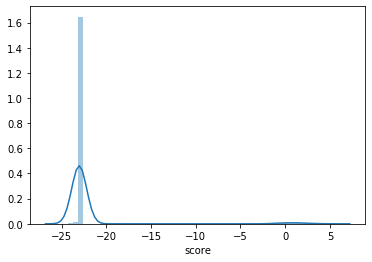

In [66]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [67]:
feature = ['data', 'analyt', 'model', 'analysi', 'softwar', 'particip', 'techniqu', 'predict', 'algorithm', 'requir', 'busi', 'stakehold',
           'sale', 'custom', 'network', 'machinelearn', 'test', 'design', 'support', 'insight', 'perform', 'system', 'result',
           'review', 'continu', 
           'meet', 'technic', 'implement', 'build', 'servic', 'secur', 'understand', 'provid', 'establish', 'architectur', 'skill',
           'engin', 'report',
           'optim', 'work', 'commun', 'across', 'configur', 'present', 'plan', 'respons', 'product', 'maintain', 'solut', 'specif',
           'environ', 'manag',
           'opportun', 'applic', 'client', 'train', 'effici', 'activ', 'creat', 'method', 'defin', 'set', 'member', 'conduct', 'develop',
           'contribut',
           'platform', 'project', 'statist', 'analyz', 'interfac', 'code', 'innov', 'team', 'collabor', 'complet', 'infrastructur', 'agil',
           'oper', 
           'extern', 'within', 'research','includ', 'make', 'best', 'compon', 'help', 'autom', 'practic', 'use', 'high', 'new', 'qualiti',
           'issu', 'integr', 'document', 'improv', 'procedur', 'drive', 'intern', 'standard', 'expert', 'function', 'program', 'close',
           'knowledg', 'relat', 'problem', 'identifi']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.71019	valid_1's tweedie: 1.75761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's tweedie: 1.69357	valid_1's tweedie: 1.74562
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's tweedie: 1.69585	valid_1's tweedie: 1.74946
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.71028	valid_1's tweedie: 1.76697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.69694	valid_1's tweedie: 1.75726


[I 2020-08-19 16:39:26,466] Finished trial#0 with value: 0.96077154804292 with parameters: {'tweedie_variance_power': 1.1827429434196821, 'max_bin': 56, 'subsample': 0.49059920487433534, 'subsample_freq': 0.7633531310284107, 'learning_rate': 0.03858511411320051, 'num_leaves': 10, 'feature_fraction': 0.6552795329135537, 'bagging_freq': 6, 'min_child_samples': 12, 'lambda_l1': 0.0002883575345069652, 'lambda_l2': 0.013169387391565156}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 2.20419	valid_1's tweedie: 2.27923
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 2.16949	valid_1's tweedie: 2.22652
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's tweedie: 2.14077	valid_1's tweedie: 2.24817
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.22421	valid_1's tweedie: 2.313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 2.15138	valid_1's tweedie: 2.23527


[I 2020-08-19 16:39:27,265] Finished trial#1 with value: 1.2189244872567941 with parameters: {'tweedie_variance_power': 1.6456126738232042, 'max_bin': 277, 'subsample': 0.7473353935767866, 'subsample_freq': 0.8347775888321849, 'learning_rate': 0.0507749141218263, 'num_leaves': 7, 'feature_fraction': 0.7561566037821619, 'bagging_freq': 4, 'min_child_samples': 47, 'lambda_l1': 0.16248410578971667, 'lambda_l2': 0.05680649300056185}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 11.3075	valid_1's tweedie: 11.3252
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 11.3008	valid_1's tweedie: 11.3244
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 11.2959	valid_1's tweedie: 11.3246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 11.2862	valid_1's tweedie: 11.3803
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 11.3078	valid_1's tweedie: 11.3087


[I 2020-08-19 16:39:28,112] Finished trial#2 with value: 5.750085030203866 with parameters: {'tweedie_variance_power': 1.0195779178532836, 'max_bin': 159, 'subsample': 0.4262323591700858, 'subsample_freq': 0.5899960989442586, 'learning_rate': 0.07907308355910006, 'num_leaves': 8, 'feature_fraction': 0.7491623400976799, 'bagging_freq': 7, 'min_child_samples': 8, 'lambda_l1': 0.42486311977820945, 'lambda_l2': 1.0537629940103705}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 2.1962	valid_1's tweedie: 2.25952
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 2.11476	valid_1's tweedie: 2.20573
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's tweedie: 2.14361	valid_1's tweedie: 2.21218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 2.12872	valid_1's tweedie: 2.28272
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 2.1261	valid_1's tweedie: 2.23962


[I 2020-08-19 16:39:28,893] Finished trial#3 with value: 1.2097182010279288 with parameters: {'tweedie_variance_power': 1.6425061810365307, 'max_bin': 245, 'subsample': 0.8526922713277022, 'subsample_freq': 0.8409095158226491, 'learning_rate': 0.07552729102360528, 'num_leaves': 6, 'feature_fraction': 0.7570622474214623, 'bagging_freq': 4, 'min_child_samples': 63, 'lambda_l1': 9.392826091564618, 'lambda_l2': 0.457763018691101}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 4.58219	valid_1's tweedie: 4.60523
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 4.58138	valid_1's tweedie: 4.60702
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 4.56561	valid_1's tweedie: 4.60719
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 4.58705	valid_1's tweedie: 4.62431
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 4.56975	valid_1's tweedie: 4.59524


[I 2020-08-19 16:39:29,643] Finished trial#4 with value: 2.391237462887796 with parameters: {'tweedie_variance_power': 1.0516472968412578, 'max_bin': 77, 'subsample': 0.7130115591439665, 'subsample_freq': 0.4070658412455502, 'learning_rate': 0.25164698452007017, 'num_leaves': 7, 'feature_fraction': 0.4896683762510503, 'bagging_freq': 3, 'min_child_samples': 43, 'lambda_l1': 0.0008383186173222583, 'lambda_l2': 0.0489684860559554}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's tweedie: 1.88089	valid_1's tweedie: 1.90187
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.88747	valid_1's tweedie: 1.91697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's tweedie: 1.86005	valid_1's tweedie: 1.86907
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.84238	valid_1's tweedie: 1.8701
Early stopping, best iteration is:
[411]	training's tweedie: 1.84718	valid_1's tweedie: 1.86429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's tweedie: 1.86075	valid_1's tweedie: 1.89146


[I 2020-08-19 16:39:30,429] Finished trial#5 with value: 1.0349469415661108 with parameters: {'tweedie_variance_power': 1.5549219591880556, 'max_bin': 139, 'subsample': 0.40728251870511906, 'subsample_freq': 0.5367375836466393, 'learning_rate': 0.06196333362197368, 'num_leaves': 10, 'feature_fraction': 0.7093861151004981, 'bagging_freq': 2, 'min_child_samples': 92, 'lambda_l1': 0.0014295281773773134, 'lambda_l2': 0.0006558697867905924}. Best is trial#0 with value: 0.96077154804292.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.43476	valid_1's tweedie: 1.47838
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.43183	valid_1's tweedie: 1.45259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.39772	valid_1's tweedie: 1.44246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.3855	valid_1's tweedie: 1.47938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.42529	valid_1's tweedie: 1.45287


[I 2020-08-19 16:39:31,170] Finished trial#6 with value: 0.8228570220822076 with parameters: {'tweedie_variance_power': 1.3538529197059839, 'max_bin': 201, 'subsample': 0.6251516190460695, 'subsample_freq': 0.7868227968751047, 'learning_rate': 0.2130461379151586, 'num_leaves': 8, 'feature_fraction': 0.5961381534170033, 'bagging_freq': 7, 'min_child_samples': 59, 'lambda_l1': 0.003460732178127668, 'lambda_l2': 0.12042826342851866}. Best is trial#6 with value: 0.8228570220822076.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 3.26803	valid_1's tweedie: 3.29489
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[265]	training's tweedie: 3.26701	valid_1's tweedie: 3.3031
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 3.24823	valid_1's tweedie: 3.28826
Early stopping, best iteration is:
[586]	training's tweedie: 3.24372	valid_1's tweedie: 3.28662
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 3.23994	valid_1's tweedie: 3.30675
Early stopping, best iteration is:
[385]	training's tweedie: 3.24707	valid_1's tweedie: 3.30369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[227]	training's tweedie: 3.26599	valid_1's tweedie: 3.28699


[I 2020-08-19 16:39:32,142] Finished trial#7 with value: 1.7372585542541292 with parameters: {'tweedie_variance_power': 1.0766148729129257, 'max_bin': 284, 'subsample': 0.5537457330920204, 'subsample_freq': 0.611807142207449, 'learning_rate': 0.07507847000424893, 'num_leaves': 6, 'feature_fraction': 0.5272442621229144, 'bagging_freq': 5, 'min_child_samples': 57, 'lambda_l1': 0.0014183504844357021, 'lambda_l2': 8.898568000938557}. Best is trial#6 with value: 0.8228570220822076.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.00878	valid_1's tweedie: 2.03519
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.97428	valid_1's tweedie: 2.02849
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.001	valid_1's tweedie: 2.03828
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.00343	valid_1's tweedie: 2.04212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.00448	valid_1's tweedie: 2.02802


[I 2020-08-19 16:39:32,905] Finished trial#8 with value: 1.1038707917430244 with parameters: {'tweedie_variance_power': 1.145572402595101, 'max_bin': 134, 'subsample': 0.6717271487799606, 'subsample_freq': 0.6346676939194016, 'learning_rate': 0.45078729592445343, 'num_leaves': 9, 'feature_fraction': 0.6482528725470647, 'bagging_freq': 3, 'min_child_samples': 50, 'lambda_l1': 0.32337125412313517, 'lambda_l2': 0.10200480241712279}. Best is trial#6 with value: 0.8228570220822076.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's tweedie: 2.20061	valid_1's tweedie: 2.28518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's tweedie: 2.15196	valid_1's tweedie: 2.22214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[254]	training's tweedie: 2.13385	valid_1's tweedie: 2.22342
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's tweedie: 2.2032	valid_1's tweedie: 2.30297
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's tweedie: 2.17217	valid_1's tweedie: 2.24647


[I 2020-08-19 16:39:33,727] Finished trial#9 with value: 1.2180914645228187 with parameters: {'tweedie_variance_power': 1.6428687642229587, 'max_bin': 292, 'subsample': 0.8522171133573575, 'subsample_freq': 0.7663177994165598, 'learning_rate': 0.0451827676465542, 'num_leaves': 4, 'feature_fraction': 0.812890809194339, 'bagging_freq': 2, 'min_child_samples': 74, 'lambda_l1': 1.3457874510143726, 'lambda_l2': 0.07211395254965175}. Best is trial#6 with value: 0.8228570220822076.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.42659	valid_1's tweedie: 1.46807
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.40218	valid_1's tweedie: 1.42201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.40401	valid_1's tweedie: 1.43108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.44243	valid_1's tweedie: 1.47747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.40485	valid_1's tweedie: 1.44033


[I 2020-08-19 16:39:34,431] Finished trial#10 with value: 0.8093584015697873 with parameters: {'tweedie_variance_power': 1.3479326222315813, 'max_bin': 223, 'subsample': 0.5845166190558321, 'subsample_freq': 0.7265857897870536, 'learning_rate': 0.17725404223265712, 'num_leaves': 4, 'feature_fraction': 0.9673744656266451, 'bagging_freq': 7, 'min_child_samples': 27, 'lambda_l1': 0.008850911291589533, 'lambda_l2': 0.0024515468681429995}. Best is trial#10 with value: 0.8093584015697873.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.4274	valid_1's tweedie: 1.46602
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.38428	valid_1's tweedie: 1.41721
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.40284	valid_1's tweedie: 1.43111
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.44122	valid_1's tweedie: 1.47956
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.42093	valid_1's tweedie: 1.44504


[I 2020-08-19 16:39:35,135] Finished trial#11 with value: 0.809698733408327 with parameters: {'tweedie_variance_power': 1.3491355654426014, 'max_bin': 214, 'subsample': 0.5937897821514662, 'subsample_freq': 0.7288324917693443, 'learning_rate': 0.175321598235121, 'num_leaves': 4, 'feature_fraction': 0.9769114515021932, 'bagging_freq': 7, 'min_child_samples': 27, 'lambda_l1': 0.0104359782454375, 'lambda_l2': 0.0017134872147406578}. Best is trial#10 with value: 0.8093584015697873.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.42781	valid_1's tweedie: 1.46276
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.39968	valid_1's tweedie: 1.41646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.39509	valid_1's tweedie: 1.43527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.40848	valid_1's tweedie: 1.46438
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.4061	valid_1's tweedie: 1.45041


[I 2020-08-19 16:39:35,840] Finished trial#12 with value: 0.8054894454534729 with parameters: {'tweedie_variance_power': 1.349969119190657, 'max_bin': 212, 'subsample': 0.5774043241504451, 'subsample_freq': 0.7045972939301558, 'learning_rate': 0.16528226095247364, 'num_leaves': 4, 'feature_fraction': 0.9964784224971625, 'bagging_freq': 6, 'min_child_samples': 23, 'lambda_l1': 0.016924825494747078, 'lambda_l2': 0.0008031532180312293}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.50323	valid_1's tweedie: 1.56066
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.48115	valid_1's tweedie: 1.49972
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.51363	valid_1's tweedie: 1.53546
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.50345	valid_1's tweedie: 1.56632
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.47984	valid_1's tweedie: 1.53547


[I 2020-08-19 16:39:36,563] Finished trial#13 with value: 0.8562480760895231 with parameters: {'tweedie_variance_power': 1.4525737755128183, 'max_bin': 233, 'subsample': 0.5200129392637229, 'subsample_freq': 0.7126085137276856, 'learning_rate': 0.13618366715962352, 'num_leaves': 5, 'feature_fraction': 0.9983696541804895, 'bagging_freq': 6, 'min_child_samples': 27, 'lambda_l1': 0.02871476927725823, 'lambda_l2': 0.0001839203008567854}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.51452	valid_1's tweedie: 1.539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.46605	valid_1's tweedie: 1.5061
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.49416	valid_1's tweedie: 1.52761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.51596	valid_1's tweedie: 1.54487
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.46046	valid_1's tweedie: 1.52442


[I 2020-08-19 16:39:37,259] Finished trial#14 with value: 0.8525760135239508 with parameters: {'tweedie_variance_power': 1.2543474727270854, 'max_bin': 180, 'subsample': 0.4743117333892451, 'subsample_freq': 0.8904857060521181, 'learning_rate': 0.3464649901401489, 'num_leaves': 4, 'feature_fraction': 0.9014903572876385, 'bagging_freq': 6, 'min_child_samples': 25, 'lambda_l1': 0.04130075728029178, 'lambda_l2': 0.003655015361799352}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 4.04287	valid_1's tweedie: 4.12008
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 4.10735	valid_1's tweedie: 4.0961
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 4.0279	valid_1's tweedie: 4.13332
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 4.0292	valid_1's tweedie: 4.14289
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 4.06325	valid_1's tweedie: 4.10914


[I 2020-08-19 16:39:38,006] Finished trial#15 with value: 2.1497107369329145 with parameters: {'tweedie_variance_power': 1.7917605903136704, 'max_bin': 251, 'subsample': 0.5777162920692894, 'subsample_freq': 0.6806891350433334, 'learning_rate': 0.11396440597936473, 'num_leaves': 5, 'feature_fraction': 0.9060165460572277, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.00010372763250608075, 'lambda_l2': 0.00011466686794677271}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.49642	valid_1's tweedie: 1.55563
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.47203	valid_1's tweedie: 1.53721
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.50572	valid_1's tweedie: 1.54786
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.49621	valid_1's tweedie: 1.57412
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.472	valid_1's tweedie: 1.52235


[I 2020-08-19 16:39:38,727] Finished trial#16 with value: 0.8595228920939083 with parameters: {'tweedie_variance_power': 1.4566246458890393, 'max_bin': 191, 'subsample': 0.7562679404327047, 'subsample_freq': 0.5160250126213758, 'learning_rate': 0.3173220682605909, 'num_leaves': 5, 'feature_fraction': 0.9098050038510525, 'bagging_freq': 5, 'min_child_samples': 34, 'lambda_l1': 0.009734606946089438, 'lambda_l2': 0.007049635922209145}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.48025	valid_1's tweedie: 1.49891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.45846	valid_1's tweedie: 1.47608
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.45816	valid_1's tweedie: 1.47234
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.46374	valid_1's tweedie: 1.51243
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.44665	valid_1's tweedie: 1.48013


[I 2020-08-19 16:39:39,440] Finished trial#17 with value: 0.8301384525830192 with parameters: {'tweedie_variance_power': 1.2795427955614282, 'max_bin': 225, 'subsample': 0.6471201725794434, 'subsample_freq': 0.6909054174919347, 'learning_rate': 0.13033787769941513, 'num_leaves': 4, 'feature_fraction': 0.9965831299309924, 'bagging_freq': 7, 'min_child_samples': 35, 'lambda_l1': 0.04300384006184281, 'lambda_l2': 0.0006719836985813225}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.64111	valid_1's tweedie: 1.70722
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.56138	valid_1's tweedie: 1.68182
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.60579	valid_1's tweedie: 1.67638
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.61985	valid_1's tweedie: 1.70943
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.58322	valid_1's tweedie: 1.6692


[I 2020-08-19 16:39:40,194] Finished trial#18 with value: 0.9339683464820181 with parameters: {'tweedie_variance_power': 1.514960378743024, 'max_bin': 262, 'subsample': 0.5438949735421064, 'subsample_freq': 0.8325724354220568, 'learning_rate': 0.17906095421966992, 'num_leaves': 6, 'feature_fraction': 0.8417952187431342, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.004509110390318945, 'lambda_l2': 0.000348188756737665}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.46303	valid_1's tweedie: 1.49515
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.44252	valid_1's tweedie: 1.45877
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.46164	valid_1's tweedie: 1.47973
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 1.43544	valid_1's tweedie: 1.50393
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.45775	valid_1's tweedie: 1.48654


[I 2020-08-19 16:39:40,938] Finished trial#19 with value: 0.8290744502598577 with parameters: {'tweedie_variance_power': 1.2772433171996374, 'max_bin': 162, 'subsample': 0.4624407661048151, 'subsample_freq': 0.5568141459629621, 'learning_rate': 0.09883069473173985, 'num_leaves': 5, 'feature_fraction': 0.9612524762916842, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 0.07954613502019366, 'lambda_l2': 0.0013132792859582452}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.41772	valid_1's tweedie: 1.47336
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.40333	valid_1's tweedie: 1.44303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.40426	valid_1's tweedie: 1.4463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.44945	valid_1's tweedie: 1.48012
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.39915	valid_1's tweedie: 1.44332


[I 2020-08-19 16:39:41,683] Finished trial#20 with value: 0.8171492684876835 with parameters: {'tweedie_variance_power': 1.3719595433956326, 'max_bin': 107, 'subsample': 0.6159625968987597, 'subsample_freq': 0.45193472704743154, 'learning_rate': 0.2780705061910301, 'num_leaves': 4, 'feature_fraction': 0.8408429857857929, 'bagging_freq': 1, 'min_child_samples': 40, 'lambda_l1': 0.014456352765460872, 'lambda_l2': 0.013601720551090145}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.4288	valid_1's tweedie: 1.46494
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.39012	valid_1's tweedie: 1.41881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.4047	valid_1's tweedie: 1.43214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.44112	valid_1's tweedie: 1.4805
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.42508	valid_1's tweedie: 1.44675


[I 2020-08-19 16:39:42,383] Finished trial#21 with value: 0.8116519579291771 with parameters: {'tweedie_variance_power': 1.3340872569655045, 'max_bin': 220, 'subsample': 0.5819915164826162, 'subsample_freq': 0.715215181327641, 'learning_rate': 0.18177955135859855, 'num_leaves': 4, 'feature_fraction': 0.9464921085625192, 'bagging_freq': 7, 'min_child_samples': 29, 'lambda_l1': 0.006994095531904823, 'lambda_l2': 0.0014766989668841375}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.61757	valid_1's tweedie: 1.65767
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.59116	valid_1's tweedie: 1.63118
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.60325	valid_1's tweedie: 1.64052
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.61396	valid_1's tweedie: 1.66298
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.60466	valid_1's tweedie: 1.64386


[I 2020-08-19 16:39:43,101] Finished trial#22 with value: 0.910618013761897 with parameters: {'tweedie_variance_power': 1.2087089062399876, 'max_bin': 212, 'subsample': 0.6876309943637826, 'subsample_freq': 0.6556656312816888, 'learning_rate': 0.1594117221021784, 'num_leaves': 5, 'feature_fraction': 0.40139336722233043, 'bagging_freq': 7, 'min_child_samples': 17, 'lambda_l1': 0.01975429912312944, 'lambda_l2': 0.00245676149468233}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.46616	valid_1's tweedie: 1.51108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.45432	valid_1's tweedie: 1.48456
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.43394	valid_1's tweedie: 1.48028
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.49059	valid_1's tweedie: 1.52556
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.39768	valid_1's tweedie: 1.49191


[I 2020-08-19 16:39:43,801] Finished trial#23 with value: 0.8370238128633432 with parameters: {'tweedie_variance_power': 1.422643672677317, 'max_bin': 204, 'subsample': 0.6001340839489067, 'subsample_freq': 0.7422645314591865, 'learning_rate': 0.2120119896864939, 'num_leaves': 4, 'feature_fraction': 0.9988913384563741, 'bagging_freq': 6, 'min_child_samples': 35, 'lambda_l1': 0.0034020812413017233, 'lambda_l2': 0.005268711802105208}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.41597	valid_1's tweedie: 1.4659
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's tweedie: 1.38111	valid_1's tweedie: 1.42752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.39747	valid_1's tweedie: 1.42425
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.437	valid_1's tweedie: 1.47206
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.3342	valid_1's tweedie: 1.43726


[I 2020-08-19 16:39:44,563] Finished trial#24 with value: 0.8074771407133114 with parameters: {'tweedie_variance_power': 1.3340743199632508, 'max_bin': 238, 'subsample': 0.5235321743583352, 'subsample_freq': 0.7984417207542436, 'learning_rate': 0.14929926049018177, 'num_leaves': 5, 'feature_fraction': 0.9543819121999625, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 0.10055980847008342, 'lambda_l2': 0.00037781173680593883}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.62368	valid_1's tweedie: 1.68507
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.54599	valid_1's tweedie: 1.614
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.56694	valid_1's tweedie: 1.65341
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.60015	valid_1's tweedie: 1.68477
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.57415	valid_1's tweedie: 1.65249


[I 2020-08-19 16:39:45,351] Finished trial#25 with value: 0.9144391990854637 with parameters: {'tweedie_variance_power': 1.5121214827279887, 'max_bin': 261, 'subsample': 0.5125018689709026, 'subsample_freq': 0.8048675560612302, 'learning_rate': 0.10046898231152158, 'num_leaves': 6, 'feature_fraction': 0.8671654952344856, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 1.1213696473176915, 'lambda_l2': 0.00011092674510274445}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.43433	valid_1's tweedie: 1.48338
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.39003	valid_1's tweedie: 1.44153
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.43242	valid_1's tweedie: 1.45713
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.43282	valid_1's tweedie: 1.49143
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.43698	valid_1's tweedie: 1.47009


[I 2020-08-19 16:39:46,060] Finished trial#26 with value: 0.8239155652595728 with parameters: {'tweedie_variance_power': 1.3103098540605758, 'max_bin': 240, 'subsample': 0.449272866187562, 'subsample_freq': 0.8862573542609179, 'learning_rate': 0.42950591007430405, 'num_leaves': 5, 'feature_fraction': 0.9352692161409506, 'bagging_freq': 7, 'min_child_samples': 14, 'lambda_l1': 0.09342986370977333, 'lambda_l2': 0.0003729820396940316}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 2.11347	valid_1's tweedie: 2.1365
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 2.07794	valid_1's tweedie: 2.10732
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 2.08877	valid_1's tweedie: 2.11903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 2.10244	valid_1's tweedie: 2.14035
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 2.0903	valid_1's tweedie: 2.12536


[I 2020-08-19 16:39:46,807] Finished trial#27 with value: 1.1442297480983878 with parameters: {'tweedie_variance_power': 1.134860619309027, 'max_bin': 185, 'subsample': 0.5431593531410179, 'subsample_freq': 0.6690175427331986, 'learning_rate': 0.14757755802811268, 'num_leaves': 5, 'feature_fraction': 0.8812509134515151, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.1923267767786253, 'lambda_l2': 0.00022247188754267666}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.54067	valid_1's tweedie: 1.57478
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.51902	valid_1's tweedie: 1.55833
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.53914	valid_1's tweedie: 1.56427
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.56507	valid_1's tweedie: 1.59026
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.51775	valid_1's tweedie: 1.57788


[I 2020-08-19 16:39:47,546] Finished trial#28 with value: 0.8687798971464583 with parameters: {'tweedie_variance_power': 1.2328814738715974, 'max_bin': 267, 'subsample': 0.5207285305585533, 'subsample_freq': 0.8052867304524046, 'learning_rate': 0.20963312596244707, 'num_leaves': 6, 'feature_fraction': 0.8094334114709916, 'bagging_freq': 5, 'min_child_samples': 22, 'lambda_l1': 0.8140967924299669, 'lambda_l2': 0.0007157388539431129}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.41321	valid_1's tweedie: 1.49019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.40065	valid_1's tweedie: 1.43335
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.43388	valid_1's tweedie: 1.46407
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.40514	valid_1's tweedie: 1.4959
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.39513	valid_1's tweedie: 1.46972


[I 2020-08-19 16:39:48,247] Finished trial#29 with value: 0.8212943765568295 with parameters: {'tweedie_variance_power': 1.3961704443781615, 'max_bin': 233, 'subsample': 0.48604367792878395, 'subsample_freq': 0.7562286388554165, 'learning_rate': 0.2518579767203405, 'num_leaves': 4, 'feature_fraction': 0.953033181411142, 'bagging_freq': 6, 'min_child_samples': 12, 'lambda_l1': 0.00027220059184168314, 'lambda_l2': 0.015666848873082322}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.85087	valid_1's tweedie: 1.88479
Early stopping, best iteration is:
[609]	training's tweedie: 1.84718	valid_1's tweedie: 1.88385
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.85675	valid_1's tweedie: 1.87495
[1000]	training's tweedie: 1.84647	valid_1's tweedie: 1.86871
Early stopping, best iteration is:
[861]	training's tweedie: 1.84754	valid_1's tweedie: 1.86844
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.85497	valid_1's tweedie: 1.86676
[1000]	training's tweedie: 1.84527	valid_1's tweedie: 1.86446
Early stopping, best iteration is:
[816]	training's tweedie: 1.84665	valid_1's tweedie: 1.86396
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.85017	valid_1's tweedie: 1.88469
Early stopping, best iteration is:
[469]	training's tweedie: 1.85108	valid_1's tweedie: 1.88379


[I 2020-08-19 16:39:49,549] Finished trial#30 with value: 1.0199092361316797 with parameters: {'tweedie_variance_power': 1.1636629953419573, 'max_bin': 168, 'subsample': 0.653185790766102, 'subsample_freq': 0.7767222210855926, 'learning_rate': 0.03138758034804158, 'num_leaves': 5, 'feature_fraction': 0.998582989651879, 'bagging_freq': 7, 'min_child_samples': 11, 'lambda_l1': 7.151000981011126, 'lambda_l2': 0.00746574474030302}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.4522	valid_1's tweedie: 1.47061
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 1.38701	valid_1's tweedie: 1.44876
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.43113	valid_1's tweedie: 1.44209
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.43389	valid_1's tweedie: 1.48033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 1.3924	valid_1's tweedie: 1.44836


[I 2020-08-19 16:39:50,292] Finished trial#31 with value: 0.8148116060293114 with parameters: {'tweedie_variance_power': 1.3200081733162177, 'max_bin': 215, 'subsample': 0.5727154760436179, 'subsample_freq': 0.7197166769523228, 'learning_rate': 0.11705454661611905, 'num_leaves': 4, 'feature_fraction': 0.9722571785231836, 'bagging_freq': 7, 'min_child_samples': 30, 'lambda_l1': 0.01473488097885759, 'lambda_l2': 0.001760331376265497}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.45115	valid_1's tweedie: 1.49698
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.41062	valid_1's tweedie: 1.43563
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.40982	valid_1's tweedie: 1.45739
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.46599	valid_1's tweedie: 1.51251
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.43683	valid_1's tweedie: 1.47015


[I 2020-08-19 16:39:50,995] Finished trial#32 with value: 0.8257965379493336 with parameters: {'tweedie_variance_power': 1.406081706896682, 'max_bin': 209, 'subsample': 0.6152366834501737, 'subsample_freq': 0.8604103331248674, 'learning_rate': 0.18627146626708105, 'num_leaves': 4, 'feature_fraction': 0.9227251499894891, 'bagging_freq': 7, 'min_child_samples': 22, 'lambda_l1': 0.09210644460045109, 'lambda_l2': 0.0010447071152271548}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.54691	valid_1's tweedie: 1.5979
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.53577	valid_1's tweedie: 1.57453
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 1.51841	valid_1's tweedie: 1.58062
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.58597	valid_1's tweedie: 1.63181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.52157	valid_1's tweedie: 1.59246


[I 2020-08-19 16:39:51,702] Finished trial#33 with value: 0.8900277995567156 with parameters: {'tweedie_variance_power': 1.477495404838509, 'max_bin': 300, 'subsample': 0.5654690794027082, 'subsample_freq': 0.7252116906880163, 'learning_rate': 0.15211447794308958, 'num_leaves': 4, 'feature_fraction': 0.9750857528056465, 'bagging_freq': 7, 'min_child_samples': 45, 'lambda_l1': 0.006536336191691653, 'lambda_l2': 0.0033839238290095186}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.40519	valid_1's tweedie: 1.46626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	training's tweedie: 1.41381	valid_1's tweedie: 1.44369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's tweedie: 1.37842	valid_1's tweedie: 1.43452
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.44917	valid_1's tweedie: 1.48692
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 1.37572	valid_1's tweedie: 1.43865


[I 2020-08-19 16:39:52,483] Finished trial#34 with value: 0.8167328684897863 with parameters: {'tweedie_variance_power': 1.3655017527034046, 'max_bin': 195, 'subsample': 0.498564301222014, 'subsample_freq': 0.6382203042432285, 'learning_rate': 0.09398375950193744, 'num_leaves': 5, 'feature_fraction': 0.8696373625011828, 'bagging_freq': 7, 'min_child_samples': 38, 'lambda_l1': 0.05865542650628285, 'lambda_l2': 0.0003905188218030779}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.90997	valid_1's tweedie: 1.98989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.83635	valid_1's tweedie: 1.9593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.91416	valid_1's tweedie: 1.95299
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.89268	valid_1's tweedie: 1.99252
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.83575	valid_1's tweedie: 1.92663


[I 2020-08-19 16:39:53,183] Finished trial#35 with value: 1.0687871343531745 with parameters: {'tweedie_variance_power': 1.5885533409677568, 'max_bin': 250, 'subsample': 0.7299942686719009, 'subsample_freq': 0.6885522889623932, 'learning_rate': 0.16329745515048003, 'num_leaves': 4, 'feature_fraction': 0.9992776532755825, 'bagging_freq': 6, 'min_child_samples': 11, 'lambda_l1': 0.002171802580919504, 'lambda_l2': 0.00020453914730788418}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.47561	valid_1's tweedie: 1.50316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.45477	valid_1's tweedie: 1.49372
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.39492	valid_1's tweedie: 1.4825
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.47035	valid_1's tweedie: 1.4937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.46334	valid_1's tweedie: 1.49466


[I 2020-08-19 16:39:53,953] Finished trial#36 with value: 0.8376983693258144 with parameters: {'tweedie_variance_power': 1.3019624664014307, 'max_bin': 147, 'subsample': 0.5961909647583138, 'subsample_freq': 0.7457240489302521, 'learning_rate': 0.2390996408720544, 'num_leaves': 8, 'feature_fraction': 0.7723843396732896, 'bagging_freq': 4, 'min_child_samples': 75, 'lambda_l1': 0.024194918644857375, 'lambda_l2': 0.00010132501636724768}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.62463	valid_1's tweedie: 1.66802
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.59879	valid_1's tweedie: 1.64887
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.62353	valid_1's tweedie: 1.64998
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.63603	valid_1's tweedie: 1.67097
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.58418	valid_1's tweedie: 1.65861


[I 2020-08-19 16:39:54,724] Finished trial#37 with value: 0.9147684347143664 with parameters: {'tweedie_variance_power': 1.2070583408560522, 'max_bin': 225, 'subsample': 0.6378625856565512, 'subsample_freq': 0.8114773950730042, 'learning_rate': 0.29415430109173846, 'num_leaves': 7, 'feature_fraction': 0.9365521985932145, 'bagging_freq': 6, 'min_child_samples': 31, 'lambda_l1': 0.0006582497811807787, 'lambda_l2': 0.03545804774550264}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.42292	valid_1's tweedie: 1.47534
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.41221	valid_1's tweedie: 1.43193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.40181	valid_1's tweedie: 1.44853
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.44396	valid_1's tweedie: 1.49345
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.4177	valid_1's tweedie: 1.44243


[I 2020-08-19 16:39:55,474] Finished trial#38 with value: 0.8161621678143112 with parameters: {'tweedie_variance_power': 1.3684557927118737, 'max_bin': 280, 'subsample': 0.413806401900839, 'subsample_freq': 0.5992622728270722, 'learning_rate': 0.12027404453460616, 'num_leaves': 6, 'feature_fraction': 0.9719639542850684, 'bagging_freq': 7, 'min_child_samples': 17, 'lambda_l1': 0.15205810028431604, 'lambda_l2': 0.021132318419979552}. Best is trial#12 with value: 0.8054894454534729.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.4884	valid_1's tweedie: 1.54335
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.46093	valid_1's tweedie: 1.48813
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.45799	valid_1's tweedie: 1.49306
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.47968	valid_1's tweedie: 1.54048
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.49319	valid_1's tweedie: 1.51472


[I 2020-08-19 16:39:56,220] Finished trial#39 with value: 0.8451384636589174 with parameters: {'tweedie_variance_power': 1.4322062090531198, 'max_bin': 174, 'subsample': 0.5355810250660279, 'subsample_freq': 0.8488073145924596, 'learning_rate': 0.1977233712661442, 'num_leaves': 5, 'feature_fraction': 0.6554867355419423, 'bagging_freq': 7, 'min_child_samples': 51, 'lambda_l1': 0.01049714229061132, 'lambda_l2': 0.24145817336279754}. Best is trial#12 with value: 0.8054894454534729.


0.8054894454534729
{'tweedie_variance_power': 1.349969119190657, 'max_bin': 212, 'subsample': 0.5774043241504451, 'subsample_freq': 0.7045972939301558, 'learning_rate': 0.16528226095247364, 'num_leaves': 4, 'feature_fraction': 0.9964784224971625, 'bagging_freq': 6, 'min_child_samples': 23, 'lambda_l1': 0.016924825494747078, 'lambda_l2': 0.0008031532180312293}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.42781	valid_1's tweedie: 1.46276
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.39968	valid_1's tweedie: 1.41646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.39509	valid_1's tweedie: 1.43527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.40848	valid_1's tweedie: 1.46438
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.4061	valid_1's tweedie: 1.45041
0.8249744114636642


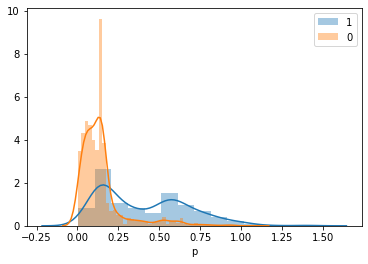

In [73]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
   'tweedie_variance_power': 1.349969119190657, 'max_bin': 212, 'subsample': 0.5774043241504451, 'subsample_freq': 0.7045972939301558, 
    'learning_rate': 0.16528226095247364, 'num_leaves': 4, 'feature_fraction': 0.9964784224971625,
    'bagging_freq': 6, 'min_child_samples': 23, 'lambda_l1': 0.016924825494747078, 'lambda_l2': 0.0008031532180312293
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.25 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p, label='1')
sns.distplot(off_df[off_df.jobflag_2==0].p, label='0')
plt.legend()

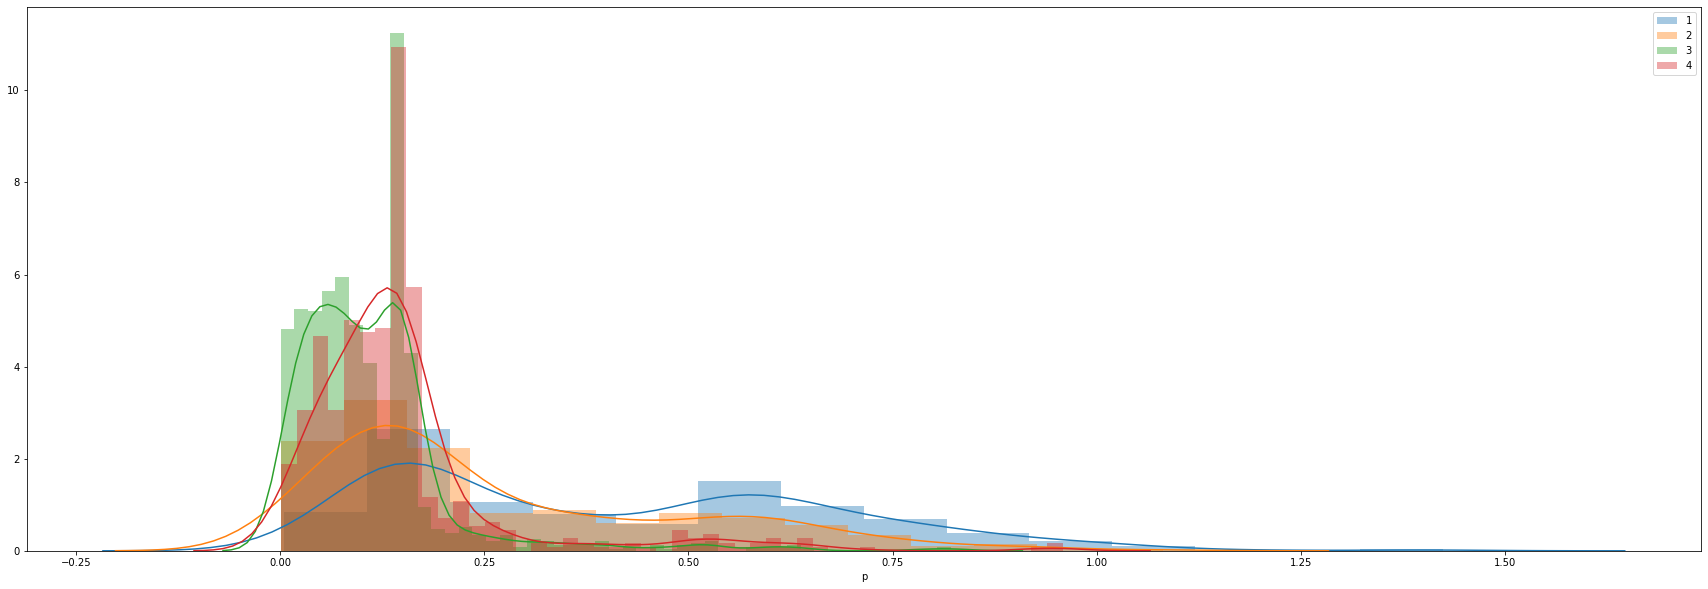

In [74]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()

#### label 3

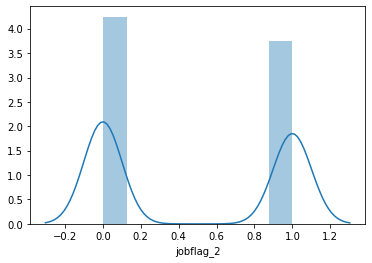

In [75]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
sns.distplot(train_df.jobflag_2)

In [76]:
class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'xentropy','metric': 'xentropy',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            #'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.01, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score

In [77]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_params)
print(study.best_value)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's cross_entropy: 0.495216	valid_1's cross_entropy: 0.559063
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.491103	valid_1's cross_entropy: 0.506429
Early stopping, best iteration is:
[746]	training's cross_entropy: 0.477811	valid_1's cross_entropy: 0.503008
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	training's cross_entropy: 0.509568	valid_1's cross_entropy: 0.518695
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.483741	valid_1's cross_entropy: 0.538038
Early stopping, best iteration is:
[611]	training's cross_entropy: 0.476777	valid_1's cross_entropy: 0.536023
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.479905	valid_1's cross_entropy: 0.558278
Early stopping, best iter

[I 2020-08-19 16:44:09,288] Finished trial#0 with value: 0.40578736997750114 with parameters: {'max_bin': 69, 'subsample': 0.45793462449008193, 'subsample_freq': 0.606724098486855, 'learning_rate': 0.03557145755283925, 'num_leaves': 4, 'feature_fraction': 0.9767715103318944, 'bagging_freq': 2, 'min_child_samples': 37, 'lambda_l1': 0.01600464891062445, 'lambda_l2': 0.9643399616869357}. Best is trial#0 with value: 0.40578736997750114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's cross_entropy: 0.47867	valid_1's cross_entropy: 0.550514
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[162]	training's cross_entropy: 0.461213	valid_1's cross_entropy: 0.494873
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's cross_entropy: 0.483786	valid_1's cross_entropy: 0.516585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[249]	training's cross_entropy: 0.429047	valid_1's cross_entropy: 0.526635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's cross_entropy: 0.477127	valid_1's cross_entropy: 0.543775


[I 2020-08-19 16:44:17,581] Finished trial#1 with value: 0.39800036961125573 with parameters: {'max_bin': 89, 'subsample': 0.833594387968871, 'subsample_freq': 0.449581812593359, 'learning_rate': 0.060070804400389005, 'num_leaves': 9, 'feature_fraction': 0.6560969900015654, 'bagging_freq': 1, 'min_child_samples': 51, 'lambda_l1': 0.013234448625674477, 'lambda_l2': 0.004477251137735531}. Best is trial#1 with value: 0.39800036961125573.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's cross_entropy: 0.460351	valid_1's cross_entropy: 0.543053
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.418634	valid_1's cross_entropy: 0.491159
Early stopping, best iteration is:
[318]	training's cross_entropy: 0.445394	valid_1's cross_entropy: 0.489086
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's cross_entropy: 0.470223	valid_1's cross_entropy: 0.513369
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.407815	valid_1's cross_entropy: 0.526321
Early stopping, best iteration is:
[372]	training's cross_entropy: 0.426286	valid_1's cross_entropy: 0.521761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's cross_entropy: 0.455443	valid_1's cross_entropy:

[I 2020-08-19 16:44:25,915] Finished trial#2 with value: 0.3946168984587869 with parameters: {'max_bin': 146, 'subsample': 0.8539811323392381, 'subsample_freq': 0.6337802529895691, 'learning_rate': 0.0558141959278937, 'num_leaves': 6, 'feature_fraction': 0.9049751888082742, 'bagging_freq': 3, 'min_child_samples': 40, 'lambda_l1': 0.021298295635160912, 'lambda_l2': 0.6441245421678783}. Best is trial#2 with value: 0.3946168984587869.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's cross_entropy: 0.450072	valid_1's cross_entropy: 0.544758
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's cross_entropy: 0.431781	valid_1's cross_entropy: 0.483421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's cross_entropy: 0.477626	valid_1's cross_entropy: 0.506158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's cross_entropy: 0.443091	valid_1's cross_entropy: 0.527686
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's cross_entropy: 0.461363	valid_1's cross_entropy: 0.528103


[I 2020-08-19 16:44:34,254] Finished trial#3 with value: 0.390702169885951 with parameters: {'max_bin': 274, 'subsample': 0.8422173930308399, 'subsample_freq': 0.5876959234466697, 'learning_rate': 0.06702463920038904, 'num_leaves': 7, 'feature_fraction': 0.9617607769952703, 'bagging_freq': 4, 'min_child_samples': 38, 'lambda_l1': 0.0007188784142195249, 'lambda_l2': 0.9112475396534339}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's cross_entropy: 0.538385	valid_1's cross_entropy: 0.596179
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's cross_entropy: 0.555467	valid_1's cross_entropy: 0.550513
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.537131	valid_1's cross_entropy: 0.550291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.528168	valid_1's cross_entropy: 0.589683
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's cross_entropy: 0.559765	valid_1's cross_entropy: 0.580035


[I 2020-08-19 16:44:42,325] Finished trial#4 with value: 0.4473642251876604 with parameters: {'max_bin': 157, 'subsample': 0.5805954041464205, 'subsample_freq': 0.8065512908963257, 'learning_rate': 0.4368947986494444, 'num_leaves': 5, 'feature_fraction': 0.5837899821260211, 'bagging_freq': 5, 'min_child_samples': 82, 'lambda_l1': 0.00019080420370097933, 'lambda_l2': 0.01193699043026093}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.486696	valid_1's cross_entropy: 0.549694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's cross_entropy: 0.435938	valid_1's cross_entropy: 0.494007
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's cross_entropy: 0.471741	valid_1's cross_entropy: 0.515977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	training's cross_entropy: 0.43309	valid_1's cross_entropy: 0.525531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's cross_entropy: 0.456066	valid_1's cross_entropy: 0.53096


[I 2020-08-19 16:44:50,552] Finished trial#5 with value: 0.3948383699867711 with parameters: {'max_bin': 80, 'subsample': 0.8794852711011293, 'subsample_freq': 0.8094972754129907, 'learning_rate': 0.0996693068544663, 'num_leaves': 7, 'feature_fraction': 0.7440000282509497, 'bagging_freq': 5, 'min_child_samples': 46, 'lambda_l1': 0.00031801475657422334, 'lambda_l2': 0.0012504862252547548}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.485811	valid_1's cross_entropy: 0.547884
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.454566	valid_1's cross_entropy: 0.489313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's cross_entropy: 0.480352	valid_1's cross_entropy: 0.514903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's cross_entropy: 0.431095	valid_1's cross_entropy: 0.52809
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.446523	valid_1's cross_entropy: 0.540214


[I 2020-08-19 16:44:58,729] Finished trial#6 with value: 0.3966357924027197 with parameters: {'max_bin': 65, 'subsample': 0.6027218155395333, 'subsample_freq': 0.5552436540564494, 'learning_rate': 0.1962843152699858, 'num_leaves': 7, 'feature_fraction': 0.8147015887927993, 'bagging_freq': 4, 'min_child_samples': 33, 'lambda_l1': 0.03756757134365662, 'lambda_l2': 0.5428432651630467}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.500238	valid_1's cross_entropy: 0.56312
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's cross_entropy: 0.510939	valid_1's cross_entropy: 0.51714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.525552	valid_1's cross_entropy: 0.526348
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's cross_entropy: 0.478346	valid_1's cross_entropy: 0.541488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's cross_entropy: 0.510392	valid_1's cross_entropy: 0.559012


[I 2020-08-19 16:45:06,752] Finished trial#7 with value: 0.4167255297474987 with parameters: {'max_bin': 279, 'subsample': 0.8840943152449421, 'subsample_freq': 0.7530735562497559, 'learning_rate': 0.45892731173969653, 'num_leaves': 4, 'feature_fraction': 0.7511972559303879, 'bagging_freq': 6, 'min_child_samples': 86, 'lambda_l1': 0.00017587964187336044, 'lambda_l2': 0.0014105075009747114}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's cross_entropy: 0.482965	valid_1's cross_entropy: 0.567911
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's cross_entropy: 0.493217	valid_1's cross_entropy: 0.521379
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's cross_entropy: 0.510401	valid_1's cross_entropy: 0.534733
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.496067	valid_1's cross_entropy: 0.544689
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's cross_entropy: 0.511114	valid_1's cross_entropy: 0.562638


[I 2020-08-19 16:45:14,827] Finished trial#8 with value: 0.42051417100178234 with parameters: {'max_bin': 227, 'subsample': 0.644573496752963, 'subsample_freq': 0.5398351644556005, 'learning_rate': 0.23178807259002607, 'num_leaves': 7, 'feature_fraction': 0.4935233027676739, 'bagging_freq': 5, 'min_child_samples': 69, 'lambda_l1': 0.007194854093680446, 'lambda_l2': 0.0011606205205263666}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	training's cross_entropy: 0.540357	valid_1's cross_entropy: 0.589694
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.529924	valid_1's cross_entropy: 0.570138
Early stopping, best iteration is:
[506]	training's cross_entropy: 0.529806	valid_1's cross_entropy: 0.569352
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's cross_entropy: 0.554277	valid_1's cross_entropy: 0.551325
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.554045	valid_1's cross_entropy: 0.587125
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.524815	valid_1's cross_entropy: 0.593905
Early stopping, best iteration is:
[351]	training's cross_entropy: 0.533578	valid_1's cross_entropy: 

[I 2020-08-19 16:45:23,113] Finished trial#9 with value: 0.4524378782074027 with parameters: {'max_bin': 108, 'subsample': 0.4962018395491093, 'subsample_freq': 0.6773100767224794, 'learning_rate': 0.08100890562794201, 'num_leaves': 8, 'feature_fraction': 0.7312832191155205, 'bagging_freq': 1, 'min_child_samples': 85, 'lambda_l1': 0.21598097338968833, 'lambda_l2': 0.0018109266106974078}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.443476	valid_1's cross_entropy: 0.545391
Early stopping, best iteration is:
[497]	training's cross_entropy: 0.443847	valid_1's cross_entropy: 0.545295
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.458649	valid_1's cross_entropy: 0.493644
[1000]	training's cross_entropy: 0.418237	valid_1's cross_entropy: 0.482898
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.394948	valid_1's cross_entropy: 0.480171
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.450584	valid_1's cross_entropy: 0.506802
Early stopping, best iteration is:
[392]	training's cross_entropy: 0.464655	valid_1's cross_entropy: 0.504874
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.448423	valid_1's cross_entropy: 0.527449
[1000]	training's cross_entropy:

[I 2020-08-19 16:45:33,179] Finished trial#10 with value: 0.386887575618747 with parameters: {'max_bin': 291, 'subsample': 0.7411226310712622, 'subsample_freq': 0.4179435776857794, 'learning_rate': 0.03291545577258209, 'num_leaves': 10, 'feature_fraction': 0.9995107864313896, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 3.614933933414213, 'lambda_l2': 9.428483837901446}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.453904	valid_1's cross_entropy: 0.546008
Early stopping, best iteration is:
[464]	training's cross_entropy: 0.457797	valid_1's cross_entropy: 0.545679
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.468022	valid_1's cross_entropy: 0.49812
[1000]	training's cross_entropy: 0.432176	valid_1's cross_entropy: 0.48764
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.411523	valid_1's cross_entropy: 0.483599
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.460996	valid_1's cross_entropy: 0.508161
Early stopping, best iteration is:
[396]	training's cross_entropy: 0.472606	valid_1's cross_entropy: 0.506437
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.457377	valid_1's cross_entropy: 0.531593
[1000]	training's cross_entropy: 0

[I 2020-08-19 16:45:43,395] Finished trial#11 with value: 0.388499108359186 with parameters: {'max_bin': 299, 'subsample': 0.7404790828341139, 'subsample_freq': 0.42262730966262796, 'learning_rate': 0.033196309905365776, 'num_leaves': 10, 'feature_fraction': 0.9846765222195354, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 4.872737110769526, 'lambda_l2': 8.484635916417012}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.482991	valid_1's cross_entropy: 0.549396
Early stopping, best iteration is:
[496]	training's cross_entropy: 0.48299	valid_1's cross_entropy: 0.549396
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.499513	valid_1's cross_entropy: 0.514298
Early stopping, best iteration is:
[439]	training's cross_entropy: 0.500387	valid_1's cross_entropy: 0.514131
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.49756	valid_1's cross_entropy: 0.512862
Early stopping, best iteration is:
[379]	training's cross_entropy: 0.497995	valid_1's cross_entropy: 0.51278
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.498741	valid_1's cross_entropy: 0.545454
Early stopping, best iteration is:
[339]	training's cross_entropy: 0.498741	valid_1's cross_entropy: 0.545454
Training until 

[I 2020-08-19 16:45:52,138] Finished trial#12 with value: 0.4020949496508593 with parameters: {'max_bin': 228, 'subsample': 0.7429480182450166, 'subsample_freq': 0.4048417254979444, 'learning_rate': 0.0358989847206869, 'num_leaves': 10, 'feature_fraction': 0.8761160835741307, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 9.505274593336374, 'lambda_l2': 9.239625074529007}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.454386	valid_1's cross_entropy: 0.545626
[1000]	training's cross_entropy: 0.419328	valid_1's cross_entropy: 0.544343
Early stopping, best iteration is:
[840]	training's cross_entropy: 0.428257	valid_1's cross_entropy: 0.543151
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.470323	valid_1's cross_entropy: 0.497866
[1000]	training's cross_entropy: 0.435406	valid_1's cross_entropy: 0.487493
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.414912	valid_1's cross_entropy: 0.483227
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.462978	valid_1's cross_entropy: 0.50755
Early stopping, best iteration is:
[490]	training's cross_entropy: 0.463894	valid_1's cross_entropy: 0.50676
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0

[I 2020-08-19 16:46:02,192] Finished trial#13 with value: 0.387841469204931 with parameters: {'max_bin': 239, 'subsample': 0.7455723220524842, 'subsample_freq': 0.45128538746806635, 'learning_rate': 0.030455883603270183, 'num_leaves': 10, 'feature_fraction': 0.9980891229008615, 'bagging_freq': 7, 'min_child_samples': 6, 'lambda_l1': 4.514490239947275, 'lambda_l2': 8.748338624265907}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's cross_entropy: 0.448844	valid_1's cross_entropy: 0.538395
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.411845	valid_1's cross_entropy: 0.476596
Early stopping, best iteration is:
[510]	training's cross_entropy: 0.410582	valid_1's cross_entropy: 0.47555
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	training's cross_entropy: 0.456384	valid_1's cross_entropy: 0.502868
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.39974	valid_1's cross_entropy: 0.518898
Early stopping, best iteration is:
[368]	training's cross_entropy: 0.422057	valid_1's cross_entropy: 0.515619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's cross_entropy: 0.439008	valid_1's cross_entropy: 0

[I 2020-08-19 16:46:10,929] Finished trial#14 with value: 0.38284931886425 with parameters: {'max_bin': 230, 'subsample': 0.7434355819880598, 'subsample_freq': 0.4707541458410742, 'learning_rate': 0.030081004475256364, 'num_leaves': 9, 'feature_fraction': 0.8854610011629185, 'bagging_freq': 7, 'min_child_samples': 20, 'lambda_l1': 1.606856881091685, 'lambda_l2': 0.09690874856796858}. Best is trial#14 with value: 0.38284931886425.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's cross_entropy: 0.419964	valid_1's cross_entropy: 0.541405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's cross_entropy: 0.39874	valid_1's cross_entropy: 0.465416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.445716	valid_1's cross_entropy: 0.505019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.388411	valid_1's cross_entropy: 0.507595
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	training's cross_entropy: 0.390897	valid_1's cross_entropy: 0.517152


[I 2020-08-19 16:46:19,545] Finished trial#15 with value: 0.3804064954698263 with parameters: {'max_bin': 195, 'subsample': 0.6972953896520425, 'subsample_freq': 0.49678988054828166, 'learning_rate': 0.049265950429105, 'num_leaves': 9, 'feature_fraction': 0.8556194181412038, 'bagging_freq': 6, 'min_child_samples': 16, 'lambda_l1': 0.6866657672316028, 'lambda_l2': 0.0001609541716739769}. Best is trial#15 with value: 0.3804064954698263.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's cross_entropy: 0.427381	valid_1's cross_entropy: 0.536166
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's cross_entropy: 0.408926	valid_1's cross_entropy: 0.468679
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.45168	valid_1's cross_entropy: 0.505912
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's cross_entropy: 0.437267	valid_1's cross_entropy: 0.510024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's cross_entropy: 0.442165	valid_1's cross_entropy: 0.520417


[I 2020-08-19 16:46:28,121] Finished trial#16 with value: 0.3801850682920285 with parameters: {'max_bin': 192, 'subsample': 0.6777572274671563, 'subsample_freq': 0.5053743881802929, 'learning_rate': 0.04784042647126706, 'num_leaves': 9, 'feature_fraction': 0.8703507739859023, 'bagging_freq': 6, 'min_child_samples': 20, 'lambda_l1': 0.6188353259085337, 'lambda_l2': 0.0001493411043195126}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's cross_entropy: 0.437271	valid_1's cross_entropy: 0.538202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's cross_entropy: 0.413192	valid_1's cross_entropy: 0.466735
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.454682	valid_1's cross_entropy: 0.508415
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	training's cross_entropy: 0.439134	valid_1's cross_entropy: 0.51394
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's cross_entropy: 0.444362	valid_1's cross_entropy: 0.520057


[I 2020-08-19 16:46:36,642] Finished trial#17 with value: 0.38148618578270266 with parameters: {'max_bin': 192, 'subsample': 0.6789424415363842, 'subsample_freq': 0.5127907162424672, 'learning_rate': 0.04602902701632808, 'num_leaves': 9, 'feature_fraction': 0.809685563085773, 'bagging_freq': 6, 'min_child_samples': 21, 'lambda_l1': 0.5288510607398745, 'lambda_l2': 0.00010066164177144338}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.478697	valid_1's cross_entropy: 0.546536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's cross_entropy: 0.436704	valid_1's cross_entropy: 0.480392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's cross_entropy: 0.478804	valid_1's cross_entropy: 0.521888
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's cross_entropy: 0.37778	valid_1's cross_entropy: 0.525853
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's cross_entropy: 0.46317	valid_1's cross_entropy: 0.531079


[I 2020-08-19 16:46:44,853] Finished trial#18 with value: 0.3934529920626735 with parameters: {'max_bin': 192, 'subsample': 0.5238877136721924, 'subsample_freq': 0.6853882262306812, 'learning_rate': 0.15682351603221328, 'num_leaves': 8, 'feature_fraction': 0.8207107631602235, 'bagging_freq': 6, 'min_child_samples': 21, 'lambda_l1': 0.10881275837036385, 'lambda_l2': 0.00011419379734749353}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.491917	valid_1's cross_entropy: 0.564605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's cross_entropy: 0.48639	valid_1's cross_entropy: 0.50401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's cross_entropy: 0.508513	valid_1's cross_entropy: 0.522445
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.495897	valid_1's cross_entropy: 0.54872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.502141	valid_1's cross_entropy: 0.560463


[I 2020-08-19 16:46:52,962] Finished trial#19 with value: 0.4148393216977305 with parameters: {'max_bin': 137, 'subsample': 0.6844550072255083, 'subsample_freq': 0.500554150800155, 'learning_rate': 0.11553609300381686, 'num_leaves': 8, 'feature_fraction': 0.6377942201885717, 'bagging_freq': 6, 'min_child_samples': 64, 'lambda_l1': 0.8691547086641713, 'lambda_l2': 0.00031085437950500186}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's cross_entropy: 0.412835	valid_1's cross_entropy: 0.534564
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.317793	valid_1's cross_entropy: 0.481951
Early stopping, best iteration is:
[394]	training's cross_entropy: 0.344769	valid_1's cross_entropy: 0.476977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's cross_entropy: 0.408461	valid_1's cross_entropy: 0.492498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[274]	training's cross_entropy: 0.372576	valid_1's cross_entropy: 0.507464
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.41445	valid_1's cross_entropy: 0.508973


[I 2020-08-19 16:47:01,626] Finished trial#20 with value: 0.3775967713339632 with parameters: {'max_bin': 186, 'subsample': 0.7887698242159101, 'subsample_freq': 0.5646723932920396, 'learning_rate': 0.04637136295856085, 'num_leaves': 9, 'feature_fraction': 0.9133548543251212, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.14609765523566165, 'lambda_l2': 0.00030682025722287876}. Best is trial#20 with value: 0.3775967713339632.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.446047	valid_1's cross_entropy: 0.536256
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.32167	valid_1's cross_entropy: 0.478851
Early stopping, best iteration is:
[350]	training's cross_entropy: 0.35843	valid_1's cross_entropy: 0.47217
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's cross_entropy: 0.436881	valid_1's cross_entropy: 0.49621
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.375605	valid_1's cross_entropy: 0.512593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's cross_entropy: 0.412502	valid_1's cross_entropy: 0.513957


[I 2020-08-19 16:47:10,189] Finished trial#21 with value: 0.3747412585075232 with parameters: {'max_bin': 185, 'subsample': 0.7992767466278955, 'subsample_freq': 0.5565079937523403, 'learning_rate': 0.04859189697358115, 'num_leaves': 9, 'feature_fraction': 0.9128260918056069, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.21168252667523507, 'lambda_l2': 0.00032064440714442215}. Best is trial#21 with value: 0.3747412585075232.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.416597	valid_1's cross_entropy: 0.539421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's cross_entropy: 0.414125	valid_1's cross_entropy: 0.478604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.429284	valid_1's cross_entropy: 0.494326
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's cross_entropy: 0.405703	valid_1's cross_entropy: 0.510339
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's cross_entropy: 0.407998	valid_1's cross_entropy: 0.510948


[I 2020-08-19 16:47:18,595] Finished trial#22 with value: 0.3766901482411636 with parameters: {'max_bin': 176, 'subsample': 0.7980289024956703, 'subsample_freq': 0.5768805101981231, 'learning_rate': 0.07703411464126991, 'num_leaves': 8, 'feature_fraction': 0.9282509590541356, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.09680317095486797, 'lambda_l2': 0.0005288595915991783}. Best is trial#21 with value: 0.3747412585075232.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's cross_entropy: 0.442116	valid_1's cross_entropy: 0.534053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.383424	valid_1's cross_entropy: 0.46708
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's cross_entropy: 0.408609	valid_1's cross_entropy: 0.492473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[222]	training's cross_entropy: 0.351785	valid_1's cross_entropy: 0.498527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's cross_entropy: 0.391892	valid_1's cross_entropy: 0.507669


[I 2020-08-19 16:47:27,021] Finished trial#23 with value: 0.3716071869699359 with parameters: {'max_bin': 167, 'subsample': 0.7993531884430555, 'subsample_freq': 0.580941261152367, 'learning_rate': 0.07763917034617014, 'num_leaves': 8, 'feature_fraction': 0.9274211572664092, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.08505696157696122, 'lambda_l2': 0.00042538040698567796}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's cross_entropy: 0.470276	valid_1's cross_entropy: 0.541664
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.325853	valid_1's cross_entropy: 0.489814
Early stopping, best iteration is:
[357]	training's cross_entropy: 0.358695	valid_1's cross_entropy: 0.476977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.435506	valid_1's cross_entropy: 0.506636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.432712	valid_1's cross_entropy: 0.516047
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.433738	valid_1's cross_entropy: 0.523454


[I 2020-08-19 16:47:35,405] Finished trial#24 with value: 0.38783085173294013 with parameters: {'max_bin': 164, 'subsample': 0.7909812956436963, 'subsample_freq': 0.6436076240487602, 'learning_rate': 0.0823995684060765, 'num_leaves': 8, 'feature_fraction': 0.9342646826142589, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.05890475831963915, 'lambda_l2': 0.0005053046355955434}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.456401	valid_1's cross_entropy: 0.544559
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.372732	valid_1's cross_entropy: 0.48158
Early stopping, best iteration is:
[359]	training's cross_entropy: 0.39715	valid_1's cross_entropy: 0.474057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.452383	valid_1's cross_entropy: 0.504474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.445262	valid_1's cross_entropy: 0.516635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.43154	valid_1's cross_entropy: 0.524342


[I 2020-08-19 16:47:43,682] Finished trial#25 with value: 0.38554042062140237 with parameters: {'max_bin': 128, 'subsample': 0.8114310114745714, 'subsample_freq': 0.7015945910026815, 'learning_rate': 0.07551649221957535, 'num_leaves': 6, 'feature_fraction': 0.9358899661107448, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.002149898735538845, 'lambda_l2': 0.009987052692785242}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.410101	valid_1's cross_entropy: 0.536112
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.361286	valid_1's cross_entropy: 0.463385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's cross_entropy: 0.417338	valid_1's cross_entropy: 0.491278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's cross_entropy: 0.374754	valid_1's cross_entropy: 0.504093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's cross_entropy: 0.391736	valid_1's cross_entropy: 0.505173


[I 2020-08-19 16:47:52,064] Finished trial#26 with value: 0.37162916545835484 with parameters: {'max_bin': 211, 'subsample': 0.8013596446261199, 'subsample_freq': 0.6232736476838467, 'learning_rate': 0.10102219759130328, 'num_leaves': 8, 'feature_fraction': 0.7827862121977133, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.18871992173322963, 'lambda_l2': 0.0005165814318275235}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's cross_entropy: 0.439255	valid_1's cross_entropy: 0.537647
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.410381	valid_1's cross_entropy: 0.471277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's cross_entropy: 0.452466	valid_1's cross_entropy: 0.504014
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's cross_entropy: 0.412475	valid_1's cross_entropy: 0.516881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's cross_entropy: 0.419342	valid_1's cross_entropy: 0.518198


[I 2020-08-19 16:48:00,283] Finished trial#27 with value: 0.37984613567829884 with parameters: {'max_bin': 256, 'subsample': 0.8934969779072999, 'subsample_freq': 0.7235152053545577, 'learning_rate': 0.12610020005657488, 'num_leaves': 6, 'feature_fraction': 0.8052003889583179, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 0.23216660176073312, 'lambda_l2': 0.003953253722722586}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.39142	valid_1's cross_entropy: 0.539043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's cross_entropy: 0.367296	valid_1's cross_entropy: 0.468274
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's cross_entropy: 0.405021	valid_1's cross_entropy: 0.495484
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's cross_entropy: 0.417975	valid_1's cross_entropy: 0.503319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's cross_entropy: 0.388118	valid_1's cross_entropy: 0.502705


[I 2020-08-19 16:48:08,720] Finished trial#28 with value: 0.37523243241955073 with parameters: {'max_bin': 117, 'subsample': 0.7724876509272963, 'subsample_freq': 0.8999332470830883, 'learning_rate': 0.10020389340647005, 'num_leaves': 8, 'feature_fraction': 0.776588475722103, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.30579775067652387, 'lambda_l2': 0.058561126034442725}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.496478	valid_1's cross_entropy: 0.556206
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's cross_entropy: 0.47039	valid_1's cross_entropy: 0.497893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.504569	valid_1's cross_entropy: 0.520967
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.466661	valid_1's cross_entropy: 0.536337
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's cross_entropy: 0.489087	valid_1's cross_entropy: 0.554836


[I 2020-08-19 16:48:16,840] Finished trial#29 with value: 0.4083821510803246 with parameters: {'max_bin': 209, 'subsample': 0.8212789233102445, 'subsample_freq': 0.5968109373647247, 'learning_rate': 0.15740988842325934, 'num_leaves': 8, 'feature_fraction': 0.6703572477304814, 'bagging_freq': 2, 'min_child_samples': 60, 'lambda_l1': 0.007583330981515316, 'lambda_l2': 0.00047774904016584626}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's cross_entropy: 0.402507	valid_1's cross_entropy: 0.528776
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.319101	valid_1's cross_entropy: 0.466425
Early stopping, best iteration is:
[393]	training's cross_entropy: 0.348152	valid_1's cross_entropy: 0.463257
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.312297	valid_1's cross_entropy: 0.499347
Early stopping, best iteration is:
[304]	training's cross_entropy: 0.370346	valid_1's cross_entropy: 0.48854
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.311023	valid_1's cross_entropy: 0.504016
Early stopping, best iteration is:
[342]	training's cross_entropy: 0.355677	valid_1's cross_entropy: 0.498112
Training until validation scores don't improve for 200 rounds
Early stopping, best itera

[I 2020-08-19 16:48:25,617] Finished trial#30 with value: 0.36840550364829505 with parameters: {'max_bin': 214, 'subsample': 0.8554191543036495, 'subsample_freq': 0.6223487645637746, 'learning_rate': 0.038865714262698574, 'num_leaves': 9, 'feature_fraction': 0.7031776848669038, 'bagging_freq': 3, 'min_child_samples': 9, 'lambda_l1': 0.05862936632035996, 'lambda_l2': 0.003173181679783918}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[293]	training's cross_entropy: 0.36544	valid_1's cross_entropy: 0.531955
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323244	valid_1's cross_entropy: 0.45943
Early stopping, best iteration is:
[454]	training's cross_entropy: 0.334369	valid_1's cross_entropy: 0.458555
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.314907	valid_1's cross_entropy: 0.507933
Early stopping, best iteration is:
[315]	training's cross_entropy: 0.368099	valid_1's cross_entropy: 0.493826
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.380327	valid_1's cross_entropy: 0.498763
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's cross_entropy: 0.371802	valid_1's cross_entropy: 0

[I 2020-08-19 16:48:34,489] Finished trial#31 with value: 0.3698893732186056 with parameters: {'max_bin': 210, 'subsample': 0.8458939760559397, 'subsample_freq': 0.6185514752411294, 'learning_rate': 0.03913594716462846, 'num_leaves': 9, 'feature_fraction': 0.7009592167408929, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.03880284596615796, 'lambda_l2': 0.004304429542236647}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[202]	training's cross_entropy: 0.405631	valid_1's cross_entropy: 0.531924
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.326332	valid_1's cross_entropy: 0.464135
Early stopping, best iteration is:
[474]	training's cross_entropy: 0.33286	valid_1's cross_entropy: 0.464047
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.318709	valid_1's cross_entropy: 0.504208
Early stopping, best iteration is:
[305]	training's cross_entropy: 0.374835	valid_1's cross_entropy: 0.49527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	training's cross_entropy: 0.384484	valid_1's cross_entropy: 0.498138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[295]	training's cross_entropy: 0.375752	valid_1's cross_entropy: 0

[I 2020-08-19 16:48:43,236] Finished trial#32 with value: 0.3694287491372147 with parameters: {'max_bin': 211, 'subsample': 0.8574418299135007, 'subsample_freq': 0.6361163536016576, 'learning_rate': 0.03849868561962392, 'num_leaves': 9, 'feature_fraction': 0.598668945510947, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.04783187312347933, 'lambda_l2': 0.003611739535719462}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.307589	valid_1's cross_entropy: 0.544383
Early stopping, best iteration is:
[308]	training's cross_entropy: 0.361949	valid_1's cross_entropy: 0.531577
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323169	valid_1's cross_entropy: 0.462726
Early stopping, best iteration is:
[533]	training's cross_entropy: 0.315337	valid_1's cross_entropy: 0.461345
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.316117	valid_1's cross_entropy: 0.493118
Early stopping, best iteration is:
[349]	training's cross_entropy: 0.358545	valid_1's cross_entropy: 0.483333
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.31602	valid_1's cross_entropy: 0.503633
Early stopping, best iteration is:
[348]	training's cross_entropy: 0.356422	valid_1's cross_entropy: 0.498243
Training unti

[I 2020-08-19 16:48:52,231] Finished trial#33 with value: 0.3689601278616238 with parameters: {'max_bin': 213, 'subsample': 0.8648436469082202, 'subsample_freq': 0.6621270336530108, 'learning_rate': 0.03789924915237349, 'num_leaves': 9, 'feature_fraction': 0.5830721511477469, 'bagging_freq': 3, 'min_child_samples': 9, 'lambda_l1': 0.013457176514273313, 'lambda_l2': 0.004110816929682072}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's cross_entropy: 0.384523	valid_1's cross_entropy: 0.528925
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.306384	valid_1's cross_entropy: 0.451507
Early stopping, best iteration is:
[591]	training's cross_entropy: 0.284841	valid_1's cross_entropy: 0.45018
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.29913	valid_1's cross_entropy: 0.492515
Early stopping, best iteration is:
[330]	training's cross_entropy: 0.350539	valid_1's cross_entropy: 0.484816
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.297538	valid_1's cross_entropy: 0.499572
Early stopping, best iteration is:
[376]	training's cross_entropy: 0.333178	valid_1's cross_entropy: 0.496361
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entr

[I 2020-08-19 16:49:01,322] Finished trial#34 with value: 0.36488458096691967 with parameters: {'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497, 'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257, 'lambda_l2': 0.01551615159581271}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's cross_entropy: 0.425118	valid_1's cross_entropy: 0.534346
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.357758	valid_1's cross_entropy: 0.469694
Early stopping, best iteration is:
[406]	training's cross_entropy: 0.375941	valid_1's cross_entropy: 0.468223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.452046	valid_1's cross_entropy: 0.507774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's cross_entropy: 0.417057	valid_1's cross_entropy: 0.515903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	training's cross_entropy: 0.416315	valid_1's cross_entropy: 0.51412


[I 2020-08-19 16:49:09,866] Finished trial#35 with value: 0.3795918273747834 with parameters: {'max_bin': 253, 'subsample': 0.866714355070462, 'subsample_freq': 0.6640921162444591, 'learning_rate': 0.03866391113908777, 'num_leaves': 10, 'feature_fraction': 0.5370485345498898, 'bagging_freq': 1, 'min_child_samples': 24, 'lambda_l1': 0.013478449400510198, 'lambda_l2': 0.019776787485369977}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.481129	valid_1's cross_entropy: 0.549585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[238]	training's cross_entropy: 0.42639	valid_1's cross_entropy: 0.494936
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.477659	valid_1's cross_entropy: 0.517127
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's cross_entropy: 0.422143	valid_1's cross_entropy: 0.522217
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's cross_entropy: 0.454573	valid_1's cross_entropy: 0.53299


[I 2020-08-19 16:49:18,228] Finished trial#36 with value: 0.3962701092863106 with parameters: {'max_bin': 248, 'subsample': 0.8963345112588847, 'subsample_freq': 0.7484188624915529, 'learning_rate': 0.057748017766923114, 'num_leaves': 10, 'feature_fraction': 0.6006225419409983, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 0.0025608501677136407, 'lambda_l2': 0.00837315371960075}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.578756	valid_1's cross_entropy: 0.60792
Early stopping, best iteration is:
[335]	training's cross_entropy: 0.580901	valid_1's cross_entropy: 0.607325
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.583434	valid_1's cross_entropy: 0.601094
Early stopping, best iteration is:
[365]	training's cross_entropy: 0.586067	valid_1's cross_entropy: 0.599615
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.590057	valid_1's cross_entropy: 0.566623
[1000]	training's cross_entropy: 0.581394	valid_1's cross_entropy: 0.562578
Early stopping, best iteration is:
[1002]	training's cross_entropy: 0.581438	valid_1's cross_entropy: 0.562474
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.584673	valid_1's cross_entropy: 0.599287
[1000]	training's cross_entropy: 0.577421	vali

[I 2020-08-19 16:49:26,653] Finished trial#37 with value: 0.4708666122153212 with parameters: {'max_bin': 265, 'subsample': 0.4015957624636153, 'subsample_freq': 0.6483145693696912, 'learning_rate': 0.03843173193222836, 'num_leaves': 10, 'feature_fraction': 0.5572926162775009, 'bagging_freq': 3, 'min_child_samples': 99, 'lambda_l1': 0.02504264345751091, 'lambda_l2': 0.03429607003734566}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's cross_entropy: 0.466088	valid_1's cross_entropy: 0.548369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's cross_entropy: 0.455674	valid_1's cross_entropy: 0.496696
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's cross_entropy: 0.467719	valid_1's cross_entropy: 0.521434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's cross_entropy: 0.433924	valid_1's cross_entropy: 0.516924
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.482913	valid_1's cross_entropy: 0.539152


[I 2020-08-19 16:49:34,784] Finished trial#38 with value: 0.3975250025683422 with parameters: {'max_bin': 207, 'subsample': 0.8532551104583521, 'subsample_freq': 0.711473626973623, 'learning_rate': 0.32437095727156134, 'num_leaves': 9, 'feature_fraction': 0.42792354860372506, 'bagging_freq': 2, 'min_child_samples': 40, 'lambda_l1': 0.005612437518393461, 'lambda_l2': 0.0025729421718912533}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's cross_entropy: 0.376675	valid_1's cross_entropy: 0.527869
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.2722	valid_1's cross_entropy: 0.458098
Early stopping, best iteration is:
[331]	training's cross_entropy: 0.324105	valid_1's cross_entropy: 0.453899
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.348543	valid_1's cross_entropy: 0.484979
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.262389	valid_1's cross_entropy: 0.507038
Early stopping, best iteration is:
[331]	training's cross_entropy: 0.314235	valid_1's cross_entropy: 0.499458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[299]	training's cross_entropy: 0.325775	valid_1's cross_entropy: 0

[I 2020-08-19 16:49:43,699] Finished trial#39 with value: 0.36748863329316805 with parameters: {'max_bin': 241, 'subsample': 0.8997161940135402, 'subsample_freq': 0.7732027480995026, 'learning_rate': 0.05847523074940601, 'num_leaves': 9, 'feature_fraction': 0.4949078470338101, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.01769374991744592, 'lambda_l2': 0.15640587310843118}. Best is trial#34 with value: 0.36488458096691967.


{'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497, 'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257, 'lambda_l2': 0.01551615159581271}
0.36488458096691967



        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[243]	training's cross_entropy: 0.375384	valid_1's cross_entropy: 0.532443
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.305185	valid_1's cross_entropy: 0.453266
Early stopping, best iteration is:
[547]	training's cross_entropy: 0.293723	valid_1's cross_entropy: 0.452991
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.299081	valid_1's cross_entropy: 0.491491
Early stopping, best iteration is:
[348]	training's cross_entropy: 0.344157	valid_1's cross_entropy: 0.485063
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.297967	valid_1's cross_entropy: 0.499049
Early stopping, best iteration is:
[392]	training's cross_entropy: 0.327566	valid_1's cross_entropy: 0.495896
Training until validation sco

[3]	training's cross_entropy: 0.689651	valid_1's cross_entropy: 0.692553

                
                Train Null Importance   17
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's cross_entropy: 0.680886	valid_1's cross_entropy: 0.690888
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692054	valid_1's cross_entropy: 0.693223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	training's cross_entropy: 0.689623	valid_1's cross_entropy: 0.693021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's cross_entropy: 0.686282	valid_1's cross_entropy: 0.692279
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.678084	valid_1's cros

[2]	training's cross_entropy: 0.690865	valid_1's cross_entropy: 0.693641
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's cross_entropy: 0.685344	valid_1's cross_entropy: 0.690469
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692122	valid_1's cross_entropy: 0.693602
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's cross_entropy: 0.688733	valid_1's cross_entropy: 0.693191
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.690838	valid_1's cross_entropy: 0.692754

                
                Train Null Importance   35
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's cross_entropy: 0.656645	valid_1's cross

['data', 'machinelearn', 'softwar', 'interfac', 'busi', 'analyt', 'model', 'server', 'test', 'scrum', 'algorithm', 'clinic', 'troubleshoot', 'field', 'engag', 'client', 'mechan', 'dashboard', 'embed', 'front', 'equip', 'prototyp', 'simul', 'market', 'scale', 'backend', 'go', 'requir', 'sale', 'electron', 'dataset', 'applic', 'term', 'throughout', 'unit', 'system', 'access', 'consult', 'continu', 'research', 'call', 'profession', 'cultur', 'engin', 'can', 'tool', 'manufactur', 'member', 'deep', 'interpret', 'present', 'learn', 'explor', 'custom', 'scientist', 'debug', 'support', 'make', 'new', 'set', 'abil', 'supplier', 'safeti', 'statu', 'leverag', 'program', 'review', 'initi', 'databas', 'specif', 'control', 'transform', 'task', 'find', 'site', 'configur', 'desir', 'non', 'opportun', 'insight', 'establish', 'fix', 'job', 'commun', 'proactiv', 'relat', 'contribut', 'qualiti', 'problem', 'gap', 'partner', 'role', 'agil', 'assign', 'goal', 'predict', 'code', 'technic', 'collect', 'person

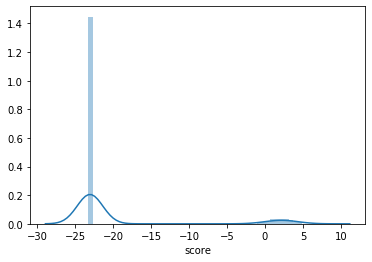

In [80]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
    
        'objective': 'xentropy','metric': 'xentropy',

#            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497,
    'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257,
    'lambda_l2': 0.01551615159581271
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)

null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [81]:
feature = ['data', 'machinelearn', 'softwar', 'interfac', 'busi', 'analyt', 'model', 'server', 'test', 'scrum', 'algorithm', 'clinic',
           'troubleshoot', 'field', 'engag', 'client', 'mechan', 'dashboard', 'embed', 'front', 'equip', 'prototyp', 'simul', 'market',
           'scale', 'backend', 'go', 'requir', 'sale', 'electron', 'dataset', 'applic', 'term', 'throughout', 'unit', 'system', 'access',
           'consult', 'continu', 'research', 'call', 'profession', 'cultur', 'engin', 'can', 'tool', 'manufactur', 'member', 'deep',
           'interpret', 'present', 'learn', 'explor', 'custom', 'scientist', 'debug', 'support', 'make', 'new', 'set', 'abil', 'supplier',
           'safeti', 'statu', 'leverag', 'program', 'review', 'initi', 'databas', 'specif', 'control', 'transform', 'task', 'find', 'site',
           'configur', 'desir', 'non', 'opportun', 'insight', 'establish', 'fix', 'job', 'commun', 'proactiv', 'relat', 'contribut', 
           'qualiti', 'problem', 'gap', 'partner', 'role', 'agil', 'assign', 'goal', 'predict', 'code', 'technic', 'collect', 'person',
           'stakehold', 'complianc', 'product', 'commiss', 'defin', 'window', 'secur', 'relev', 'multipl', 'time', 'analys', 'across', 
           'direct', 'adher', 'lead', 'sourc', 'python', 'approach', 'self', 'platform', 'interact', 'within', 'healthcar', 'schedul', 
           'document', 'organ', 'action', 'best', 'pipelin', 'may', 'modifi', 'respons', 'facilit', 'develop', 'expert', 'depend', 'open', 
           'stori', 'educ', 'servic', 'appropri', 'ai', 'caus', 'collabor', 'perform', 'solut', 'assembl', 'practic', 'mobil', 'monitor',
           'progress', 'area', 'latest', 'produc', 'issu', 'email', 'duti', 'larg', 'team', 'assist', 'audienc', 'enabl', 'regular',
           'analysi', 'network', 'improv', 'abl', 'implement', 'base', 'necessari', 'propos', 'via', 'ongo', 'leadership', 'will', 'increas',
           'confer', 'key', 'deploy', 'migrat', 'price', 'deliver', 'coordin', 'independ', 'ad', 'guid', 'meet', 'matter', 'environ',
           'strateg', 'optim', 'conduct', 'hardwar', 'resolv', 'particip', 'share', 'identifi', 'construct', 'follow', 'prepar',
           'architectur', 'protocol', 'comput', 'referr', 'creation', 'disciplin', 'overal', 'net', 'java', 'address', 'work', 'potenti',
           'complex', 'script', 'evalu', 'repres', 'inform', 'microsoft', 'order', 'use', 'rigor', 'enterpris', 'ensur', 'sell', 'account',
           'activ', 'way', 'resourc', 'innov', 'intern', 'upgrad', 'travel', 'bug', 'estim', 'report', 'cloud', 'dynam', 'inspect', 'post',
           'well', 'leader', 'hoc', 'point', 'oper', 'demonstr', 'polici', 'act', 'group', 'capabl', 'guidanc', 'must', 'integr', 'root',
           'need', 'select', 'futur', 'critic', 'level', 'flow', 'technolog', 'resolut', 'date', 'consist', 'resid', 'project',
           'infrastructur', 'challeng', 'analyz', 'process', 'strong', 'high', 'architect', 'linux', 'help', 'detail', 'limit',
           'impact', 'relationship', 'design', 'appli', 'manner', 'promot', 'close', 'deliveri', 'enhanc', 'exist', 'methodolog', 'state',
           'skill', 'method', 'concept', 'knowledg', 'featur', 'mainten', 'focu', 'map', 'compon', 'current', 'languag', 'maintain', 
           'metric', 'excel', 'autom', 'plan', 'mission', 'differ', 'track', 'scienc', 'recommend', 'obtain', 'effect', 'understand',
           'provid', 'api', 'benefit', 'scalabl', 'techniqu', 'procedur', 'train', 'build', 'accur', 'translat', 'extract', 'form',
           'statist', 'manag', 'gener', 'suggest', 'updat', 'compani', 'verif', 'standard', 'reliabl', 'end', 'valid', 'effici', 'request',
           'solv', 'addit', 'domain', 'life', 'vehicl', 'execut', 'aw', 'experi', 'includ', 'drive', 'prospect', 'pre', 'assess', 'highli',
           'parti', 'vendor', 'etc', 'valu', 'queri', 'risk', 'discuss', 'modul', 'stream', 'scope', 'good', 'result', 'function', 'complet',
           'releas', 'orient', 'extern', 'depth', 'coach', 'user', 'principl', 'capac', 'cycl', 'small', 'draw', 'write', 'success',
           'achiev', 'strategi', 'distribut', 'workflow', 'part', 'full', 'object', 'deliv', 'qa', 'measur', 'decis', 'instal', 'clearli',
           'verifi', 'version', 'contract', 'daili', 'util', 'expand', 'mentor', 'multi', 'agre', 'cost', 'log', 'explain', 'behavior',
           'avail', 'expertis', 'segment', 'defect', 'stack', 'partnership', 'medic', 'exploratori', 'accord', 'staff', 'escal', 'content',
           'definit', 'subject', 'variou', 'determin', 'creativ', 'run', 'input', 'visual', 'event', 'advanc', 'posit', 'senior', 'chang',
           'cross', 'vision', 'tune', 'stay', 'depart', 'framework', 'gather', 'idea', 'priorit', 'materi', 'question', 'qualifi', 'store',
           'failur', 'machin', 'hand', 'effort', 'rule', 'web', 'creat']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's cross_entropy: 0.489975	valid_1's cross_entropy: 0.559069
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's cross_entropy: 0.512333	valid_1's cross_entropy: 0.517024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's cross_entropy: 0.478698	valid_1's cross_entropy: 0.523833
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.478736	valid_1's cross_entropy: 0.546107
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's cross_entropy: 0.51108	valid_1's cross_entropy: 0.559371


[I 2020-08-19 17:00:01,655] Finished trial#0 with value: 0.4165631005994468 with parameters: {'max_bin': 133, 'subsample': 0.8081849274233037, 'subsample_freq': 0.46780682135273616, 'learning_rate': 0.20407279974731762, 'num_leaves': 9, 'feature_fraction': 0.7556632430975057, 'bagging_freq': 6, 'min_child_samples': 81, 'lambda_l1': 0.17902577039219927, 'lambda_l2': 0.001663603394398459}. Best is trial#0 with value: 0.4165631005994468.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's cross_entropy: 0.516863	valid_1's cross_entropy: 0.561912
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.467896	valid_1's cross_entropy: 0.503019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's cross_entropy: 0.493803	valid_1's cross_entropy: 0.522344
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's cross_entropy: 0.471798	valid_1's cross_entropy: 0.546724
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's cross_entropy: 0.518024	valid_1's cross_entropy: 0.562359


[I 2020-08-19 17:00:03,041] Finished trial#1 with value: 0.4141172058352686 with parameters: {'max_bin': 253, 'subsample': 0.579482905449797, 'subsample_freq': 0.5739844068502751, 'learning_rate': 0.21024586103270043, 'num_leaves': 10, 'feature_fraction': 0.7705810921941432, 'bagging_freq': 7, 'min_child_samples': 49, 'lambda_l1': 0.14936146358595923, 'lambda_l2': 0.27132105168458903}. Best is trial#1 with value: 0.4141172058352686.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.520254	valid_1's cross_entropy: 0.567401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.527159	valid_1's cross_entropy: 0.534979
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's cross_entropy: 0.535083	valid_1's cross_entropy: 0.527329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.505995	valid_1's cross_entropy: 0.543227
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's cross_entropy: 0.514707	valid_1's cross_entropy: 0.564532


[I 2020-08-19 17:00:04,268] Finished trial#2 with value: 0.42010237201344464 with parameters: {'max_bin': 261, 'subsample': 0.4841600754927747, 'subsample_freq': 0.4335970997108517, 'learning_rate': 0.362348714213001, 'num_leaves': 10, 'feature_fraction': 0.998117978444303, 'bagging_freq': 1, 'min_child_samples': 43, 'lambda_l1': 9.857210272653521, 'lambda_l2': 0.0013888782825075747}. Best is trial#1 with value: 0.4141172058352686.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.497724	valid_1's cross_entropy: 0.554448
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.419717	valid_1's cross_entropy: 0.505452
Early stopping, best iteration is:
[316]	training's cross_entropy: 0.447155	valid_1's cross_entropy: 0.498706
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.501145	valid_1's cross_entropy: 0.518168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[244]	training's cross_entropy: 0.452755	valid_1's cross_entropy: 0.53121
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's cross_entropy: 0.487664	valid_1's cross_entropy: 0.553256


[I 2020-08-19 17:00:05,752] Finished trial#3 with value: 0.4022155098299953 with parameters: {'max_bin': 167, 'subsample': 0.7999924738185837, 'subsample_freq': 0.7055873366230493, 'learning_rate': 0.06663011882283389, 'num_leaves': 8, 'feature_fraction': 0.5428520880252695, 'bagging_freq': 7, 'min_child_samples': 55, 'lambda_l1': 0.6001113925731489, 'lambda_l2': 1.058027489622013}. Best is trial#3 with value: 0.4022155098299953.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's cross_entropy: 0.46142	valid_1's cross_entropy: 0.548095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's cross_entropy: 0.445852	valid_1's cross_entropy: 0.490092
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.489112	valid_1's cross_entropy: 0.516036
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's cross_entropy: 0.39564	valid_1's cross_entropy: 0.527382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.48558	valid_1's cross_entropy: 0.544725


[I 2020-08-19 17:00:07,140] Finished trial#4 with value: 0.396373902803288 with parameters: {'max_bin': 136, 'subsample': 0.8205266375643132, 'subsample_freq': 0.44923909013561003, 'learning_rate': 0.2618048747834541, 'num_leaves': 9, 'feature_fraction': 0.4593980022542879, 'bagging_freq': 6, 'min_child_samples': 40, 'lambda_l1': 0.03538458726926008, 'lambda_l2': 4.406343205425514}. Best is trial#4 with value: 0.396373902803288.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.429734	valid_1's cross_entropy: 0.538116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's cross_entropy: 0.402749	valid_1's cross_entropy: 0.472622
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's cross_entropy: 0.468788	valid_1's cross_entropy: 0.519074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.404382	valid_1's cross_entropy: 0.529309
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.400478	valid_1's cross_entropy: 0.533794


[I 2020-08-19 17:00:08,624] Finished trial#5 with value: 0.3903037578146673 with parameters: {'max_bin': 84, 'subsample': 0.6254338982277248, 'subsample_freq': 0.8738692033532411, 'learning_rate': 0.22506733329682524, 'num_leaves': 10, 'feature_fraction': 0.9911915039055144, 'bagging_freq': 7, 'min_child_samples': 23, 'lambda_l1': 0.0014800199546950738, 'lambda_l2': 0.005753660672382764}. Best is trial#5 with value: 0.3903037578146673.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.53265	valid_1's cross_entropy: 0.591738
Early stopping, best iteration is:
[303]	training's cross_entropy: 0.543309	valid_1's cross_entropy: 0.587686
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.544672	valid_1's cross_entropy: 0.566738
Early stopping, best iteration is:
[506]	training's cross_entropy: 0.544353	valid_1's cross_entropy: 0.566018
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's cross_entropy: 0.557771	valid_1's cross_entropy: 0.548634
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's cross_entropy: 0.548005	valid_1's cross_entropy: 0.584575
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.539135	valid_1's cross_entropy: 0.586822
Early stopping, best itera

[I 2020-08-19 17:00:10,237] Finished trial#6 with value: 0.4513403532843231 with parameters: {'max_bin': 147, 'subsample': 0.43148670589879384, 'subsample_freq': 0.7259697654616397, 'learning_rate': 0.03183344735580437, 'num_leaves': 6, 'feature_fraction': 0.9895303145552152, 'bagging_freq': 1, 'min_child_samples': 73, 'lambda_l1': 0.17140222530304913, 'lambda_l2': 0.006442345275837636}. Best is trial#5 with value: 0.3903037578146673.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's cross_entropy: 0.499156	valid_1's cross_entropy: 0.558986
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.494684	valid_1's cross_entropy: 0.519755
Early stopping, best iteration is:
[423]	training's cross_entropy: 0.500181	valid_1's cross_entropy: 0.518257
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's cross_entropy: 0.509507	valid_1's cross_entropy: 0.527887
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.480101	valid_1's cross_entropy: 0.544075
Early stopping, best iteration is:
[551]	training's cross_entropy: 0.476416	valid_1's cross_entropy: 0.542298
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[212]	training's cross_entropy: 0.504365	valid_1's cross_entropy:

[I 2020-08-19 17:00:11,920] Finished trial#7 with value: 0.41444527178419405 with parameters: {'max_bin': 185, 'subsample': 0.5957969322062597, 'subsample_freq': 0.4072351492735371, 'learning_rate': 0.03242538855465572, 'num_leaves': 6, 'feature_fraction': 0.957679930599352, 'bagging_freq': 1, 'min_child_samples': 64, 'lambda_l1': 0.0036557653707048813, 'lambda_l2': 1.3608445607364401}. Best is trial#5 with value: 0.3903037578146673.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.484792	valid_1's cross_entropy: 0.550292
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.488463	valid_1's cross_entropy: 0.497018
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's cross_entropy: 0.506481	valid_1's cross_entropy: 0.525782
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's cross_entropy: 0.495789	valid_1's cross_entropy: 0.549089
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's cross_entropy: 0.500473	valid_1's cross_entropy: 0.560312


[I 2020-08-19 17:00:13,193] Finished trial#8 with value: 0.4084774947211184 with parameters: {'max_bin': 117, 'subsample': 0.4534832635291294, 'subsample_freq': 0.6127784705887505, 'learning_rate': 0.4085968457265165, 'num_leaves': 5, 'feature_fraction': 0.5723887840128529, 'bagging_freq': 4, 'min_child_samples': 31, 'lambda_l1': 0.0008275951720517993, 'lambda_l2': 0.009992329002457414}. Best is trial#5 with value: 0.3903037578146673.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's cross_entropy: 0.50287	valid_1's cross_entropy: 0.563452
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's cross_entropy: 0.499666	valid_1's cross_entropy: 0.510985
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's cross_entropy: 0.491781	valid_1's cross_entropy: 0.526639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's cross_entropy: 0.47906	valid_1's cross_entropy: 0.5417
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's cross_entropy: 0.507059	valid_1's cross_entropy: 0.559639


[I 2020-08-19 17:00:14,589] Finished trial#9 with value: 0.41573948491470736 with parameters: {'max_bin': 265, 'subsample': 0.7699511202787165, 'subsample_freq': 0.6614693545067453, 'learning_rate': 0.21366327312937, 'num_leaves': 9, 'feature_fraction': 0.6094588346619424, 'bagging_freq': 1, 'min_child_samples': 80, 'lambda_l1': 1.012941510568946, 'lambda_l2': 0.00038245115766398627}. Best is trial#5 with value: 0.3903037578146673.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[253]	training's cross_entropy: 0.380417	valid_1's cross_entropy: 0.536485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's cross_entropy: 0.404793	valid_1's cross_entropy: 0.470869
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[262]	training's cross_entropy: 0.388282	valid_1's cross_entropy: 0.483634
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.316626	valid_1's cross_entropy: 0.505169
Early stopping, best iteration is:
[424]	training's cross_entropy: 0.334577	valid_1's cross_entropy: 0.496354
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.317767	valid_1's cross_entropy: 0.506416
Early stopping, best iteration is:
[352]	training's cross_entropy: 0.35575	valid_1's cross_entropy: 

[I 2020-08-19 17:00:16,233] Finished trial#10 with value: 0.36792170279014114 with parameters: {'max_bin': 57, 'subsample': 0.7221582266976285, 'subsample_freq': 0.8931993041205741, 'learning_rate': 0.1052939295699328, 'num_leaves': 4, 'feature_fraction': 0.8579340093234752, 'bagging_freq': 4, 'min_child_samples': 6, 'lambda_l1': 0.00011878212853951963, 'lambda_l2': 0.08388882940881341}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	training's cross_entropy: 0.397879	valid_1's cross_entropy: 0.5356
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.331667	valid_1's cross_entropy: 0.478383
Early stopping, best iteration is:
[363]	training's cross_entropy: 0.366668	valid_1's cross_entropy: 0.461823
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	training's cross_entropy: 0.413968	valid_1's cross_entropy: 0.498992
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.322703	valid_1's cross_entropy: 0.507022
Early stopping, best iteration is:
[376]	training's cross_entropy: 0.35267	valid_1's cross_entropy: 0.498993
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323043	valid_1's cross_entropy: 0.519346
Early stopping, best iterati

[I 2020-08-19 17:00:17,863] Finished trial#11 with value: 0.37069770383893763 with parameters: {'max_bin': 60, 'subsample': 0.6895967388662193, 'subsample_freq': 0.8954698397687751, 'learning_rate': 0.09992919558894735, 'num_leaves': 4, 'feature_fraction': 0.8664341455788875, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.00010405719348268225, 'lambda_l2': 0.056267880593505994}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.332864	valid_1's cross_entropy: 0.557332
Early stopping, best iteration is:
[310]	training's cross_entropy: 0.38064	valid_1's cross_entropy: 0.535087
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.34882	valid_1's cross_entropy: 0.472497
Early stopping, best iteration is:
[450]	training's cross_entropy: 0.359737	valid_1's cross_entropy: 0.465899
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.343578	valid_1's cross_entropy: 0.503715
Early stopping, best iteration is:
[336]	training's cross_entropy: 0.384152	valid_1's cross_entropy: 0.491427
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.34127	valid_1's cross_entropy: 0.498295
Early stopping, best iteration is:
[369]	training's cross_entropy: 0.371919	valid_1's cross_entropy: 0.492043
Training until 

[I 2020-08-19 17:00:19,556] Finished trial#12 with value: 0.36984487680690925 with parameters: {'max_bin': 55, 'subsample': 0.7249698948018302, 'subsample_freq': 0.8984357586268202, 'learning_rate': 0.08746003571381322, 'num_leaves': 4, 'feature_fraction': 0.8675163164044617, 'bagging_freq': 3, 'min_child_samples': 8, 'lambda_l1': 0.00013074948632043213, 'lambda_l2': 0.08851010040820398}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's cross_entropy: 0.406801	valid_1's cross_entropy: 0.530191
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.369092	valid_1's cross_entropy: 0.460049
Early stopping, best iteration is:
[571]	training's cross_entropy: 0.354469	valid_1's cross_entropy: 0.452266
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.363494	valid_1's cross_entropy: 0.486091
Early stopping, best iteration is:
[471]	training's cross_entropy: 0.369861	valid_1's cross_entropy: 0.484461
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.360124	valid_1's cross_entropy: 0.499086
Early stopping, best iteration is:
[616]	training's cross_entropy: 0.336865	valid_1's cross_entropy: 0.495835
Training until validation scores don't improve for 200 rounds
[500]	training's cross_en

[I 2020-08-19 17:00:21,424] Finished trial#13 with value: 0.36823602911178577 with parameters: {'max_bin': 71, 'subsample': 0.893691082062933, 'subsample_freq': 0.8073307278188899, 'learning_rate': 0.07091664335082709, 'num_leaves': 4, 'feature_fraction': 0.8768270433911286, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.00011807298906582434, 'lambda_l2': 0.10354241208228919}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.516672	valid_1's cross_entropy: 0.562138
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.491478	valid_1's cross_entropy: 0.522746
Early stopping, best iteration is:
[313]	training's cross_entropy: 0.50516	valid_1's cross_entropy: 0.519472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's cross_entropy: 0.510466	valid_1's cross_entropy: 0.528743
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.475822	valid_1's cross_entropy: 0.544921
Early stopping, best iteration is:
[425]	training's cross_entropy: 0.481197	valid_1's cross_entropy: 0.544175
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	training's cross_entropy: 0.509003	valid_1's cross_entropy: 

[I 2020-08-19 17:00:22,852] Finished trial#14 with value: 0.4203463053680715 with parameters: {'max_bin': 92, 'subsample': 0.88528971393505, 'subsample_freq': 0.8064560128816207, 'learning_rate': 0.05445789566737552, 'num_leaves': 5, 'feature_fraction': 0.8765183957124163, 'bagging_freq': 4, 'min_child_samples': 100, 'lambda_l1': 0.0003867376297127061, 'lambda_l2': 0.22634435061212996}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	training's cross_entropy: 0.456272	valid_1's cross_entropy: 0.542037
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.415186	valid_1's cross_entropy: 0.477012
Early stopping, best iteration is:
[566]	training's cross_entropy: 0.40463	valid_1's cross_entropy: 0.471383
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.407105	valid_1's cross_entropy: 0.497602
Early stopping, best iteration is:
[496]	training's cross_entropy: 0.407842	valid_1's cross_entropy: 0.497152
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.403907	valid_1's cross_entropy: 0.506433
Early stopping, best iteration is:
[630]	training's cross_entropy: 0.384643	valid_1's cross_entropy: 0.504795
Training until validation scores don't improve for 200 rounds
[500]	training's cross_ent

[I 2020-08-19 17:00:24,602] Finished trial#15 with value: 0.3746345580577666 with parameters: {'max_bin': 53, 'subsample': 0.8900329082585829, 'subsample_freq': 0.811034263887355, 'learning_rate': 0.05304094286912679, 'num_leaves': 4, 'feature_fraction': 0.796972835093572, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.0062064490643808255, 'lambda_l2': 0.024241057448042138}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.43185	valid_1's cross_entropy: 0.555953
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[294]	training's cross_entropy: 0.396334	valid_1's cross_entropy: 0.481153
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.448971	valid_1's cross_entropy: 0.516089
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's cross_entropy: 0.425592	valid_1's cross_entropy: 0.515341
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.471936	valid_1's cross_entropy: 0.531032


[I 2020-08-19 17:00:26,040] Finished trial#16 with value: 0.38943228007622466 with parameters: {'max_bin': 210, 'subsample': 0.5211958215137171, 'subsample_freq': 0.815616864921652, 'learning_rate': 0.13899660108693476, 'num_leaves': 5, 'feature_fraction': 0.6640220407977961, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 0.00013844321421377506, 'lambda_l2': 0.2837701133911675}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's cross_entropy: 0.41268	valid_1's cross_entropy: 0.539924
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.334742	valid_1's cross_entropy: 0.45806
Early stopping, best iteration is:
[563]	training's cross_entropy: 0.322411	valid_1's cross_entropy: 0.455762
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's cross_entropy: 0.453333	valid_1's cross_entropy: 0.499609
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323961	valid_1's cross_entropy: 0.507504
Early stopping, best iteration is:
[401]	training's cross_entropy: 0.346022	valid_1's cross_entropy: 0.504149
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.324406	valid_1's cross_entropy: 0.517722
Early stopping, best iterat

[I 2020-08-19 17:00:27,967] Finished trial#17 with value: 0.377207396341121 with parameters: {'max_bin': 92, 'subsample': 0.8937152724906992, 'subsample_freq': 0.7692506041487283, 'learning_rate': 0.12549755559604753, 'num_leaves': 7, 'feature_fraction': 0.9111149254519, 'bagging_freq': 2, 'min_child_samples': 8, 'lambda_l1': 0.0004358935656547574, 'lambda_l2': 7.764789496924494}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[277]	training's cross_entropy: 0.439794	valid_1's cross_entropy: 0.544812
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.420233	valid_1's cross_entropy: 0.479229
Early stopping, best iteration is:
[360]	training's cross_entropy: 0.439928	valid_1's cross_entropy: 0.477045
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's cross_entropy: 0.47019	valid_1's cross_entropy: 0.50716
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's cross_entropy: 0.44325	valid_1's cross_entropy: 0.517332
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.448714	valid_1's cross_entropy: 0.528416


[I 2020-08-19 17:00:29,581] Finished trial#18 with value: 0.3879765409893878 with parameters: {'max_bin': 299, 'subsample': 0.6935659525202711, 'subsample_freq': 0.8627826843461079, 'learning_rate': 0.046514580231200434, 'num_leaves': 6, 'feature_fraction': 0.8090069912786494, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 0.01131922647432867, 'lambda_l2': 0.02598234111329828}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[239]	training's cross_entropy: 0.448834	valid_1's cross_entropy: 0.54391
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.419988	valid_1's cross_entropy: 0.475892
Early stopping, best iteration is:
[502]	training's cross_entropy: 0.419755	valid_1's cross_entropy: 0.475545
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's cross_entropy: 0.476297	valid_1's cross_entropy: 0.5116
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.407279	valid_1's cross_entropy: 0.51801
Early stopping, best iteration is:
[478]	training's cross_entropy: 0.409851	valid_1's cross_entropy: 0.517364
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	training's cross_entropy: 0.443362	valid_1's cross_entropy: 0.5

[I 2020-08-19 17:00:31,276] Finished trial#19 with value: 0.3882080723734874 with parameters: {'max_bin': 75, 'subsample': 0.8458026670802695, 'subsample_freq': 0.7450563162570274, 'learning_rate': 0.0796052784686585, 'num_leaves': 4, 'feature_fraction': 0.7095358706267496, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 0.0016558454740870465, 'lambda_l2': 0.6856645990416976}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.448682	valid_1's cross_entropy: 0.547701
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's cross_entropy: 0.432689	valid_1's cross_entropy: 0.47537
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's cross_entropy: 0.436466	valid_1's cross_entropy: 0.501078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's cross_entropy: 0.397353	valid_1's cross_entropy: 0.510339
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's cross_entropy: 0.4032	valid_1's cross_entropy: 0.511953


[I 2020-08-19 17:00:32,861] Finished trial#20 with value: 0.3791711380896093 with parameters: {'max_bin': 109, 'subsample': 0.749458224956694, 'subsample_freq': 0.5313251394467821, 'learning_rate': 0.15261340570169293, 'num_leaves': 5, 'feature_fraction': 0.9252728996389764, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.00022898691624706553, 'lambda_l2': 0.11853817036724723}. Best is trial#10 with value: 0.36792170279014114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's cross_entropy: 0.40499	valid_1's cross_entropy: 0.536282
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.341071	valid_1's cross_entropy: 0.471825
Early stopping, best iteration is:
[336]	training's cross_entropy: 0.382432	valid_1's cross_entropy: 0.466684
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.333035	valid_1's cross_entropy: 0.49963
Early stopping, best iteration is:
[341]	training's cross_entropy: 0.373991	valid_1's cross_entropy: 0.486172
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.332451	valid_1's cross_entropy: 0.497014
Early stopping, best iteration is:
[373]	training's cross_entropy: 0.363058	valid_1's cross_entropy: 0.493782
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entr

[I 2020-08-19 17:00:34,715] Finished trial#21 with value: 0.36694735188945143 with parameters: {'max_bin': 51, 'subsample': 0.7143964247254854, 'subsample_freq': 0.859561266311285, 'learning_rate': 0.09195489084643012, 'num_leaves': 4, 'feature_fraction': 0.8486414866670926, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.00011874572670105902, 'lambda_l2': 0.07159755595383561}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[242]	training's cross_entropy: 0.383132	valid_1's cross_entropy: 0.542803
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.329285	valid_1's cross_entropy: 0.483101
Early stopping, best iteration is:
[334]	training's cross_entropy: 0.371048	valid_1's cross_entropy: 0.475332
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	training's cross_entropy: 0.428798	valid_1's cross_entropy: 0.491842
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.324093	valid_1's cross_entropy: 0.510906
Early stopping, best iteration is:
[371]	training's cross_entropy: 0.354735	valid_1's cross_entropy: 0.496972
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[298]	training's cross_entropy: 0.372651	valid_1's cross_entropy:

[I 2020-08-19 17:00:36,475] Finished trial#22 with value: 0.3736665869869833 with parameters: {'max_bin': 50, 'subsample': 0.6654562568336224, 'subsample_freq': 0.8438721197061135, 'learning_rate': 0.10443294980478693, 'num_leaves': 4, 'feature_fraction': 0.8322820796109776, 'bagging_freq': 2, 'min_child_samples': 8, 'lambda_l1': 0.00010324611234012977, 'lambda_l2': 0.029494851618823367}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.335621	valid_1's cross_entropy: 0.55127
Early stopping, best iteration is:
[306]	training's cross_entropy: 0.386001	valid_1's cross_entropy: 0.53124
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.354455	valid_1's cross_entropy: 0.465872
Early stopping, best iteration is:
[453]	training's cross_entropy: 0.364888	valid_1's cross_entropy: 0.463672
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.347777	valid_1's cross_entropy: 0.498264
Early stopping, best iteration is:
[336]	training's cross_entropy: 0.388452	valid_1's cross_entropy: 0.492461
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.34577	valid_1's cross_entropy: 0.496412
Early stopping, best iteration is:
[482]	training's cross_entropy: 0.349689	valid_1's cross_entropy: 0.495665
Training until 

[I 2020-08-19 17:00:38,511] Finished trial#23 with value: 0.3733213694658042 with parameters: {'max_bin': 71, 'subsample': 0.7252497457578906, 'subsample_freq': 0.7722082136983159, 'learning_rate': 0.0659612621460415, 'num_leaves': 5, 'feature_fraction': 0.8398694720332325, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 0.0004895989308960728, 'lambda_l2': 0.4599074179377358}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[296]	training's cross_entropy: 0.453626	valid_1's cross_entropy: 0.541981
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.437319	valid_1's cross_entropy: 0.479857
Early stopping, best iteration is:
[732]	training's cross_entropy: 0.412643	valid_1's cross_entropy: 0.475032
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.427262	valid_1's cross_entropy: 0.511845
Early stopping, best iteration is:
[329]	training's cross_entropy: 0.456669	valid_1's cross_entropy: 0.506388
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.427268	valid_1's cross_entropy: 0.513579
Early stopping, best iteration is:
[448]	training's cross_entropy: 0.434375	valid_1's cross_entropy: 0.511257
Training until validation scores don't improve for 200 rounds
[500]	training's cross_en

[I 2020-08-19 17:00:40,439] Finished trial#24 with value: 0.3801143205555756 with parameters: {'max_bin': 106, 'subsample': 0.6412575238213365, 'subsample_freq': 0.8996154688780216, 'learning_rate': 0.04289260082302546, 'num_leaves': 4, 'feature_fraction': 0.7185913596288995, 'bagging_freq': 4, 'min_child_samples': 18, 'lambda_l1': 0.000105748407312917, 'lambda_l2': 0.08704017482687912}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's cross_entropy: 0.44894	valid_1's cross_entropy: 0.548314
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[279]	training's cross_entropy: 0.427205	valid_1's cross_entropy: 0.475954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's cross_entropy: 0.43041	valid_1's cross_entropy: 0.502057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.423855	valid_1's cross_entropy: 0.514873
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.372021	valid_1's cross_entropy: 0.535001
Early stopping, best iteration is:
[329]	training's cross_entropy: 0.403462	valid_1's cross_entropy: 0.528512


[I 2020-08-19 17:00:42,309] Finished trial#25 with value: 0.3850843500404491 with parameters: {'max_bin': 69, 'subsample': 0.5388527634554907, 'subsample_freq': 0.8509550319628568, 'learning_rate': 0.07616348455916848, 'num_leaves': 6, 'feature_fraction': 0.9214667360057192, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.0011968204920305475, 'lambda_l2': 2.895020204504983}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's cross_entropy: 0.430274	valid_1's cross_entropy: 0.541203
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	training's cross_entropy: 0.398114	valid_1's cross_entropy: 0.470429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's cross_entropy: 0.438971	valid_1's cross_entropy: 0.514065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's cross_entropy: 0.408061	valid_1's cross_entropy: 0.519201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's cross_entropy: 0.443748	valid_1's cross_entropy: 0.516512


[I 2020-08-19 17:00:43,848] Finished trial#26 with value: 0.3839089322711461 with parameters: {'max_bin': 55, 'subsample': 0.7622953340644911, 'subsample_freq': 0.672085277063571, 'learning_rate': 0.1576270742193075, 'num_leaves': 5, 'feature_fraction': 0.7521781533007798, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.0002688132753584759, 'lambda_l2': 0.01741075288778637}. Best is trial#21 with value: 0.36694735188945143.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's cross_entropy: 0.362882	valid_1's cross_entropy: 0.528525
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[277]	training's cross_entropy: 0.293167	valid_1's cross_entropy: 0.451908
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.347078	valid_1's cross_entropy: 0.483176
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[265]	training's cross_entropy: 0.290233	valid_1's cross_entropy: 0.48605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[244]	training's cross_entropy: 0.297907	valid_1's cross_entropy: 0.497479


[I 2020-08-19 17:00:45,761] Finished trial#27 with value: 0.36326576820948764 with parameters: {'max_bin': 95, 'subsample': 0.8417915484832972, 'subsample_freq': 0.7837093323439951, 'learning_rate': 0.10924417918821264, 'num_leaves': 7, 'feature_fraction': 0.655102583498069, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.0006663346436528542, 'lambda_l2': 0.0027317080823935818}. Best is trial#27 with value: 0.36326576820948764.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's cross_entropy: 0.451685	valid_1's cross_entropy: 0.544474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's cross_entropy: 0.426816	valid_1's cross_entropy: 0.480408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's cross_entropy: 0.47199	valid_1's cross_entropy: 0.509045
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's cross_entropy: 0.462783	valid_1's cross_entropy: 0.523763
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.442022	valid_1's cross_entropy: 0.52999


[I 2020-08-19 17:00:47,312] Finished trial#28 with value: 0.3938746627452092 with parameters: {'max_bin': 91, 'subsample': 0.8541389203925565, 'subsample_freq': 0.8364263351578594, 'learning_rate': 0.10567288586434216, 'num_leaves': 7, 'feature_fraction': 0.6622313499790323, 'bagging_freq': 4, 'min_child_samples': 37, 'lambda_l1': 0.002849262685109537, 'lambda_l2': 0.00012266885638319945}. Best is trial#27 with value: 0.36326576820948764.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's cross_entropy: 0.511862	valid_1's cross_entropy: 0.57291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.458414	valid_1's cross_entropy: 0.533158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's cross_entropy: 0.515182	valid_1's cross_entropy: 0.547359
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's cross_entropy: 0.456511	valid_1's cross_entropy: 0.552034
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's cross_entropy: 0.488926	valid_1's cross_entropy: 0.561366


[I 2020-08-19 17:00:48,858] Finished trial#29 with value: 0.4242237480881133 with parameters: {'max_bin': 148, 'subsample': 0.7914847570719841, 'subsample_freq': 0.7616491292636881, 'learning_rate': 0.1700589890578657, 'num_leaves': 8, 'feature_fraction': 0.6417205840255705, 'bagging_freq': 5, 'min_child_samples': 97, 'lambda_l1': 0.03666136607268087, 'lambda_l2': 0.0020883218149227874}. Best is trial#27 with value: 0.36326576820948764.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's cross_entropy: 0.416505	valid_1's cross_entropy: 0.542215
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's cross_entropy: 0.34902	valid_1's cross_entropy: 0.475099
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's cross_entropy: 0.439972	valid_1's cross_entropy: 0.503012
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's cross_entropy: 0.362896	valid_1's cross_entropy: 0.508709
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's cross_entropy: 0.401112	valid_1's cross_entropy: 0.516733


[I 2020-08-19 17:00:50,551] Finished trial#30 with value: 0.3804736139381918 with parameters: {'max_bin': 109, 'subsample': 0.7222421781410785, 'subsample_freq': 0.8989396255960947, 'learning_rate': 0.1222606909350821, 'num_leaves': 8, 'feature_fraction': 0.5006103252569587, 'bagging_freq': 6, 'min_child_samples': 14, 'lambda_l1': 0.0007864104769784967, 'lambda_l2': 0.0018271696619010249}. Best is trial#27 with value: 0.36326576820948764.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's cross_entropy: 0.417059	valid_1's cross_entropy: 0.528619
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.237274	valid_1's cross_entropy: 0.46197
Early stopping, best iteration is:
[471]	training's cross_entropy: 0.245091	valid_1's cross_entropy: 0.459114
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's cross_entropy: 0.386932	valid_1's cross_entropy: 0.484512
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.308357	valid_1's cross_entropy: 0.490801
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[253]	training's cross_entropy: 0.315014	valid_1's cross_entropy: 0.494702


[I 2020-08-19 17:00:52,533] Finished trial#31 with value: 0.36194414221766846 with parameters: {'max_bin': 74, 'subsample': 0.8471056446349705, 'subsample_freq': 0.7876809512321137, 'learning_rate': 0.09332439280798006, 'num_leaves': 7, 'feature_fraction': 0.754382651100252, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021032143213660256, 'lambda_l2': 0.05461601399219741}. Best is trial#31 with value: 0.36194414221766846.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's cross_entropy: 0.418406	valid_1's cross_entropy: 0.532539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	training's cross_entropy: 0.309947	valid_1's cross_entropy: 0.460697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's cross_entropy: 0.346175	valid_1's cross_entropy: 0.487952
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's cross_entropy: 0.304374	valid_1's cross_entropy: 0.484738
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's cross_entropy: 0.311111	valid_1's cross_entropy: 0.489855


[I 2020-08-19 17:00:54,463] Finished trial#32 with value: 0.3614000333656917 with parameters: {'max_bin': 50, 'subsample': 0.8509082362331666, 'subsample_freq': 0.6958806976511948, 'learning_rate': 0.09406169926162017, 'num_leaves': 7, 'feature_fraction': 0.7562554580497556, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021420978217365439, 'lambda_l2': 0.011867471326820044}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's cross_entropy: 0.436044	valid_1's cross_entropy: 0.539687
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[230]	training's cross_entropy: 0.393368	valid_1's cross_entropy: 0.474201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's cross_entropy: 0.440546	valid_1's cross_entropy: 0.502891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's cross_entropy: 0.419322	valid_1's cross_entropy: 0.517964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.433782	valid_1's cross_entropy: 0.516533


[I 2020-08-19 17:00:56,137] Finished trial#33 with value: 0.38033646521405806 with parameters: {'max_bin': 125, 'subsample': 0.8419647358507608, 'subsample_freq': 0.694936494330274, 'learning_rate': 0.08621078567500849, 'num_leaves': 7, 'feature_fraction': 0.7523265541711022, 'bagging_freq': 5, 'min_child_samples': 24, 'lambda_l1': 0.00021904268063994728, 'lambda_l2': 0.004012753726613006}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's cross_entropy: 0.418321	valid_1's cross_entropy: 0.535881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.370699	valid_1's cross_entropy: 0.473221
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's cross_entropy: 0.414124	valid_1's cross_entropy: 0.494139
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's cross_entropy: 0.35012	valid_1's cross_entropy: 0.504187
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's cross_entropy: 0.392939	valid_1's cross_entropy: 0.504768


[I 2020-08-19 17:00:57,926] Finished trial#34 with value: 0.3736939030169756 with parameters: {'max_bin': 81, 'subsample': 0.8223120874585478, 'subsample_freq': 0.626765480827921, 'learning_rate': 0.09186458575727792, 'num_leaves': 8, 'feature_fraction': 0.7835227216806386, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.0005034778624622824, 'lambda_l2': 0.0006728806104465989}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's cross_entropy: 0.493674	valid_1's cross_entropy: 0.548694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	training's cross_entropy: 0.423667	valid_1's cross_entropy: 0.496254
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's cross_entropy: 0.490557	valid_1's cross_entropy: 0.52134
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.437342	valid_1's cross_entropy: 0.52334
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's cross_entropy: 0.490345	valid_1's cross_entropy: 0.539784


[I 2020-08-19 17:00:59,460] Finished trial#35 with value: 0.40060284241792016 with parameters: {'max_bin': 99, 'subsample': 0.865286875263585, 'subsample_freq': 0.7270657629053012, 'learning_rate': 0.12696741937702885, 'num_leaves': 7, 'feature_fraction': 0.730011757339837, 'bagging_freq': 4, 'min_child_samples': 52, 'lambda_l1': 0.00021631686013574386, 'lambda_l2': 0.010105697418787269}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's cross_entropy: 0.425953	valid_1's cross_entropy: 0.542722
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.326268	valid_1's cross_entropy: 0.478367
Early stopping, best iteration is:
[427]	training's cross_entropy: 0.342353	valid_1's cross_entropy: 0.473122
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's cross_entropy: 0.422327	valid_1's cross_entropy: 0.497338
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	training's cross_entropy: 0.422354	valid_1's cross_entropy: 0.510614
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	training's cross_entropy: 0.409702	valid_1's cross_entropy: 0.516184


[I 2020-08-19 17:01:01,342] Finished trial#36 with value: 0.3764735514951948 with parameters: {'max_bin': 220, 'subsample': 0.7957887783496156, 'subsample_freq': 0.7858240825793096, 'learning_rate': 0.060662953961321854, 'num_leaves': 8, 'feature_fraction': 0.6816371727029525, 'bagging_freq': 5, 'min_child_samples': 19, 'lambda_l1': 0.010504481300109218, 'lambda_l2': 0.012676197408717933}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	training's cross_entropy: 0.414421	valid_1's cross_entropy: 0.542341
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.380489	valid_1's cross_entropy: 0.481162
Early stopping, best iteration is:
[356]	training's cross_entropy: 0.398882	valid_1's cross_entropy: 0.477241
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's cross_entropy: 0.451944	valid_1's cross_entropy: 0.503396
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.370816	valid_1's cross_entropy: 0.52197
Early stopping, best iteration is:
[544]	training's cross_entropy: 0.366472	valid_1's cross_entropy: 0.52039
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.369217	valid_1's cross_entropy: 0.528446
Early stopping, best iterat

[I 2020-08-19 17:01:03,278] Finished trial#37 with value: 0.3861891913680461 with parameters: {'max_bin': 134, 'subsample': 0.8162303353521461, 'subsample_freq': 0.6847032154328909, 'learning_rate': 0.17596152267791956, 'num_leaves': 7, 'feature_fraction': 0.6176608888601582, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 4.096591105021199, 'lambda_l2': 0.004064120098813324}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's cross_entropy: 0.469181	valid_1's cross_entropy: 0.556519
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's cross_entropy: 0.448465	valid_1's cross_entropy: 0.484902
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's cross_entropy: 0.476501	valid_1's cross_entropy: 0.507262
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's cross_entropy: 0.386068	valid_1's cross_entropy: 0.525248
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.470754	valid_1's cross_entropy: 0.537501


[I 2020-08-19 17:01:04,752] Finished trial#38 with value: 0.3942090222017178 with parameters: {'max_bin': 163, 'subsample': 0.867228999459063, 'subsample_freq': 0.7226405560840988, 'learning_rate': 0.2830903411337038, 'num_leaves': 6, 'feature_fraction': 0.7468549270573072, 'bagging_freq': 6, 'min_child_samples': 44, 'lambda_l1': 0.002495393821267065, 'lambda_l2': 0.0006755954276206549}. Best is trial#32 with value: 0.3614000333656917.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's cross_entropy: 0.41037	valid_1's cross_entropy: 0.534872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's cross_entropy: 0.345714	valid_1's cross_entropy: 0.473185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's cross_entropy: 0.399143	valid_1's cross_entropy: 0.499374
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's cross_entropy: 0.364304	valid_1's cross_entropy: 0.505519
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's cross_entropy: 0.372588	valid_1's cross_entropy: 0.501454


[I 2020-08-19 17:01:06,526] Finished trial#39 with value: 0.37545032813811535 with parameters: {'max_bin': 66, 'subsample': 0.7861102355688016, 'subsample_freq': 0.5774720921282718, 'learning_rate': 0.11882091334737643, 'num_leaves': 9, 'feature_fraction': 0.6984513376543536, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.0008246698027471111, 'lambda_l2': 0.03536765871490165}. Best is trial#32 with value: 0.3614000333656917.


0.3614000333656917
{'max_bin': 50, 'subsample': 0.8509082362331666, 'subsample_freq': 0.6958806976511948, 'learning_rate': 0.09406169926162017, 'num_leaves': 7, 'feature_fraction': 0.7562554580497556, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021420978217365439, 'lambda_l2': 0.011867471326820044}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's cross_entropy: 0.418406	valid_1's cross_entropy: 0.532539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	training's cross_entropy: 0.309947	valid_1's cross_entropy: 0.460697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's cross_entropy: 0.346175	valid_1's cross_entropy: 0.487952
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's cross_entropy: 0.304374	valid_1's cross_entropy: 0.484738
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's cross_entropy: 0.311111	valid_1's cross_entropy: 0.489855
0.7553735926305015


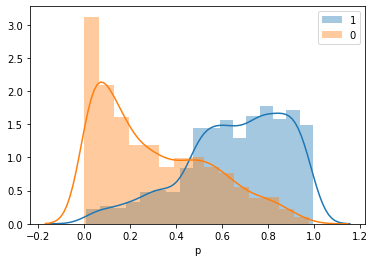

In [84]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    #'objective': 'tweedie','metric': 'tweedie',
     
    'objective': 'xentropy','metric': 'xentropy',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'max_bin': 50, 'subsample': 0.8509082362331666, 'subsample_freq': 0.6958806976511948, 'learning_rate': 0.09406169926162017,
    'num_leaves': 7, 'feature_fraction': 0.7562554580497556, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021420978217365439,
    'lambda_l2': 0.011867471326820044
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.4 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p, label='1')
sns.distplot(off_df[off_df.jobflag_2==0].p, label='0')
plt.legend()

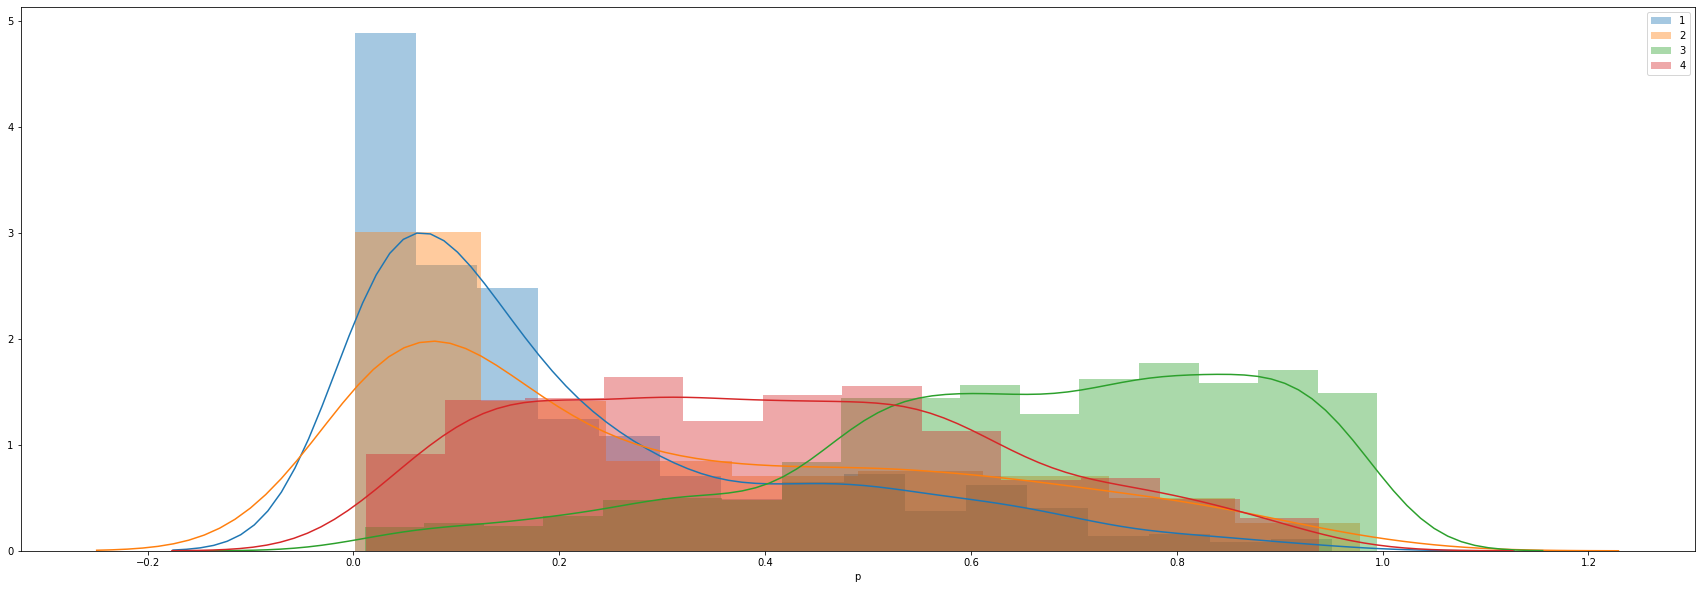

In [85]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()